In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV4'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.add_gaussian_noise_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(660000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.freehand_v4(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 128, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 16)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 64, 16)         64        
_________________________________________________________________
dense (Dense)                (None, 1, 64, 256)        4352  

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/581 [..............................] - ETA: 2:18:22 - loss: 2.8734

  4/581 [..............................] - ETA: 14s - loss: 2.7601    

  7/581 [..............................] - ETA: 13s - loss: 2.6980

 10/581 [..............................] - ETA: 13s - loss: 2.6476

 13/581 [..............................] - ETA: 13s - loss: 2.6053

 16/581 [..............................] - ETA: 13s - loss: 2.5692

 19/581 [..............................] - ETA: 13s - loss: 2.5375

 22/581 [>.............................] - ETA: 13s - loss: 2.5087

 25/581 [>.............................] - ETA: 13s - loss: 2.4821

 28/581 [>.............................] - ETA: 13s - loss: 2.4574

 31/581 [>.............................] - ETA: 13s - loss: 2.4345

 34/581 [>.............................] - ETA: 13s - loss: 2.4131

 37/581 [>.............................] - ETA: 13s - loss: 2.3932

 40/581 [=>............................] - ETA: 13s - loss: 2.3744

 43/581 [=>............................] - ETA: 12s - loss: 2.3566

 45/581 [=>............................] - ETA: 12s - loss: 2.3452

 48/581 [=>............................] - ETA: 12s - loss: 2.3287

 51/581 [=>............................] - ETA: 12s - loss: 2.3130

 54/581 [=>............................] - ETA: 12s - loss: 2.2980

 57/581 [=>............................] - ETA: 12s - loss: 2.2836

 60/581 [==>...........................] - ETA: 12s - loss: 2.2698

 63/581 [==>...........................] - ETA: 12s - loss: 2.2565

 66/581 [==>...........................] - ETA: 12s - loss: 2.2437

 69/581 [==>...........................] - ETA: 12s - loss: 2.2313

 72/581 [==>...........................] - ETA: 12s - loss: 2.2193

 75/581 [==>...........................] - ETA: 12s - loss: 2.2076

 78/581 [===>..........................] - ETA: 12s - loss: 2.1963

 81/581 [===>..........................] - ETA: 12s - loss: 2.1854

 84/581 [===>..........................] - ETA: 12s - loss: 2.1748

 87/581 [===>..........................] - ETA: 11s - loss: 2.1645

 90/581 [===>..........................] - ETA: 11s - loss: 2.1545

 93/581 [===>..........................] - ETA: 11s - loss: 2.1447

 96/581 [===>..........................] - ETA: 11s - loss: 2.1353

 99/581 [====>.........................] - ETA: 11s - loss: 2.1261



102/581 [====>.........................] - ETA: 11s - loss: 2.1171

105/581 [====>.........................] - ETA: 11s - loss: 2.1085

108/581 [====>.........................] - ETA: 11s - loss: 2.1000

111/581 [====>.........................] - ETA: 11s - loss: 2.0918

114/581 [====>.........................] - ETA: 11s - loss: 2.0838

117/581 [=====>........................] - ETA: 11s - loss: 2.0760

120/581 [=====>........................] - ETA: 11s - loss: 2.0683

123/581 [=====>........................] - ETA: 11s - loss: 2.0608

126/581 [=====>........................] - ETA: 10s - loss: 2.0535

129/581 [=====>........................] - ETA: 10s - loss: 2.0464

132/581 [=====>........................] - ETA: 10s - loss: 2.0395

135/581 [=====>........................] - ETA: 10s - loss: 2.0327

138/581 [======>.......................] - ETA: 10s - loss: 2.0260

141/581 [======>.......................] - ETA: 10s - loss: 2.0195

144/581 [======>.......................] - ETA: 10s - loss: 2.0132

147/581 [======>.......................] - ETA: 10s - loss: 2.0070

150/581 [======>.......................] - ETA: 10s - loss: 2.0009

153/581 [======>.......................] - ETA: 10s - loss: 1.9949

156/581 [=======>......................] - ETA: 10s - loss: 1.9891

159/581 [=======>......................] - ETA: 10s - loss: 1.9834

162/581 [=======>......................] - ETA: 10s - loss: 1.9778

165/581 [=======>......................] - ETA: 10s - loss: 1.9723

168/581 [=======>......................] - ETA: 9s - loss: 1.9668 

171/581 [=======>......................] - ETA: 9s - loss: 1.9615

174/581 [=======>......................] - ETA: 9s - loss: 1.9563

177/581 [========>.....................] - ETA: 9s - loss: 1.9512

180/581 [========>.....................] - ETA: 9s - loss: 1.9462

183/581 [========>.....................] - ETA: 9s - loss: 1.9413

186/581 [========>.....................] - ETA: 9s - loss: 1.9365

189/581 [========>.....................] - ETA: 9s - loss: 1.9318

192/581 [========>.....................] - ETA: 9s - loss: 1.9271

195/581 [=========>....................] - ETA: 9s - loss: 1.9226

198/581 [=========>....................] - ETA: 9s - loss: 1.9181

201/581 [=========>....................] - ETA: 9s - loss: 1.9137

204/581 [=========>....................] - ETA: 9s - loss: 1.9093

207/581 [=========>....................] - ETA: 9s - loss: 1.9051

210/581 [=========>....................] - ETA: 8s - loss: 1.9009

213/581 [=========>....................] - ETA: 8s - loss: 1.8967

216/581 [==========>...................] - ETA: 8s - loss: 1.8926

219/581 [==========>...................] - ETA: 8s - loss: 1.8886

222/581 [==========>...................] - ETA: 8s - loss: 1.8847

225/581 [==========>...................] - ETA: 8s - loss: 1.8808

228/581 [==========>...................] - ETA: 8s - loss: 1.8770

231/581 [==========>...................] - ETA: 8s - loss: 1.8732

234/581 [===========>..................] - ETA: 8s - loss: 1.8695

237/581 [===========>..................] - ETA: 8s - loss: 1.8659

240/581 [===========>..................] - ETA: 8s - loss: 1.8623

243/581 [===========>..................] - ETA: 8s - loss: 1.8587

246/581 [===========>..................] - ETA: 8s - loss: 1.8553

249/581 [===========>..................] - ETA: 8s - loss: 1.8518

252/581 [============>.................] - ETA: 7s - loss: 1.8484

255/581 [============>.................] - ETA: 7s - loss: 1.8451

258/581 [============>.................] - ETA: 7s - loss: 1.8418



261/581 [============>.................] - ETA: 7s - loss: 1.8386

264/581 [============>.................] - ETA: 7s - loss: 1.8354

267/581 [============>.................] - ETA: 7s - loss: 1.8322

270/581 [============>.................] - ETA: 7s - loss: 1.8291

273/581 [=============>................] - ETA: 7s - loss: 1.8260

276/581 [=============>................] - ETA: 7s - loss: 1.8230

279/581 [=============>................] - ETA: 7s - loss: 1.8200

282/581 [=============>................] - ETA: 7s - loss: 1.8171

285/581 [=============>................] - ETA: 7s - loss: 1.8142

288/581 [=============>................] - ETA: 7s - loss: 1.8113

291/581 [==============>...............] - ETA: 6s - loss: 1.8085

294/581 [==============>...............] - ETA: 6s - loss: 1.8057

297/581 [==============>...............] - ETA: 6s - loss: 1.8029

300/581 [==============>...............] - ETA: 6s - loss: 1.8002

303/581 [==============>...............] - ETA: 6s - loss: 1.7975

306/581 [==============>...............] - ETA: 6s - loss: 1.7949

309/581 [==============>...............] - ETA: 6s - loss: 1.7922

312/581 [===============>..............] - ETA: 6s - loss: 1.7896

315/581 [===============>..............] - ETA: 6s - loss: 1.7871

318/581 [===============>..............] - ETA: 6s - loss: 1.7845

321/581 [===============>..............] - ETA: 6s - loss: 1.7820

324/581 [===============>..............] - ETA: 6s - loss: 1.7796

327/581 [===============>..............] - ETA: 6s - loss: 1.7771

330/581 [================>.............] - ETA: 6s - loss: 1.7747

333/581 [================>.............] - ETA: 5s - loss: 1.7723

336/581 [================>.............] - ETA: 5s - loss: 1.7700

339/581 [================>.............] - ETA: 5s - loss: 1.7676

342/581 [================>.............] - ETA: 5s - loss: 1.7653

345/581 [================>.............] - ETA: 5s - loss: 1.7630

348/581 [================>.............] - ETA: 5s - loss: 1.7608

351/581 [=================>............] - ETA: 5s - loss: 1.7585

354/581 [=================>............] - ETA: 5s - loss: 1.7563

357/581 [=================>............] - ETA: 5s - loss: 1.7541

360/581 [=================>............] - ETA: 5s - loss: 1.7520

363/581 [=================>............] - ETA: 5s - loss: 1.7498

365/581 [=================>............] - ETA: 5s - loss: 1.7484

368/581 [==================>...........] - ETA: 5s - loss: 1.7463

371/581 [==================>...........] - ETA: 5s - loss: 1.7442

374/581 [==================>...........] - ETA: 4s - loss: 1.7422

377/581 [==================>...........] - ETA: 4s - loss: 1.7401

380/581 [==================>...........] - ETA: 4s - loss: 1.7381

383/581 [==================>...........] - ETA: 4s - loss: 1.7361

386/581 [==================>...........] - ETA: 4s - loss: 1.7341

389/581 [===================>..........] - ETA: 4s - loss: 1.7322

392/581 [===================>..........] - ETA: 4s - loss: 1.7302

395/581 [===================>..........] - ETA: 4s - loss: 1.7283

398/581 [===================>..........] - ETA: 4s - loss: 1.7264

401/581 [===================>..........] - ETA: 4s - loss: 1.7245

404/581 [===================>..........] - ETA: 4s - loss: 1.7227

407/581 [====================>.........] - ETA: 4s - loss: 1.7208

410/581 [====================>.........] - ETA: 4s - loss: 1.7190

413/581 [====================>.........] - ETA: 4s - loss: 1.7172

416/581 [====================>.........] - ETA: 3s - loss: 1.7154

419/581 [====================>.........] - ETA: 3s - loss: 1.7136

422/581 [====================>.........] - ETA: 3s - loss: 1.7118

425/581 [====================>.........] - ETA: 3s - loss: 1.7101

428/581 [=====================>........] - ETA: 3s - loss: 1.7084

431/581 [=====================>........] - ETA: 3s - loss: 1.7066

434/581 [=====================>........] - ETA: 3s - loss: 1.7049

437/581 [=====================>........] - ETA: 3s - loss: 1.7033

440/581 [=====================>........] - ETA: 3s - loss: 1.7016

443/581 [=====================>........] - ETA: 3s - loss: 1.6999

446/581 [======================>.......] - ETA: 3s - loss: 1.6983

449/581 [======================>.......] - ETA: 3s - loss: 1.6967

452/581 [======================>.......] - ETA: 3s - loss: 1.6951

455/581 [======================>.......] - ETA: 3s - loss: 1.6935

458/581 [======================>.......] - ETA: 2s - loss: 1.6919

461/581 [======================>.......] - ETA: 2s - loss: 1.6903

464/581 [======================>.......] - ETA: 2s - loss: 1.6888

467/581 [=======================>......] - ETA: 2s - loss: 1.6872

470/581 [=======================>......] - ETA: 2s - loss: 1.6857

473/581 [=======================>......] - ETA: 2s - loss: 1.6842

476/581 [=======================>......] - ETA: 2s - loss: 1.6827

479/581 [=======================>......] - ETA: 2s - loss: 1.6812

482/581 [=======================>......] - ETA: 2s - loss: 1.6797

485/581 [========================>.....] - ETA: 2s - loss: 1.6783

488/581 [========================>.....] - ETA: 2s - loss: 1.6768

491/581 [========================>.....] - ETA: 2s - loss: 1.6754

494/581 [========================>.....] - ETA: 2s - loss: 1.6740

497/581 [========================>.....] - ETA: 2s - loss: 1.6725

500/581 [========================>.....] - ETA: 1s - loss: 1.6711

503/581 [========================>.....] - ETA: 1s - loss: 1.6697

506/581 [=========================>....] - ETA: 1s - loss: 1.6684

509/581 [=========================>....] - ETA: 1s - loss: 1.6670

512/581 [=========================>....] - ETA: 1s - loss: 1.6656

515/581 [=========================>....] - ETA: 1s - loss: 1.6643

518/581 [=========================>....] - ETA: 1s - loss: 1.6629

521/581 [=========================>....] - ETA: 1s - loss: 1.6616

524/581 [==========================>...] - ETA: 1s - loss: 1.6603

527/581 [==========================>...] - ETA: 1s - loss: 1.6590

530/581 [==========================>...] - ETA: 1s - loss: 1.6577

533/581 [==========================>...] - ETA: 1s - loss: 1.6564

536/581 [==========================>...] - ETA: 1s - loss: 1.6551

539/581 [==========================>...] - ETA: 1s - loss: 1.6538

542/581 [==========================>...] - ETA: 0s - loss: 1.6526

545/581 [===========================>..] - ETA: 0s - loss: 1.6513

548/581 [===========================>..] - ETA: 0s - loss: 1.6501

551/581 [===========================>..] - ETA: 0s - loss: 1.6488

554/581 [===========================>..] - ETA: 0s - loss: 1.6476

557/581 [===========================>..] - ETA: 0s - loss: 1.6464

560/581 [===========================>..] - ETA: 0s - loss: 1.6452

563/581 [============================>.] - ETA: 0s - loss: 1.6440

566/581 [============================>.] - ETA: 0s - loss: 1.6428

569/581 [============================>.] - ETA: 0s - loss: 1.6416

572/581 [============================>.] - ETA: 0s - loss: 1.6404

575/581 [============================>.] - ETA: 0s - loss: 1.6393

578/581 [============================>.] - ETA: 0s - loss: 1.6381

581/581 [==============================] - ETA: 0s - loss: 1.6370

581/581 [==============================] - 30s 27ms/step - loss: 1.6366 - val_loss: 2.5866


Epoch 2/100
  1/581 [..............................] - ETA: 14s - loss: 1.2547

  4/581 [..............................] - ETA: 14s - loss: 1.2548

  7/581 [..............................] - ETA: 13s - loss: 1.2572

 10/581 [..............................] - ETA: 13s - loss: 1.2557

 13/581 [..............................] - ETA: 13s - loss: 1.2566

 16/581 [..............................] - ETA: 13s - loss: 1.2567

 19/581 [..............................] - ETA: 13s - loss: 1.2569

 22/581 [>.............................] - ETA: 13s - loss: 1.2576

 25/581 [>.............................] - ETA: 13s - loss: 1.2583

 28/581 [>.............................] - ETA: 13s - loss: 1.2587

 31/581 [>.............................] - ETA: 13s - loss: 1.2589

 34/581 [>.............................] - ETA: 13s - loss: 1.2593

 37/581 [>.............................] - ETA: 13s - loss: 1.2596

 40/581 [=>............................] - ETA: 13s - loss: 1.2600

 43/581 [=>............................] - ETA: 12s - loss: 1.2604

 46/581 [=>............................] - ETA: 12s - loss: 1.2607

 49/581 [=>............................] - ETA: 12s - loss: 1.2610

 52/581 [=>............................] - ETA: 12s - loss: 1.2613

 55/581 [=>............................] - ETA: 12s - loss: 1.2615

 58/581 [=>............................] - ETA: 12s - loss: 1.2617

 61/581 [==>...........................] - ETA: 12s - loss: 1.2618

 64/581 [==>...........................] - ETA: 12s - loss: 1.2619

 67/581 [==>...........................] - ETA: 12s - loss: 1.2620

 70/581 [==>...........................] - ETA: 12s - loss: 1.2620

 73/581 [==>...........................] - ETA: 12s - loss: 1.2620

 76/581 [==>...........................] - ETA: 12s - loss: 1.2621

 79/581 [===>..........................] - ETA: 12s - loss: 1.2621

 82/581 [===>..........................] - ETA: 12s - loss: 1.2621

 85/581 [===>..........................] - ETA: 11s - loss: 1.2621

 88/581 [===>..........................] - ETA: 11s - loss: 1.2621

 91/581 [===>..........................] - ETA: 11s - loss: 1.2620

 94/581 [===>..........................] - ETA: 11s - loss: 1.2620

 97/581 [====>.........................] - ETA: 11s - loss: 1.2620

100/581 [====>.........................] - ETA: 11s - loss: 1.2620

103/581 [====>.........................] - ETA: 11s - loss: 1.2619

106/581 [====>.........................] - ETA: 11s - loss: 1.2619

109/581 [====>.........................] - ETA: 11s - loss: 1.2619

112/581 [====>.........................] - ETA: 11s - loss: 1.2619

115/581 [====>.........................] - ETA: 11s - loss: 1.2619

118/581 [=====>........................] - ETA: 11s - loss: 1.2619

121/581 [=====>........................] - ETA: 11s - loss: 1.2618

124/581 [=====>........................] - ETA: 11s - loss: 1.2618

127/581 [=====>........................] - ETA: 10s - loss: 1.2618

130/581 [=====>........................] - ETA: 10s - loss: 1.2618

133/581 [=====>........................] - ETA: 10s - loss: 1.2618

136/581 [======>.......................] - ETA: 10s - loss: 1.2618

139/581 [======>.......................] - ETA: 10s - loss: 1.2617

142/581 [======>.......................] - ETA: 10s - loss: 1.2617

145/581 [======>.......................] - ETA: 10s - loss: 1.2617

148/581 [======>.......................] - ETA: 10s - loss: 1.2616

151/581 [======>.......................] - ETA: 10s - loss: 1.2616

154/581 [======>.......................] - ETA: 10s - loss: 1.2616

157/581 [=======>......................] - ETA: 10s - loss: 1.2615

160/581 [=======>......................] - ETA: 10s - loss: 1.2615

163/581 [=======>......................] - ETA: 10s - loss: 1.2614

166/581 [=======>......................] - ETA: 10s - loss: 1.2614

169/581 [=======>......................] - ETA: 9s - loss: 1.2613 

172/581 [=======>......................] - ETA: 9s - loss: 1.2612

175/581 [========>.....................] - ETA: 9s - loss: 1.2612

178/581 [========>.....................] - ETA: 9s - loss: 1.2611

181/581 [========>.....................] - ETA: 9s - loss: 1.2610

184/581 [========>.....................] - ETA: 9s - loss: 1.2610

187/581 [========>.....................] - ETA: 9s - loss: 1.2609

190/581 [========>.....................] - ETA: 9s - loss: 1.2609

193/581 [========>.....................] - ETA: 9s - loss: 1.2608

196/581 [=========>....................] - ETA: 9s - loss: 1.2607

199/581 [=========>....................] - ETA: 9s - loss: 1.2607

202/581 [=========>....................] - ETA: 9s - loss: 1.2606

205/581 [=========>....................] - ETA: 9s - loss: 1.2606

208/581 [=========>....................] - ETA: 9s - loss: 1.2605

211/581 [=========>....................] - ETA: 8s - loss: 1.2604

214/581 [==========>...................] - ETA: 8s - loss: 1.2604

217/581 [==========>...................] - ETA: 8s - loss: 1.2603

220/581 [==========>...................] - ETA: 8s - loss: 1.2603

223/581 [==========>...................] - ETA: 8s - loss: 1.2602

226/581 [==========>...................] - ETA: 8s - loss: 1.2602

229/581 [==========>...................] - ETA: 8s - loss: 1.2601

232/581 [==========>...................] - ETA: 8s - loss: 1.2600

235/581 [===========>..................] - ETA: 8s - loss: 1.2600

238/581 [===========>..................] - ETA: 8s - loss: 1.2599

241/581 [===========>..................] - ETA: 8s - loss: 1.2599

244/581 [===========>..................] - ETA: 8s - loss: 1.2598

247/581 [===========>..................] - ETA: 8s - loss: 1.2598

250/581 [===========>..................] - ETA: 7s - loss: 1.2597

253/581 [============>.................] - ETA: 7s - loss: 1.2596

256/581 [============>.................] - ETA: 7s - loss: 1.2596

259/581 [============>.................] - ETA: 7s - loss: 1.2595

262/581 [============>.................] - ETA: 7s - loss: 1.2595

265/581 [============>.................] - ETA: 7s - loss: 1.2594

268/581 [============>.................] - ETA: 7s - loss: 1.2594

271/581 [============>.................] - ETA: 7s - loss: 1.2593

274/581 [=============>................] - ETA: 7s - loss: 1.2592

277/581 [=============>................] - ETA: 7s - loss: 1.2592

280/581 [=============>................] - ETA: 7s - loss: 1.2591

283/581 [=============>................] - ETA: 7s - loss: 1.2590

286/581 [=============>................] - ETA: 7s - loss: 1.2590

289/581 [=============>................] - ETA: 7s - loss: 1.2589

292/581 [==============>...............] - ETA: 6s - loss: 1.2588

295/581 [==============>...............] - ETA: 6s - loss: 1.2588

298/581 [==============>...............] - ETA: 6s - loss: 1.2587

301/581 [==============>...............] - ETA: 6s - loss: 1.2586

304/581 [==============>...............] - ETA: 6s - loss: 1.2586

307/581 [==============>...............] - ETA: 6s - loss: 1.2585

310/581 [===============>..............] - ETA: 6s - loss: 1.2584

313/581 [===============>..............] - ETA: 6s - loss: 1.2584

316/581 [===============>..............] - ETA: 6s - loss: 1.2583

319/581 [===============>..............] - ETA: 6s - loss: 1.2582

322/581 [===============>..............] - ETA: 6s - loss: 1.2582

325/581 [===============>..............] - ETA: 6s - loss: 1.2581

328/581 [===============>..............] - ETA: 6s - loss: 1.2580

331/581 [================>.............] - ETA: 6s - loss: 1.2579

334/581 [================>.............] - ETA: 5s - loss: 1.2579

337/581 [================>.............] - ETA: 5s - loss: 1.2578

340/581 [================>.............] - ETA: 5s - loss: 1.2577

343/581 [================>.............] - ETA: 5s - loss: 1.2577

346/581 [================>.............] - ETA: 5s - loss: 1.2576

349/581 [=================>............] - ETA: 5s - loss: 1.2575

352/581 [=================>............] - ETA: 5s - loss: 1.2574

355/581 [=================>............] - ETA: 5s - loss: 1.2573

358/581 [=================>............] - ETA: 5s - loss: 1.2573

361/581 [=================>............] - ETA: 5s - loss: 1.2572

364/581 [=================>............] - ETA: 5s - loss: 1.2571

367/581 [=================>............] - ETA: 5s - loss: 1.2570

370/581 [==================>...........] - ETA: 5s - loss: 1.2570

373/581 [==================>...........] - ETA: 5s - loss: 1.2569

376/581 [==================>...........] - ETA: 4s - loss: 1.2568

379/581 [==================>...........] - ETA: 4s - loss: 1.2567

382/581 [==================>...........] - ETA: 4s - loss: 1.2566

385/581 [==================>...........] - ETA: 4s - loss: 1.2566

388/581 [===================>..........] - ETA: 4s - loss: 1.2565

391/581 [===================>..........] - ETA: 4s - loss: 1.2564

394/581 [===================>..........] - ETA: 4s - loss: 1.2563

397/581 [===================>..........] - ETA: 4s - loss: 1.2562

400/581 [===================>..........] - ETA: 4s - loss: 1.2562

403/581 [===================>..........] - ETA: 4s - loss: 1.2561

406/581 [===================>..........] - ETA: 4s - loss: 1.2560

409/581 [====================>.........] - ETA: 4s - loss: 1.2559

412/581 [====================>.........] - ETA: 4s - loss: 1.2558

415/581 [====================>.........] - ETA: 4s - loss: 1.2558

418/581 [====================>.........] - ETA: 3s - loss: 1.2557

421/581 [====================>.........] - ETA: 3s - loss: 1.2556

424/581 [====================>.........] - ETA: 3s - loss: 1.2555

427/581 [=====================>........] - ETA: 3s - loss: 1.2554

430/581 [=====================>........] - ETA: 3s - loss: 1.2554

433/581 [=====================>........] - ETA: 3s - loss: 1.2553

436/581 [=====================>........] - ETA: 3s - loss: 1.2552

439/581 [=====================>........] - ETA: 3s - loss: 1.2551

442/581 [=====================>........] - ETA: 3s - loss: 1.2550

445/581 [=====================>........] - ETA: 3s - loss: 1.2549

448/581 [======================>.......] - ETA: 3s - loss: 1.2549

451/581 [======================>.......] - ETA: 3s - loss: 1.2548

454/581 [======================>.......] - ETA: 3s - loss: 1.2547

457/581 [======================>.......] - ETA: 2s - loss: 1.2546

460/581 [======================>.......] - ETA: 2s - loss: 1.2545

463/581 [======================>.......] - ETA: 2s - loss: 1.2544

466/581 [=======================>......] - ETA: 2s - loss: 1.2544

469/581 [=======================>......] - ETA: 2s - loss: 1.2543

472/581 [=======================>......] - ETA: 2s - loss: 1.2542

475/581 [=======================>......] - ETA: 2s - loss: 1.2541

478/581 [=======================>......] - ETA: 2s - loss: 1.2540

481/581 [=======================>......] - ETA: 2s - loss: 1.2539

484/581 [=======================>......] - ETA: 2s - loss: 1.2539

487/581 [========================>.....] - ETA: 2s - loss: 1.2538

490/581 [========================>.....] - ETA: 2s - loss: 1.2537

493/581 [========================>.....] - ETA: 2s - loss: 1.2536

496/581 [========================>.....] - ETA: 2s - loss: 1.2535

499/581 [========================>.....] - ETA: 1s - loss: 1.2535

502/581 [========================>.....] - ETA: 1s - loss: 1.2534

505/581 [=========================>....] - ETA: 1s - loss: 1.2533

508/581 [=========================>....] - ETA: 1s - loss: 1.2532



511/581 [=========================>....] - ETA: 1s - loss: 1.2531

514/581 [=========================>....] - ETA: 1s - loss: 1.2530

517/581 [=========================>....] - ETA: 1s - loss: 1.2529

520/581 [=========================>....] - ETA: 1s - loss: 1.2529

523/581 [==========================>...] - ETA: 1s - loss: 1.2528

526/581 [==========================>...] - ETA: 1s - loss: 1.2527

529/581 [==========================>...] - ETA: 1s - loss: 1.2526

532/581 [==========================>...] - ETA: 1s - loss: 1.2525

535/581 [==========================>...] - ETA: 1s - loss: 1.2524

538/581 [==========================>...] - ETA: 1s - loss: 1.2524

541/581 [==========================>...] - ETA: 0s - loss: 1.2523

544/581 [===========================>..] - ETA: 0s - loss: 1.2522

547/581 [===========================>..] - ETA: 0s - loss: 1.2521

550/581 [===========================>..] - ETA: 0s - loss: 1.2520

553/581 [===========================>..] - ETA: 0s - loss: 1.2519

556/581 [===========================>..] - ETA: 0s - loss: 1.2519

559/581 [===========================>..] - ETA: 0s - loss: 1.2518

562/581 [============================>.] - ETA: 0s - loss: 1.2517

565/581 [============================>.] - ETA: 0s - loss: 1.2516

568/581 [============================>.] - ETA: 0s - loss: 1.2515

571/581 [============================>.] - ETA: 0s - loss: 1.2515

574/581 [============================>.] - ETA: 0s - loss: 1.2514

577/581 [============================>.] - ETA: 0s - loss: 1.2513

580/581 [============================>.] - ETA: 0s - loss: 1.2512

581/581 [==============================] - 15s 25ms/step - loss: 1.2512 - val_loss: 1.1935


Epoch 3/100


  1/581 [..............................] - ETA: 14s - loss: 1.2166

  4/581 [..............................] - ETA: 14s - loss: 1.2392

  7/581 [..............................] - ETA: 13s - loss: 1.2361

 10/581 [..............................] - ETA: 13s - loss: 1.2344

 13/581 [..............................] - ETA: 13s - loss: 1.2329

 16/581 [..............................] - ETA: 13s - loss: 1.2303

 19/581 [..............................] - ETA: 13s - loss: 1.2275

 22/581 [>.............................] - ETA: 13s - loss: 1.2251

 25/581 [>.............................] - ETA: 13s - loss: 1.2231

 28/581 [>.............................] - ETA: 13s - loss: 1.2218

 31/581 [>.............................] - ETA: 13s - loss: 1.2207

 34/581 [>.............................] - ETA: 13s - loss: 1.2198

 37/581 [>.............................] - ETA: 13s - loss: 1.2189

 40/581 [=>............................] - ETA: 13s - loss: 1.2179

 43/581 [=>............................] - ETA: 13s - loss: 1.2171

 46/581 [=>............................] - ETA: 12s - loss: 1.2163

 49/581 [=>............................] - ETA: 12s - loss: 1.2156

 52/581 [=>............................] - ETA: 12s - loss: 1.2150

 55/581 [=>............................] - ETA: 12s - loss: 1.2144

 58/581 [=>............................] - ETA: 12s - loss: 1.2139

 61/581 [==>...........................] - ETA: 12s - loss: 1.2135

 64/581 [==>...........................] - ETA: 12s - loss: 1.2130

 67/581 [==>...........................] - ETA: 12s - loss: 1.2126

 70/581 [==>...........................] - ETA: 12s - loss: 1.2123

 73/581 [==>...........................] - ETA: 12s - loss: 1.2119

 76/581 [==>...........................] - ETA: 12s - loss: 1.2116

 79/581 [===>..........................] - ETA: 12s - loss: 1.2114

 82/581 [===>..........................] - ETA: 12s - loss: 1.2111

 85/581 [===>..........................] - ETA: 11s - loss: 1.2109

 88/581 [===>..........................] - ETA: 11s - loss: 1.2106

 91/581 [===>..........................] - ETA: 11s - loss: 1.2104

 94/581 [===>..........................] - ETA: 11s - loss: 1.2101

 97/581 [====>.........................] - ETA: 11s - loss: 1.2099

100/581 [====>.........................] - ETA: 11s - loss: 1.2097

103/581 [====>.........................] - ETA: 11s - loss: 1.2095

106/581 [====>.........................] - ETA: 11s - loss: 1.2093

109/581 [====>.........................] - ETA: 11s - loss: 1.2091

112/581 [====>.........................] - ETA: 11s - loss: 1.2090

115/581 [====>.........................] - ETA: 11s - loss: 1.2088

118/581 [=====>........................] - ETA: 11s - loss: 1.2086

121/581 [=====>........................] - ETA: 11s - loss: 1.2085

124/581 [=====>........................] - ETA: 11s - loss: 1.2083

127/581 [=====>........................] - ETA: 10s - loss: 1.2081

130/581 [=====>........................] - ETA: 10s - loss: 1.2080

133/581 [=====>........................] - ETA: 10s - loss: 1.2078

136/581 [======>.......................] - ETA: 10s - loss: 1.2076

139/581 [======>.......................] - ETA: 10s - loss: 1.2075

142/581 [======>.......................] - ETA: 10s - loss: 1.2073

145/581 [======>.......................] - ETA: 10s - loss: 1.2072

148/581 [======>.......................] - ETA: 10s - loss: 1.2071

151/581 [======>.......................] - ETA: 10s - loss: 1.2069

154/581 [======>.......................] - ETA: 10s - loss: 1.2068

157/581 [=======>......................] - ETA: 10s - loss: 1.2067

160/581 [=======>......................] - ETA: 10s - loss: 1.2065

163/581 [=======>......................] - ETA: 10s - loss: 1.2064

166/581 [=======>......................] - ETA: 10s - loss: 1.2062

169/581 [=======>......................] - ETA: 9s - loss: 1.2061 

172/581 [=======>......................] - ETA: 9s - loss: 1.2059

175/581 [========>.....................] - ETA: 9s - loss: 1.2058

178/581 [========>.....................] - ETA: 9s - loss: 1.2056

181/581 [========>.....................] - ETA: 9s - loss: 1.2055

184/581 [========>.....................] - ETA: 9s - loss: 1.2053

187/581 [========>.....................] - ETA: 9s - loss: 1.2052

190/581 [========>.....................] - ETA: 9s - loss: 1.2050

193/581 [========>.....................] - ETA: 9s - loss: 1.2049

196/581 [=========>....................] - ETA: 9s - loss: 1.2047

199/581 [=========>....................] - ETA: 9s - loss: 1.2046

202/581 [=========>....................] - ETA: 9s - loss: 1.2045

205/581 [=========>....................] - ETA: 9s - loss: 1.2043

208/581 [=========>....................] - ETA: 9s - loss: 1.2042

211/581 [=========>....................] - ETA: 8s - loss: 1.2040

214/581 [==========>...................] - ETA: 8s - loss: 1.2039

217/581 [==========>...................] - ETA: 8s - loss: 1.2038

220/581 [==========>...................] - ETA: 8s - loss: 1.2037

223/581 [==========>...................] - ETA: 8s - loss: 1.2036

226/581 [==========>...................] - ETA: 8s - loss: 1.2035

229/581 [==========>...................] - ETA: 8s - loss: 1.2034

232/581 [==========>...................] - ETA: 8s - loss: 1.2033

235/581 [===========>..................] - ETA: 8s - loss: 1.2032

238/581 [===========>..................] - ETA: 8s - loss: 1.2031

241/581 [===========>..................] - ETA: 8s - loss: 1.2031

244/581 [===========>..................] - ETA: 8s - loss: 1.2030

247/581 [===========>..................] - ETA: 8s - loss: 1.2029

250/581 [===========>..................] - ETA: 7s - loss: 1.2028

253/581 [============>.................] - ETA: 7s - loss: 1.2028

256/581 [============>.................] - ETA: 7s - loss: 1.2027

259/581 [============>.................] - ETA: 7s - loss: 1.2026

262/581 [============>.................] - ETA: 7s - loss: 1.2025

265/581 [============>.................] - ETA: 7s - loss: 1.2025

268/581 [============>.................] - ETA: 7s - loss: 1.2024

271/581 [============>.................] - ETA: 7s - loss: 1.2023

274/581 [=============>................] - ETA: 7s - loss: 1.2023

277/581 [=============>................] - ETA: 7s - loss: 1.2022

280/581 [=============>................] - ETA: 7s - loss: 1.2021

283/581 [=============>................] - ETA: 7s - loss: 1.2021

286/581 [=============>................] - ETA: 7s - loss: 1.2020

289/581 [=============>................] - ETA: 7s - loss: 1.2019

292/581 [==============>...............] - ETA: 6s - loss: 1.2019

295/581 [==============>...............] - ETA: 6s - loss: 1.2018

298/581 [==============>...............] - ETA: 6s - loss: 1.2017

301/581 [==============>...............] - ETA: 6s - loss: 1.2017

304/581 [==============>...............] - ETA: 6s - loss: 1.2016

307/581 [==============>...............] - ETA: 6s - loss: 1.2016

310/581 [===============>..............] - ETA: 6s - loss: 1.2015

313/581 [===============>..............] - ETA: 6s - loss: 1.2014

316/581 [===============>..............] - ETA: 6s - loss: 1.2014

319/581 [===============>..............] - ETA: 6s - loss: 1.2013

322/581 [===============>..............] - ETA: 6s - loss: 1.2012

325/581 [===============>..............] - ETA: 6s - loss: 1.2012

328/581 [===============>..............] - ETA: 6s - loss: 1.2011

331/581 [================>.............] - ETA: 6s - loss: 1.2011

334/581 [================>.............] - ETA: 5s - loss: 1.2010

337/581 [================>.............] - ETA: 5s - loss: 1.2009

340/581 [================>.............] - ETA: 5s - loss: 1.2009

343/581 [================>.............] - ETA: 5s - loss: 1.2008

346/581 [================>.............] - ETA: 5s - loss: 1.2008

349/581 [=================>............] - ETA: 5s - loss: 1.2007

352/581 [=================>............] - ETA: 5s - loss: 1.2006

355/581 [=================>............] - ETA: 5s - loss: 1.2006

358/581 [=================>............] - ETA: 5s - loss: 1.2005

361/581 [=================>............] - ETA: 5s - loss: 1.2005

364/581 [=================>............] - ETA: 5s - loss: 1.2004

367/581 [=================>............] - ETA: 5s - loss: 1.2003

370/581 [==================>...........] - ETA: 5s - loss: 1.2003

373/581 [==================>...........] - ETA: 5s - loss: 1.2002

376/581 [==================>...........] - ETA: 4s - loss: 1.2002

379/581 [==================>...........] - ETA: 4s - loss: 1.2001

382/581 [==================>...........] - ETA: 4s - loss: 1.2001

385/581 [==================>...........] - ETA: 4s - loss: 1.2000

388/581 [===================>..........] - ETA: 4s - loss: 1.2000

391/581 [===================>..........] - ETA: 4s - loss: 1.1999

394/581 [===================>..........] - ETA: 4s - loss: 1.1999

397/581 [===================>..........] - ETA: 4s - loss: 1.1998

400/581 [===================>..........] - ETA: 4s - loss: 1.1998

403/581 [===================>..........] - ETA: 4s - loss: 1.1997

406/581 [===================>..........] - ETA: 4s - loss: 1.1997

409/581 [====================>.........] - ETA: 4s - loss: 1.1996

412/581 [====================>.........] - ETA: 4s - loss: 1.1996

415/581 [====================>.........] - ETA: 4s - loss: 1.1995

418/581 [====================>.........] - ETA: 3s - loss: 1.1995

421/581 [====================>.........] - ETA: 3s - loss: 1.1994

424/581 [====================>.........] - ETA: 3s - loss: 1.1994

427/581 [=====================>........] - ETA: 3s - loss: 1.1993

430/581 [=====================>........] - ETA: 3s - loss: 1.1993

433/581 [=====================>........] - ETA: 3s - loss: 1.1992

436/581 [=====================>........] - ETA: 3s - loss: 1.1992

439/581 [=====================>........] - ETA: 3s - loss: 1.1992

442/581 [=====================>........] - ETA: 3s - loss: 1.1991

445/581 [=====================>........] - ETA: 3s - loss: 1.1991

448/581 [======================>.......] - ETA: 3s - loss: 1.1990

451/581 [======================>.......] - ETA: 3s - loss: 1.1990

454/581 [======================>.......] - ETA: 3s - loss: 1.1989

457/581 [======================>.......] - ETA: 2s - loss: 1.1989

460/581 [======================>.......] - ETA: 2s - loss: 1.1989

463/581 [======================>.......] - ETA: 2s - loss: 1.1988

466/581 [=======================>......] - ETA: 2s - loss: 1.1988

469/581 [=======================>......] - ETA: 2s - loss: 1.1987

472/581 [=======================>......] - ETA: 2s - loss: 1.1987

475/581 [=======================>......] - ETA: 2s - loss: 1.1986

478/581 [=======================>......] - ETA: 2s - loss: 1.1986

481/581 [=======================>......] - ETA: 2s - loss: 1.1986

484/581 [=======================>......] - ETA: 2s - loss: 1.1985

487/581 [========================>.....] - ETA: 2s - loss: 1.1985

490/581 [========================>.....] - ETA: 2s - loss: 1.1984

493/581 [========================>.....] - ETA: 2s - loss: 1.1984

495/581 [========================>.....] - ETA: 2s - loss: 1.1984

498/581 [========================>.....] - ETA: 2s - loss: 1.1983

501/581 [========================>.....] - ETA: 1s - loss: 1.1983

504/581 [=========================>....] - ETA: 1s - loss: 1.1982

507/581 [=========================>....] - ETA: 1s - loss: 1.1982

510/581 [=========================>....] - ETA: 1s - loss: 1.1982

513/581 [=========================>....] - ETA: 1s - loss: 1.1981

516/581 [=========================>....] - ETA: 1s - loss: 1.1981

519/581 [=========================>....] - ETA: 1s - loss: 1.1980

522/581 [=========================>....] - ETA: 1s - loss: 1.1980

525/581 [==========================>...] - ETA: 1s - loss: 1.1979

528/581 [==========================>...] - ETA: 1s - loss: 1.1979

531/581 [==========================>...] - ETA: 1s - loss: 1.1979

534/581 [==========================>...] - ETA: 1s - loss: 1.1978

537/581 [==========================>...] - ETA: 1s - loss: 1.1978

540/581 [==========================>...] - ETA: 0s - loss: 1.1978

543/581 [===========================>..] - ETA: 0s - loss: 1.1977

546/581 [===========================>..] - ETA: 0s - loss: 1.1977

549/581 [===========================>..] - ETA: 0s - loss: 1.1976

552/581 [===========================>..] - ETA: 0s - loss: 1.1976

555/581 [===========================>..] - ETA: 0s - loss: 1.1976

558/581 [===========================>..] - ETA: 0s - loss: 1.1975

561/581 [===========================>..] - ETA: 0s - loss: 1.1975

564/581 [============================>.] - ETA: 0s - loss: 1.1975

567/581 [============================>.] - ETA: 0s - loss: 1.1974

570/581 [============================>.] - ETA: 0s - loss: 1.1974

573/581 [============================>.] - ETA: 0s - loss: 1.1973

576/581 [============================>.] - ETA: 0s - loss: 1.1973

579/581 [============================>.] - ETA: 0s - loss: 1.1973

581/581 [==============================] - 15s 25ms/step - loss: 1.1972 - val_loss: 1.1707


Epoch 4/100
  1/581 [..............................] - ETA: 13s - loss: 1.1474

  4/581 [..............................] - ETA: 14s - loss: 1.1631

  7/581 [..............................] - ETA: 13s - loss: 1.1716

 10/581 [..............................] - ETA: 13s - loss: 1.1738

 13/581 [..............................] - ETA: 13s - loss: 1.1758

 16/581 [..............................] - ETA: 13s - loss: 1.1771

 19/581 [..............................] - ETA: 13s - loss: 1.1792

 22/581 [>.............................] - ETA: 13s - loss: 1.1803

 25/581 [>.............................] - ETA: 13s - loss: 1.1813

 28/581 [>.............................] - ETA: 13s - loss: 1.1820

 31/581 [>.............................] - ETA: 13s - loss: 1.1823

 34/581 [>.............................] - ETA: 13s - loss: 1.1825

 37/581 [>.............................] - ETA: 13s - loss: 1.1824

 40/581 [=>............................] - ETA: 13s - loss: 1.1822

 43/581 [=>............................]

 - ETA: 12s - loss: 1.1820

 46/581 [=>............................] - ETA: 12s - loss: 1.1817

 49/581 [=>............................] - ETA: 12s - loss: 1.1814

 52/581 [=>............................] - ETA: 12s - loss: 1.1811

 55/581 [=>............................] - ETA: 12s - loss: 1.1809

 58/581 [=>............................] - ETA: 12s - loss: 1.1807

 61/581 [==>...........................] - ETA: 12s - loss: 1.1805

 64/581 [==>...........................] - ETA: 12s - loss: 1.1803

 67/581 [==>...........................] - ETA: 12s - loss: 1.1801

 70/581 [==>...........................] - ETA: 12s - loss: 1.1800

 73/581 [==>...........................] - ETA: 12s - loss: 1.1798

 76/581 [==>...........................] - ETA: 12s - loss: 1.1797

 79/581 [===>..........................] - ETA: 12s - loss: 1.1796

 82/581 [===>..........................] - ETA: 12s - loss: 1.1795

 85/581 [===>..........................] - ETA: 11s - loss: 1.1794

 88/581 [===>..........................] - ETA: 11s - loss: 1.1793

 91/581 [===>..........................] - ETA: 11s - loss: 1.1792

 94/581 [===>..........................] - ETA: 11s - loss: 1.1791

 97/581 [====>.........................] - ETA: 11s - loss: 1.1790

100/581 [====>.........................] - ETA: 11s - loss: 1.1788

103/581 [====>.........................] - ETA: 11s - loss: 1.1787

106/581 [====>.........................] - ETA: 11s - loss: 1.1786

109/581 [====>.........................] - ETA: 11s - loss: 1.1785

112/581 [====>.........................] - ETA: 11s - loss: 1.1783

115/581 [====>.........................] - ETA: 11s - loss: 1.1782

118/581 [=====>........................] - ETA: 11s - loss: 1.1781

121/581 [=====>........................] - ETA: 11s - loss: 1.1780

124/581 [=====>........................] - ETA: 11s - loss: 1.1779

127/581 [=====>........................] - ETA: 10s - loss: 1.1778

130/581 [=====>........................] - ETA: 10s - loss: 1.1777

133/581 [=====>........................] - ETA: 10s - loss: 1.1776

136/581 [======>.......................] - ETA: 10s - loss: 1.1775

139/581 [======>.......................] - ETA: 10s - loss: 1.1774

142/581 [======>.......................] - ETA: 10s - loss: 1.1773

145/581 [======>.......................] - ETA: 10s - loss: 1.1772

148/581 [======>.......................] - ETA: 10s - loss: 1.1771

151/581 [======>.......................] - ETA: 10s - loss: 1.1770

154/581 [======>.......................] - ETA: 10s - loss: 1.1769

157/581 [=======>......................] - ETA: 10s - loss: 1.1768

160/581 [=======>......................] - ETA: 10s - loss: 1.1768

163/581 [=======>......................] - ETA: 10s - loss: 1.1767

166/581 [=======>......................] - ETA: 9s - loss: 1.1766 

169/581 [=======>......................] - ETA: 9s - loss: 1.1765

172/581 [=======>......................] - ETA: 9s - loss: 1.1764

175/581 [========>.....................] - ETA: 9s - loss: 1.1763

178/581 [========>.....................] - ETA: 9s - loss: 1.1762

181/581 [========>.....................] - ETA: 9s - loss: 1.1761

184/581 [========>.....................] - ETA: 9s - loss: 1.1760

187/581 [========>.....................] - ETA: 9s - loss: 1.1759

190/581 [========>.....................] - ETA: 9s - loss: 1.1758

193/581 [========>.....................] - ETA: 9s - loss: 1.1757

196/581 [=========>....................] - ETA: 9s - loss: 1.1757

199/581 [=========>....................] - ETA: 9s - loss: 1.1756

202/581 [=========>....................] - ETA: 9s - loss: 1.1755

205/581 [=========>....................] - ETA: 9s - loss: 1.1754

208/581 [=========>....................] - ETA: 8s - loss: 1.1753

211/581 [=========>....................] - ETA: 8s - loss: 1.1752

214/581 [==========>...................] - ETA: 8s - loss: 1.1751

217/581 [==========>...................] - ETA: 8s - loss: 1.1750

220/581 [==========>...................] - ETA: 8s - loss: 1.1750

223/581 [==========>...................] - ETA: 8s - loss: 1.1749

226/581 [==========>...................] - ETA: 8s - loss: 1.1748

229/581 [==========>...................] - ETA: 8s - loss: 1.1747

232/581 [==========>...................] - ETA: 8s - loss: 1.1746

235/581 [===========>..................] - ETA: 8s - loss: 1.1746

238/581 [===========>..................] - ETA: 8s - loss: 1.1745

241/581 [===========>..................] - ETA: 8s - loss: 1.1744

243/581 [===========>..................] - ETA: 8s - loss: 1.1744

246/581 [===========>..................] - ETA: 8s - loss: 1.1743

249/581 [===========>..................] - ETA: 8s - loss: 1.1742

252/581 [============>.................] - ETA: 7s - loss: 1.1742

255/581 [============>.................] - ETA: 7s - loss: 1.1741

258/581 [============>.................] - ETA: 7s - loss: 1.1741

261/581 [============>.................] - ETA: 7s - loss: 1.1740

264/581 [============>.................] - ETA: 7s - loss: 1.1739

267/581 [============>.................] - ETA: 7s - loss: 1.1739

270/581 [============>.................] - ETA: 7s - loss: 1.1738

273/581 [=============>................] - ETA: 7s - loss: 1.1737

276/581 [=============>................] - ETA: 7s - loss: 1.1737

279/581 [=============>................] - ETA: 7s - loss: 1.1736

282/581 [=============>................] - ETA: 7s - loss: 1.1735

285/581 [=============>................] - ETA: 7s - loss: 1.1735

288/581 [=============>................] - ETA: 7s - loss: 1.1734

291/581 [==============>...............] - ETA: 6s - loss: 1.1734

294/581 [==============>...............] - ETA: 6s - loss: 1.1733

297/581 [==============>...............] - ETA: 6s - loss: 1.1733

300/581 [==============>...............] - ETA: 6s - loss: 1.1732

303/581 [==============>...............] - ETA: 6s - loss: 1.1732

306/581 [==============>...............] - ETA: 6s - loss: 1.1731

309/581 [==============>...............] - ETA: 6s - loss: 1.1731

312/581 [===============>..............] - ETA: 6s - loss: 1.1730

315/581 [===============>..............] - ETA: 6s - loss: 1.1730

318/581 [===============>..............] - ETA: 6s - loss: 1.1729

321/581 [===============>..............] - ETA: 6s - loss: 1.1729

324/581 [===============>..............] - ETA: 6s - loss: 1.1728

327/581 [===============>..............] - ETA: 6s - loss: 1.1728

330/581 [================>.............] - ETA: 6s - loss: 1.1728

333/581 [================>.............] - ETA: 5s - loss: 1.1727

336/581 [================>.............] - ETA: 5s - loss: 1.1727

339/581 [================>.............] - ETA: 5s - loss: 1.1726

342/581 [================>.............] - ETA: 5s - loss: 1.1726

345/581 [================>.............] - ETA: 5s - loss: 1.1725

348/581 [================>.............] - ETA: 5s - loss: 1.1725

351/581 [=================>............] - ETA: 5s - loss: 1.1724

354/581 [=================>............] - ETA: 5s - loss: 1.1724

357/581 [=================>............] - ETA: 5s - loss: 1.1723

360/581 [=================>............] - ETA: 5s - loss: 1.1723

362/581 [=================>............] - ETA: 5s - loss: 1.1722

365/581 [=================>............] - ETA: 5s - loss: 1.1722

368/581 [==================>...........] - ETA: 5s - loss: 1.1722

371/581 [==================>...........] - ETA: 5s - loss: 1.1721

374/581 [==================>...........] - ETA: 4s - loss: 1.1721

377/581 [==================>...........] - ETA: 4s - loss: 1.1720

380/581 [==================>...........] - ETA: 4s - loss: 1.1720

383/581 [==================>...........] - ETA: 4s - loss: 1.1719

386/581 [==================>...........] - ETA: 4s - loss: 1.1719

389/581 [===================>..........] - ETA: 4s - loss: 1.1718

392/581 [===================>..........] - ETA: 4s - loss: 1.1718

395/581 [===================>..........] - ETA: 4s - loss: 1.1717

398/581 [===================>..........] - ETA: 4s - loss: 1.1717

401/581 [===================>..........] - ETA: 4s - loss: 1.1716

404/581 [===================>..........] - ETA: 4s - loss: 1.1716

407/581 [====================>.........] - ETA: 4s - loss: 1.1715

410/581 [====================>.........] - ETA: 4s - loss: 1.1715

413/581 [====================>.........] - ETA: 4s - loss: 1.1715

416/581 [====================>.........] - ETA: 3s - loss: 1.1714

419/581 [====================>.........] - ETA: 3s - loss: 1.1714

422/581 [====================>.........] - ETA: 3s - loss: 1.1713

425/581 [====================>.........] - ETA: 3s - loss: 1.1713

428/581 [=====================>........] - ETA: 3s - loss: 1.1712

431/581 [=====================>........] - ETA: 3s - loss: 1.1712

434/581 [=====================>........] - ETA: 3s - loss: 1.1711

437/581 [=====================>........] - ETA: 3s - loss: 1.1711

440/581 [=====================>........] - ETA: 3s - loss: 1.1711

443/581 [=====================>........] - ETA: 3s - loss: 1.1710

446/581 [======================>.......] - ETA: 3s - loss: 1.1710

449/581 [======================>.......] - ETA: 3s - loss: 1.1710

452/581 [======================>.......] - ETA: 3s - loss: 1.1709

455/581 [======================>.......] - ETA: 3s - loss: 1.1709

458/581 [======================>.......] - ETA: 2s - loss: 1.1708

461/581 [======================>.......] - ETA: 2s - loss: 1.1708

464/581 [======================>.......] - ETA: 2s - loss: 1.1707

467/581 [=======================>......] - ETA: 2s - loss: 1.1707

470/581 [=======================>......] - ETA: 2s - loss: 1.1707

473/581 [=======================>......] - ETA: 2s - loss: 1.1706

476/581 [=======================>......] - ETA: 2s - loss: 1.1706

479/581 [=======================>......] - ETA: 2s - loss: 1.1705

482/581 [=======================>......] - ETA: 2s - loss: 1.1705

485/581 [========================>.....] - ETA: 2s - loss: 1.1705

488/581 [========================>.....] - ETA: 2s - loss: 1.1704

491/581 [========================>.....] - ETA: 2s - loss: 1.1704

494/581 [========================>.....] - ETA: 2s - loss: 1.1703

497/581 [========================>.....] - ETA: 2s - loss: 1.1703

500/581 [========================>.....] - ETA: 1s - loss: 1.1703

503/581 [========================>.....] - ETA: 1s - loss: 1.1702

506/581 [=========================>....] - ETA: 1s - loss: 1.1702

509/581 [=========================>....] - ETA: 1s - loss: 1.1701

512/581 [=========================>....] - ETA: 1s - loss: 1.1701

515/581 [=========================>....] - ETA: 1s - loss: 1.1701

518/581 [=========================>....] - ETA: 1s - loss: 1.1700

521/581 [=========================>....] - ETA: 1s - loss: 1.1700

524/581 [==========================>...] - ETA: 1s - loss: 1.1699

527/581 [==========================>...] - ETA: 1s - loss: 1.1699

530/581 [==========================>...] - ETA: 1s - loss: 1.1699

533/581 [==========================>...] - ETA: 1s - loss: 1.1698

536/581 [==========================>...] - ETA: 1s - loss: 1.1698

539/581 [==========================>...] - ETA: 1s - loss: 1.1697

542/581 [==========================>...] - ETA: 0s - loss: 1.1697

545/581 [===========================>..] - ETA: 0s - loss: 1.1697

548/581 [===========================>..] - ETA: 0s - loss: 1.1696

551/581 [===========================>..] - ETA: 0s - loss: 1.1696

554/581 [===========================>..] - ETA: 0s - loss: 1.1695

557/581 [===========================>..] - ETA: 0s - loss: 1.1695

560/581 [===========================>..] - ETA: 0s - loss: 1.1695

563/581 [============================>.] - ETA: 0s - loss: 1.1694

566/581 [============================>.] - ETA: 0s - loss: 1.1694

569/581 [============================>.] - ETA: 0s - loss: 1.1694

572/581 [============================>.] - ETA: 0s - loss: 1.1693

575/581 [============================>.] - ETA: 0s - loss: 1.1693

578/581 [============================>.] - ETA: 0s - loss: 1.1692

581/581 [==============================] - ETA: 0s - loss: 1.1692

581/581 [==============================] - 15s 25ms/step - loss: 1.1692 - val_loss: 1.1404


Epoch 5/100
  1/581 [..............................] - ETA: 14s - loss: 1.0818

  4/581 [..............................] - ETA: 13s - loss: 1.1133

  7/581 [..............................] - ETA: 13s - loss: 1.1272

 10/581 [..............................] - ETA: 13s - loss: 1.1345

 13/581 [..............................] - ETA: 13s - loss: 1.1385

 16/581 [..............................] - ETA: 13s - loss: 1.1414

 19/581 [..............................] - ETA: 13s - loss: 1.1436

 22/581 [>.............................] - ETA: 13s - loss: 1.1457

 25/581 [>.............................] - ETA: 13s - loss: 1.1477

 28/581 [>.............................] - ETA: 13s - loss: 1.1490

 31/581 [>.............................] - ETA: 13s - loss: 1.1500

 34/581 [>.............................] - ETA: 13s - loss: 1.1507

 37/581 [>.............................] - ETA: 13s - loss: 1.1512

 40/581 [=>............................] - ETA: 13s - loss: 1.1516

 43/581 [=>............................] - ETA: 12s - loss: 1.1519

 46/581 [=>............................] - ETA: 12s - loss: 1.1521

 49/581 [=>............................] - ETA: 12s - loss: 1.1523

 52/581 [=>............................] - ETA: 12s - loss: 1.1523

 55/581 [=>............................] - ETA: 12s - loss: 1.1523

 58/581 [=>............................] - ETA: 12s - loss: 1.1523

 61/581 [==>...........................] - ETA: 12s - loss: 1.1523

 64/581 [==>...........................] - ETA: 12s - loss: 1.1523

 67/581 [==>...........................] - ETA: 12s - loss: 1.1522

 70/581 [==>...........................] - ETA: 12s - loss: 1.1521

 73/581 [==>...........................] - ETA: 12s - loss: 1.1519

 75/581 [==>...........................] - ETA: 12s - loss: 1.1518

 78/581 [===>..........................] - ETA: 12s - loss: 1.1517

 81/581 [===>..........................] - ETA: 12s - loss: 1.1515

 84/581 [===>..........................] - ETA: 12s - loss: 1.1514

 87/581 [===>..........................] - ETA: 11s - loss: 1.1513

 90/581 [===>..........................] - ETA: 11s - loss: 1.1512

 93/581 [===>..........................] - ETA: 11s - loss: 1.1511

 96/581 [===>..........................] - ETA: 11s - loss: 1.1510

 99/581 [====>.........................] - ETA: 11s - loss: 1.1510

102/581 [====>.........................] - ETA: 11s - loss: 1.1509

105/581 [====>.........................] - ETA: 11s - loss: 1.1509

108/581 [====>.........................] - ETA: 11s - loss: 1.1508

111/581 [====>.........................] - ETA: 11s - loss: 1.1508

114/581 [====>.........................] - ETA: 11s - loss: 1.1507

117/581 [=====>........................] - ETA: 11s - loss: 1.1506

119/581 [=====>........................] - ETA: 11s - loss: 1.1506

122/581 [=====>........................] - ETA: 11s - loss: 1.1505

125/581 [=====>........................] - ETA: 11s - loss: 1.1505

128/581 [=====>........................] - ETA: 10s - loss: 1.1504

131/581 [=====>........................] - ETA: 10s - loss: 1.1504

134/581 [=====>........................] - ETA: 10s - loss: 1.1503

137/581 [======>.......................] - ETA: 10s - loss: 1.1503

140/581 [======>.......................] - ETA: 10s - loss: 1.1502

143/581 [======>.......................] - ETA: 10s - loss: 1.1502

146/581 [======>.......................] - ETA: 10s - loss: 1.1502

149/581 [======>.......................] - ETA: 10s - loss: 1.1501

152/581 [======>.......................] - ETA: 10s - loss: 1.1501

154/581 [======>.......................] - ETA: 10s - loss: 1.1501

157/581 [=======>......................] - ETA: 10s - loss: 1.1500

160/581 [=======>......................] - ETA: 10s - loss: 1.1500

163/581 [=======>......................] - ETA: 10s - loss: 1.1499

166/581 [=======>......................] - ETA: 10s - loss: 1.1499

169/581 [=======>......................] - ETA: 9s - loss: 1.1498 

172/581 [=======>......................] - ETA: 9s - loss: 1.1498

175/581 [========>.....................] - ETA: 9s - loss: 1.1497

178/581 [========>.....................] - ETA: 9s - loss: 1.1497

181/581 [========>.....................] - ETA: 9s - loss: 1.1496

184/581 [========>.....................] - ETA: 9s - loss: 1.1495

187/581 [========>.....................] - ETA: 9s - loss: 1.1495

190/581 [========>.....................] - ETA: 9s - loss: 1.1494

193/581 [========>.....................] - ETA: 9s - loss: 1.1493

196/581 [=========>....................] - ETA: 9s - loss: 1.1493

199/581 [=========>....................] - ETA: 9s - loss: 1.1492

202/581 [=========>....................] - ETA: 9s - loss: 1.1491

205/581 [=========>....................] - ETA: 9s - loss: 1.1491

208/581 [=========>....................] - ETA: 9s - loss: 1.1490

211/581 [=========>....................] - ETA: 8s - loss: 1.1490

214/581 [==========>...................] - ETA: 8s - loss: 1.1489

217/581 [==========>...................] - ETA: 8s - loss: 1.1489

220/581 [==========>...................] - ETA: 8s - loss: 1.1488

223/581 [==========>...................] - ETA: 8s - loss: 1.1488

226/581 [==========>...................] - ETA: 8s - loss: 1.1487

229/581 [==========>...................] - ETA: 8s - loss: 1.1487

232/581 [==========>...................] - ETA: 8s - loss: 1.1486

235/581 [===========>..................] - ETA: 8s - loss: 1.1486

238/581 [===========>..................] - ETA: 8s - loss: 1.1485

241/581 [===========>..................] - ETA: 8s - loss: 1.1484

244/581 [===========>..................] - ETA: 8s - loss: 1.1484

247/581 [===========>..................] - ETA: 8s - loss: 1.1483

250/581 [===========>..................] - ETA: 7s - loss: 1.1483

253/581 [============>.................] - ETA: 7s - loss: 1.1482

256/581 [============>.................] - ETA: 7s - loss: 1.1482

258/581 [============>.................] - ETA: 7s - loss: 1.1481

261/581 [============>.................]

 - ETA: 7s - loss: 1.1481

264/581 [============>.................] - ETA: 7s - loss: 1.1480

267/581 [============>.................] - ETA: 7s - loss: 1.1480

270/581 [============>.................] - ETA: 7s - loss: 1.1479

273/581 [=============>................] - ETA: 7s - loss: 1.1479

276/581 [=============>................] - ETA: 7s - loss: 1.1478

279/581 [=============>................] - ETA: 7s - loss: 1.1478

282/581 [=============>................] - ETA: 7s - loss: 1.1477

285/581 [=============>................] - ETA: 7s - loss: 1.1477

288/581 [=============>................] - ETA: 7s - loss: 1.1476

291/581 [==============>...............] - ETA: 6s - loss: 1.1476

294/581 [==============>...............] - ETA: 6s - loss: 1.1475

296/581 [==============>...............] - ETA: 6s - loss: 1.1475

299/581 [==============>...............] - ETA: 6s - loss: 1.1474

302/581 [==============>...............] - ETA: 6s - loss: 1.1474

305/581 [==============>...............] - ETA: 6s - loss: 1.1474

308/581 [==============>...............] - ETA: 6s - loss: 1.1473

311/581 [===============>..............] - ETA: 6s - loss: 1.1473

314/581 [===============>..............] - ETA: 6s - loss: 1.1472

317/581 [===============>..............] - ETA: 6s - loss: 1.1472

320/581 [===============>..............] - ETA: 6s - loss: 1.1472

323/581 [===============>..............] - ETA: 6s - loss: 1.1471

326/581 [===============>..............] - ETA: 6s - loss: 1.1471

329/581 [===============>..............] - ETA: 6s - loss: 1.1471

332/581 [================>.............] - ETA: 6s - loss: 1.1470

335/581 [================>.............] - ETA: 5s - loss: 1.1470

338/581 [================>.............] - ETA: 5s - loss: 1.1470

341/581 [================>.............] - ETA: 5s - loss: 1.1469

344/581 [================>.............] - ETA: 5s - loss: 1.1469

347/581 [================>.............] - ETA: 5s - loss: 1.1469

350/581 [=================>............] - ETA: 5s - loss: 1.1468

353/581 [=================>............] - ETA: 5s - loss: 1.1468

356/581 [=================>............] - ETA: 5s - loss: 1.1468

359/581 [=================>............] - ETA: 5s - loss: 1.1467

362/581 [=================>............] - ETA: 5s - loss: 1.1467

365/581 [=================>............] - ETA: 5s - loss: 1.1467

368/581 [==================>...........] - ETA: 5s - loss: 1.1466

371/581 [==================>...........] - ETA: 5s - loss: 1.1466

374/581 [==================>...........] - ETA: 4s - loss: 1.1466

377/581 [==================>...........] - ETA: 4s - loss: 1.1466

380/581 [==================>...........] - ETA: 4s - loss: 1.1465

383/581 [==================>...........] - ETA: 4s - loss: 1.1465

386/581 [==================>...........] - ETA: 4s - loss: 1.1465

389/581 [===================>..........] - ETA: 4s - loss: 1.1464

392/581 [===================>..........] - ETA: 4s - loss: 1.1464

395/581 [===================>..........] - ETA: 4s - loss: 1.1464

398/581 [===================>..........] - ETA: 4s - loss: 1.1464

401/581 [===================>..........] - ETA: 4s - loss: 1.1463

404/581 [===================>..........] - ETA: 4s - loss: 1.1463

407/581 [====================>.........] - ETA: 4s - loss: 1.1463

410/581 [====================>.........] - ETA: 4s - loss: 1.1463

413/581 [====================>.........] - ETA: 4s - loss: 1.1462

416/581 [====================>.........] - ETA: 3s - loss: 1.1462

419/581 [====================>.........] - ETA: 3s - loss: 1.1462

422/581 [====================>.........] - ETA: 3s - loss: 1.1461

425/581 [====================>.........] - ETA: 3s - loss: 1.1461

428/581 [=====================>........] - ETA: 3s - loss: 1.1461

431/581 [=====================>........] - ETA: 3s - loss: 1.1461

434/581 [=====================>........] - ETA: 3s - loss: 1.1460

437/581 [=====================>........] - ETA: 3s - loss: 1.1460

440/581 [=====================>........] - ETA: 3s - loss: 1.1460

443/581 [=====================>........] - ETA: 3s - loss: 1.1460

446/581 [======================>.......] - ETA: 3s - loss: 1.1459

449/581 [======================>.......] - ETA: 3s - loss: 1.1459

452/581 [======================>.......] - ETA: 3s - loss: 1.1459

455/581 [======================>.......] - ETA: 3s - loss: 1.1459

458/581 [======================>.......] - ETA: 2s - loss: 1.1458

461/581 [======================>.......] - ETA: 2s - loss: 1.1458

464/581 [======================>.......] - ETA: 2s - loss: 1.1458

467/581 [=======================>......] - ETA: 2s - loss: 1.1458

470/581 [=======================>......] - ETA: 2s - loss: 1.1457

473/581 [=======================>......] - ETA: 2s - loss: 1.1457

476/581 [=======================>......] - ETA: 2s - loss: 1.1457

479/581 [=======================>......] - ETA: 2s - loss: 1.1457

482/581 [=======================>......] - ETA: 2s - loss: 1.1456

485/581 [========================>.....] - ETA: 2s - loss: 1.1456

488/581 [========================>.....] - ETA: 2s - loss: 1.1456

491/581 [========================>.....] - ETA: 2s - loss: 1.1456

494/581 [========================>.....] - ETA: 2s - loss: 1.1455

497/581 [========================>.....] - ETA: 2s - loss: 1.1455

500/581 [========================>.....] - ETA: 1s - loss: 1.1455

503/581 [========================>.....] - ETA: 1s - loss: 1.1455

506/581 [=========================>....] - ETA: 1s - loss: 1.1454

509/581 [=========================>....] - ETA: 1s - loss: 1.1454

512/581 [=========================>....] - ETA: 1s - loss: 1.1454

515/581 [=========================>....] - ETA: 1s - loss: 1.1454

518/581 [=========================>....] - ETA: 1s - loss: 1.1453

521/581 [=========================>....] - ETA: 1s - loss: 1.1453

524/581 [==========================>...] - ETA: 1s - loss: 1.1453

527/581 [==========================>...] - ETA: 1s - loss: 1.1452

530/581 [==========================>...] - ETA: 1s - loss: 1.1452

533/581 [==========================>...] - ETA: 1s - loss: 1.1452

536/581 [==========================>...] - ETA: 1s - loss: 1.1452

539/581 [==========================>...] - ETA: 1s - loss: 1.1451

542/581 [==========================>...] - ETA: 0s - loss: 1.1451

545/581 [===========================>..] - ETA: 0s - loss: 1.1451

548/581 [===========================>..] - ETA: 0s - loss: 1.1451

551/581 [===========================>..] - ETA: 0s - loss: 1.1450

554/581 [===========================>..] - ETA: 0s - loss: 1.1450

557/581 [===========================>..] - ETA: 0s - loss: 1.1450

560/581 [===========================>..]

 - ETA: 0s - loss: 1.1450

563/581 [============================>.] - ETA: 0s - loss: 1.1449

566/581 [============================>.] - ETA: 0s - loss: 1.1449

569/581 [============================>.] - ETA: 0s - loss: 1.1449

572/581 [============================>.] - ETA: 0s - loss: 1.1449

575/581 [============================>.] - ETA: 0s - loss: 1.1448

578/581 [============================>.] - ETA: 0s - loss: 1.1448

581/581 [==============================] - ETA: 0s - loss: 1.1448

581/581 [==============================] - 15s 25ms/step - loss: 1.1448 - val_loss: 1.1138


Epoch 6/100
  1/581 [..............................] - ETA: 13s - loss: 1.0797

  4/581 [..............................] - ETA: 14s - loss: 1.1094

  6/581 [..............................] - ETA: 14s - loss: 1.1121

  9/581 [..............................] - ETA: 14s - loss: 1.1145

 12/581 [..............................] - ETA: 13s - loss: 1.1166

 15/581 [..............................] - ETA: 13s - loss: 1.1186

 18/581 [..............................] - ETA: 13s - loss: 1.1198

 21/581 [>.............................] - ETA: 13s - loss: 1.1208

 24/581 [>.............................] - ETA: 13s - loss: 1.1216

 27/581 [>.............................] - ETA: 13s - loss: 1.1224

 30/581 [>.............................] - ETA: 13s - loss: 1.1232

 33/581 [>.............................] - ETA: 13s - loss: 1.1237

 36/581 [>.............................] - ETA: 13s - loss: 1.1241

 39/581 [=>............................] - ETA: 13s - loss: 1.1243

 42/581 [=>............................] - ETA: 13s - loss: 1.1244

 45/581 [=>............................] - ETA: 12s - loss: 1.1246

 48/581 [=>............................] - ETA: 12s - loss: 1.1248

 51/581 [=>............................] - ETA: 12s - loss: 1.1250

 54/581 [=>............................] - ETA: 12s - loss: 1.1252

 57/581 [=>............................] - ETA: 12s - loss: 1.1253

 60/581 [==>...........................] - ETA: 12s - loss: 1.1254

 63/581 [==>...........................] - ETA: 12s - loss: 1.1256

 66/581 [==>...........................] - ETA: 12s - loss: 1.1258

 69/581 [==>...........................] - ETA: 12s - loss: 1.1259

 72/581 [==>...........................] - ETA: 12s - loss: 1.1260

 75/581 [==>...........................] - ETA: 12s - loss: 1.1261

 78/581 [===>..........................] - ETA: 12s - loss: 1.1262

 81/581 [===>..........................] - ETA: 12s - loss: 1.1263

 84/581 [===>..........................] - ETA: 12s - loss: 1.1264

 87/581 [===>..........................] - ETA: 11s - loss: 1.1265

 90/581 [===>..........................] - ETA: 11s - loss: 1.1266

 93/581 [===>..........................] - ETA: 11s - loss: 1.1268

 96/581 [===>..........................] - ETA: 11s - loss: 1.1269

 99/581 [====>.........................] - ETA: 11s - loss: 1.1271

102/581 [====>.........................] - ETA: 11s - loss: 1.1272

105/581 [====>.........................] - ETA: 11s - loss: 1.1273

108/581 [====>.........................] - ETA: 11s - loss: 1.1274

111/581 [====>.........................] - ETA: 11s - loss: 1.1275

114/581 [====>.........................] - ETA: 11s - loss: 1.1276

117/581 [=====>........................] - ETA: 11s - loss: 1.1276

120/581 [=====>........................] - ETA: 11s - loss: 1.1277

123/581 [=====>........................] - ETA: 11s - loss: 1.1277

126/581 [=====>........................] - ETA: 11s - loss: 1.1277

129/581 [=====>........................] - ETA: 10s - loss: 1.1278

132/581 [=====>........................] - ETA: 10s - loss: 1.1278

135/581 [=====>........................] - ETA: 10s - loss: 1.1278

138/581 [======>.......................] - ETA: 10s - loss: 1.1279

141/581 [======>.......................] - ETA: 10s - loss: 1.1279

144/581 [======>.......................] - ETA: 10s - loss: 1.1279

147/581 [======>.......................] - ETA: 10s - loss: 1.1279

150/581 [======>.......................] - ETA: 10s - loss: 1.1279

153/581 [======>.......................] - ETA: 10s - loss: 1.1279

156/581 [=======>......................] - ETA: 10s - loss: 1.1279

159/581 [=======>......................] - ETA: 10s - loss: 1.1279

162/581 [=======>......................] - ETA: 10s - loss: 1.1279

165/581 [=======>......................] - ETA: 10s - loss: 1.1279

168/581 [=======>......................] - ETA: 9s - loss: 1.1279 

171/581 [=======>......................] - ETA: 9s - loss: 1.1279

174/581 [=======>......................] - ETA: 9s - loss: 1.1279

177/581 [========>.....................] - ETA: 9s - loss: 1.1279

180/581 [========>.....................] - ETA: 9s - loss: 1.1279

183/581 [========>.....................] - ETA: 9s - loss: 1.1279

186/581 [========>.....................] - ETA: 9s - loss: 1.1279

189/581 [========>.....................] - ETA: 9s - loss: 1.1279

192/581 [========>.....................] - ETA: 9s - loss: 1.1279

195/581 [=========>....................] - ETA: 9s - loss: 1.1279

198/581 [=========>....................] - ETA: 9s - loss: 1.1279

201/581 [=========>....................] - ETA: 9s - loss: 1.1279

204/581 [=========>....................] - ETA: 9s - loss: 1.1279

207/581 [=========>....................] - ETA: 9s - loss: 1.1279

210/581 [=========>....................] - ETA: 8s - loss: 1.1279

213/581 [=========>....................] - ETA: 8s - loss: 1.1278

216/581 [==========>...................] - ETA: 8s - loss: 1.1278

219/581 [==========>...................] - ETA: 8s - loss: 1.1278

222/581 [==========>...................] - ETA: 8s - loss: 1.1278

225/581 [==========>...................] - ETA: 8s - loss: 1.1278

228/581 [==========>...................] - ETA: 8s - loss: 1.1278

231/581 [==========>...................] - ETA: 8s - loss: 1.1278

234/581 [===========>..................] - ETA: 8s - loss: 1.1278

237/581 [===========>..................] - ETA: 8s - loss: 1.1278

239/581 [===========>..................] - ETA: 8s - loss: 1.1278

242/581 [===========>..................] - ETA: 8s - loss: 1.1278

245/581 [===========>..................] - ETA: 8s - loss: 1.1277

248/581 [===========>..................] - ETA: 8s - loss: 1.1277

250/581 [===========>..................] - ETA: 8s - loss: 1.1277

253/581 [============>.................] - ETA: 7s - loss: 1.1277

256/581 [============>.................] - ETA: 7s - loss: 1.1277

259/581 [============>.................] - ETA: 7s - loss: 1.1277

262/581 [============>.................] - ETA: 7s - loss: 1.1277

265/581 [============>.................] - ETA: 7s - loss: 1.1277

268/581 [============>.................] - ETA: 7s - loss: 1.1277

271/581 [============>.................] - ETA: 7s - loss: 1.1277

274/581 [=============>................] - ETA: 7s - loss: 1.1276

277/581 [=============>................] - ETA: 7s - loss: 1.1276

280/581 [=============>................] - ETA: 7s - loss: 1.1276

283/581 [=============>................] - ETA: 7s - loss: 1.1276

286/581 [=============>................] - ETA: 7s - loss: 1.1276

289/581 [=============>................] - ETA: 7s - loss: 1.1276

292/581 [==============>...............] - ETA: 6s - loss: 1.1276

295/581 [==============>...............] - ETA: 6s - loss: 1.1276

298/581 [==============>...............] - ETA: 6s - loss: 1.1276

301/581 [==============>...............] - ETA: 6s - loss: 1.1276

304/581 [==============>...............] - ETA: 6s - loss: 1.1276

307/581 [==============>...............] - ETA: 6s - loss: 1.1275

310/581 [===============>..............] - ETA: 6s - loss: 1.1275

313/581 [===============>..............] - ETA: 6s - loss: 1.1275

316/581 [===============>..............] - ETA: 6s - loss: 1.1275

318/581 [===============>..............] - ETA: 6s - loss: 1.1275

321/581 [===============>..............] - ETA: 6s - loss: 1.1275



324/581 [===============>..............] - ETA: 6s - loss: 1.1275

327/581 [===============>..............] - ETA: 6s - loss: 1.1275

330/581 [================>.............] - ETA: 6s - loss: 1.1275

333/581 [================>.............] - ETA: 6s - loss: 1.1274

336/581 [================>.............] - ETA: 5s - loss: 1.1274

339/581 [================>.............] - ETA: 5s - loss: 1.1274

342/581 [================>.............] - ETA: 5s - loss: 1.1274

345/581 [================>.............] - ETA: 5s - loss: 1.1274

348/581 [================>.............] - ETA: 5s - loss: 1.1274

351/581 [=================>............] - ETA: 5s - loss: 1.1273

354/581 [=================>............] - ETA: 5s - loss: 1.1273

357/581 [=================>............] - ETA: 5s - loss: 1.1273

360/581 [=================>............] - ETA: 5s - loss: 1.1273

363/581 [=================>............] - ETA: 5s - loss: 1.1273

366/581 [=================>............] - ETA: 5s - loss: 1.1273

369/581 [==================>...........] - ETA: 5s - loss: 1.1272

372/581 [==================>...........] - ETA: 5s - loss: 1.1272

375/581 [==================>...........] - ETA: 4s - loss: 1.1272

378/581 [==================>...........] - ETA: 4s - loss: 1.1272

381/581 [==================>...........] - ETA: 4s - loss: 1.1272

384/581 [==================>...........] - ETA: 4s - loss: 1.1271

386/581 [==================>...........] - ETA: 4s - loss: 1.1271

389/581 [===================>..........] - ETA: 4s - loss: 1.1271

392/581 [===================>..........] - ETA: 4s - loss: 1.1271

395/581 [===================>..........] - ETA: 4s - loss: 1.1271

398/581 [===================>..........] - ETA: 4s - loss: 1.1270

401/581 [===================>..........] - ETA: 4s - loss: 1.1270

403/581 [===================>..........] - ETA: 4s - loss: 1.1270

406/581 [===================>..........] - ETA: 4s - loss: 1.1270

409/581 [====================>.........] - ETA: 4s - loss: 1.1270

412/581 [====================>.........] - ETA: 4s - loss: 1.1270

415/581 [====================>.........] - ETA: 4s - loss: 1.1269

418/581 [====================>.........] - ETA: 3s - loss: 1.1269

421/581 [====================>.........] - ETA: 3s - loss: 1.1269

424/581 [====================>.........] - ETA: 3s - loss: 1.1269

426/581 [====================>.........] - ETA: 3s - loss: 1.1269

429/581 [=====================>........] - ETA: 3s - loss: 1.1268

432/581 [=====================>........] - ETA: 3s - loss: 1.1268

435/581 [=====================>........] - ETA: 3s - loss: 1.1268

438/581 [=====================>........] - ETA: 3s - loss: 1.1268

441/581 [=====================>........] - ETA: 3s - loss: 1.1268

444/581 [=====================>........] - ETA: 3s - loss: 1.1267

447/581 [======================>.......] - ETA: 3s - loss: 1.1267

450/581 [======================>.......] - ETA: 3s - loss: 1.1267

453/581 [======================>.......] - ETA: 3s - loss: 1.1267

456/581 [======================>.......] - ETA: 3s - loss: 1.1266

459/581 [======================>.......] - ETA: 2s - loss: 1.1266

462/581 [======================>.......] - ETA: 2s - loss: 1.1266

465/581 [=======================>......] - ETA: 2s - loss: 1.1266

468/581 [=======================>......] - ETA: 2s - loss: 1.1266

471/581 [=======================>......] - ETA: 2s - loss: 1.1265

474/581 [=======================>......] - ETA: 2s - loss: 1.1265

477/581 [=======================>......] - ETA: 2s - loss: 1.1265

480/581 [=======================>......] - ETA: 2s - loss: 1.1265

482/581 [=======================>......] - ETA: 2s - loss: 1.1265



485/581 [========================>.....] - ETA: 2s - loss: 1.1265

488/581 [========================>.....] - ETA: 2s - loss: 1.1264

491/581 [========================>.....] - ETA: 2s - loss: 1.1264

494/581 [========================>.....] - ETA: 2s - loss: 1.1264

497/581 [========================>.....] - ETA: 2s - loss: 1.1264

500/581 [========================>.....] - ETA: 1s - loss: 1.1264

503/581 [========================>.....] - ETA: 1s - loss: 1.1264

506/581 [=========================>....] - ETA: 1s - loss: 1.1264

509/581 [=========================>....] - ETA: 1s - loss: 1.1264

512/581 [=========================>....] - ETA: 1s - loss: 1.1263

515/581 [=========================>....] - ETA: 1s - loss: 1.1263

518/581 [=========================>....] - ETA: 1s - loss: 1.1263

521/581 [=========================>....] - ETA: 1s - loss: 1.1263

524/581 [==========================>...] - ETA: 1s - loss: 1.1263

527/581 [==========================>...] - ETA: 1s - loss: 1.1263

530/581 [==========================>...] - ETA: 1s - loss: 1.1263

533/581 [==========================>...] - ETA: 1s - loss: 1.1262

536/581 [==========================>...] - ETA: 1s - loss: 1.1262

539/581 [==========================>...] - ETA: 1s - loss: 1.1262

542/581 [==========================>...] - ETA: 0s - loss: 1.1262

545/581 [===========================>..] - ETA: 0s - loss: 1.1262

548/581 [===========================>..] - ETA: 0s - loss: 1.1262

550/581 [===========================>..] - ETA: 0s - loss: 1.1262

553/581 [===========================>..] - ETA: 0s - loss: 1.1262

556/581 [===========================>..] - ETA: 0s - loss: 1.1261

559/581 [===========================>..] - ETA: 0s - loss: 1.1261

562/581 [============================>.] - ETA: 0s - loss: 1.1261

564/581 [============================>.] - ETA: 0s - loss: 1.1261

567/581 [============================>.] - ETA: 0s - loss: 1.1261

570/581 [============================>.] - ETA: 0s - loss: 1.1261

573/581 [============================>.] - ETA: 0s - loss: 1.1261

576/581 [============================>.] - ETA: 0s - loss: 1.1261

579/581 [============================>.] - ETA: 0s - loss: 1.1260

581/581 [==============================] - 15s 25ms/step - loss: 1.1260 - val_loss: 1.1217


Epoch 7/100
  1/581 [..............................] - ETA: 13s - loss: 1.0735

  4/581 [..............................] - ETA: 13s - loss: 1.1003

  7/581 [..............................] - ETA: 13s - loss: 1.1040

 10/581 [..............................] - ETA: 13s - loss: 1.1060

 13/581 [..............................] - ETA: 13s - loss: 1.1069

 16/581 [..............................] - ETA: 13s - loss: 1.1075

 19/581 [..............................] - ETA: 13s - loss: 1.1089

 22/581 [>.............................] - ETA: 13s - loss: 1.1101

 25/581 [>.............................] - ETA: 13s - loss: 1.1109

 28/581 [>.............................] - ETA: 13s - loss: 1.1115

 31/581 [>.............................] - ETA: 13s - loss: 1.1121

 34/581 [>.............................] - ETA: 13s - loss: 1.1124

 37/581 [>.............................] - ETA: 13s - loss: 1.1127

 40/581 [=>............................] - ETA: 13s - loss: 1.1129

 43/581 [=>............................] - ETA: 12s - loss: 1.1133

 46/581 [=>............................] - ETA: 12s - loss: 1.1135

 49/581 [=>............................] - ETA: 12s - loss: 1.1138

 51/581 [=>............................] - ETA: 12s - loss: 1.1139

 54/581 [=>............................] - ETA: 12s - loss: 1.1141

 57/581 [=>............................] - ETA: 12s - loss: 1.1143

 60/581 [==>...........................] - ETA: 12s - loss: 1.1144

 63/581 [==>...........................] - ETA: 12s - loss: 1.1146

 66/581 [==>...........................] - ETA: 12s - loss: 1.1147

 69/581 [==>...........................] - ETA: 12s - loss: 1.1148

 72/581 [==>...........................] - ETA: 12s - loss: 1.1150

 75/581 [==>...........................] - ETA: 12s - loss: 1.1151

 78/581 [===>..........................] - ETA: 12s - loss: 1.1153

 81/581 [===>..........................] - ETA: 12s - loss: 1.1154

 84/581 [===>..........................] - ETA: 12s - loss: 1.1155

 87/581 [===>..........................] - ETA: 11s - loss: 1.1155

 90/581 [===>..........................] - ETA: 11s - loss: 1.1155

 93/581 [===>..........................] - ETA: 11s - loss: 1.1155

 96/581 [===>..........................] - ETA: 11s - loss: 1.1155

 99/581 [====>.........................] - ETA: 11s - loss: 1.1155

102/581 [====>.........................] - ETA: 11s - loss: 1.1155

105/581 [====>.........................] - ETA: 11s - loss: 1.1155

108/581 [====>.........................] - ETA: 11s - loss: 1.1155

111/581 [====>.........................] - ETA: 11s - loss: 1.1155

114/581 [====>.........................] - ETA: 11s - loss: 1.1156

117/581 [=====>........................] - ETA: 11s - loss: 1.1156

120/581 [=====>........................] - ETA: 11s - loss: 1.1156

123/581 [=====>........................] - ETA: 11s - loss: 1.1156



126/581 [=====>........................] - ETA: 10s - loss: 1.1156

128/581 [=====>........................] - ETA: 10s - loss: 1.1156

131/581 [=====>........................] - ETA: 10s - loss: 1.1157

134/581 [=====>........................] - ETA: 10s - loss: 1.1157

137/581 [======>.......................] - ETA: 10s - loss: 1.1157

140/581 [======>.......................] - ETA: 10s - loss: 1.1157

143/581 [======>.......................] - ETA: 10s - loss: 1.1157

146/581 [======>.......................] - ETA: 10s - loss: 1.1157

149/581 [======>.......................] - ETA: 10s - loss: 1.1157

152/581 [======>.......................] - ETA: 10s - loss: 1.1158

155/581 [=======>......................] - ETA: 10s - loss: 1.1158

158/581 [=======>......................] - ETA: 10s - loss: 1.1158

161/581 [=======>......................] - ETA: 10s - loss: 1.1158

164/581 [=======>......................] - ETA: 10s - loss: 1.1158

167/581 [=======>......................] - ETA: 10s - loss: 1.1158

170/581 [=======>......................] - ETA: 9s - loss: 1.1157 

173/581 [=======>......................] - ETA: 9s - loss: 1.1157

176/581 [========>.....................] - ETA: 9s - loss: 1.1157

179/581 [========>.....................] - ETA: 9s - loss: 1.1157

182/581 [========>.....................] - ETA: 9s - loss: 1.1157

185/581 [========>.....................] - ETA: 9s - loss: 1.1157

188/581 [========>.....................] - ETA: 9s - loss: 1.1156

191/581 [========>.....................] - ETA: 9s - loss: 1.1156

194/581 [=========>....................] - ETA: 9s - loss: 1.1156

197/581 [=========>....................] - ETA: 9s - loss: 1.1155

200/581 [=========>....................] - ETA: 9s - loss: 1.1155

203/581 [=========>....................] - ETA: 9s - loss: 1.1155

206/581 [=========>....................] - ETA: 9s - loss: 1.1155

209/581 [=========>....................] - ETA: 8s - loss: 1.1154

212/581 [=========>....................] - ETA: 8s - loss: 1.1154

215/581 [==========>...................] - ETA: 8s - loss: 1.1154

218/581 [==========>...................] - ETA: 8s - loss: 1.1154

221/581 [==========>...................] - ETA: 8s - loss: 1.1154

224/581 [==========>...................] - ETA: 8s - loss: 1.1153

227/581 [==========>...................] - ETA: 8s - loss: 1.1153

230/581 [==========>...................] - ETA: 8s - loss: 1.1153

233/581 [===========>..................] - ETA: 8s - loss: 1.1153

236/581 [===========>..................] - ETA: 8s - loss: 1.1153

239/581 [===========>..................] - ETA: 8s - loss: 1.1152

242/581 [===========>..................] - ETA: 8s - loss: 1.1152



245/581 [===========>..................] - ETA: 8s - loss: 1.1152

248/581 [===========>..................] - ETA: 8s - loss: 1.1152

251/581 [===========>..................] - ETA: 7s - loss: 1.1152

254/581 [============>.................] - ETA: 7s - loss: 1.1151

257/581 [============>.................] - ETA: 7s - loss: 1.1151

260/581 [============>.................] - ETA: 7s - loss: 1.1151

263/581 [============>.................] - ETA: 7s - loss: 1.1151

266/581 [============>.................] - ETA: 7s - loss: 1.1151

269/581 [============>.................] - ETA: 7s - loss: 1.1150

272/581 [=============>................] - ETA: 7s - loss: 1.1150

275/581 [=============>................] - ETA: 7s - loss: 1.1150

278/581 [=============>................] - ETA: 7s - loss: 1.1149

281/581 [=============>................] - ETA: 7s - loss: 1.1149

284/581 [=============>................] - ETA: 7s - loss: 1.1149

287/581 [=============>................] - ETA: 7s - loss: 1.1149

290/581 [=============>................] - ETA: 7s - loss: 1.1148

293/581 [==============>...............] - ETA: 6s - loss: 1.1148

296/581 [==============>...............] - ETA: 6s - loss: 1.1148

299/581 [==============>...............] - ETA: 6s - loss: 1.1148

302/581 [==============>...............] - ETA: 6s - loss: 1.1147

305/581 [==============>...............] - ETA: 6s - loss: 1.1147

308/581 [==============>...............] - ETA: 6s - loss: 1.1147

311/581 [===============>..............] - ETA: 6s - loss: 1.1147

314/581 [===============>..............] - ETA: 6s - loss: 1.1147

317/581 [===============>..............] - ETA: 6s - loss: 1.1146

320/581 [===============>..............] - ETA: 6s - loss: 1.1146

323/581 [===============>..............] - ETA: 6s - loss: 1.1146

326/581 [===============>..............] - ETA: 6s - loss: 1.1146

329/581 [===============>..............] - ETA: 6s - loss: 1.1146

332/581 [================>.............] - ETA: 6s - loss: 1.1146

335/581 [================>.............] - ETA: 5s - loss: 1.1145

338/581 [================>.............] - ETA: 5s - loss: 1.1145

341/581 [================>.............] - ETA: 5s - loss: 1.1145

344/581 [================>.............] - ETA: 5s - loss: 1.1145

347/581 [================>.............] - ETA: 5s - loss: 1.1145

350/581 [=================>............] - ETA: 5s - loss: 1.1145

353/581 [=================>............] - ETA: 5s - loss: 1.1144

356/581 [=================>............] - ETA: 5s - loss: 1.1144

359/581 [=================>............] - ETA: 5s - loss: 1.1144

362/581 [=================>............] - ETA: 5s - loss: 1.1144

364/581 [=================>............] - ETA: 5s - loss: 1.1144

367/581 [=================>............] - ETA: 5s - loss: 1.1144

370/581 [==================>...........] - ETA: 5s - loss: 1.1143

373/581 [==================>...........] - ETA: 5s - loss: 1.1143

376/581 [==================>...........] - ETA: 4s - loss: 1.1143

379/581 [==================>...........] - ETA: 4s - loss: 1.1143

382/581 [==================>...........] - ETA: 4s - loss: 1.1143

385/581 [==================>...........] - ETA: 4s - loss: 1.1142

388/581 [===================>..........] - ETA: 4s - loss: 1.1142

391/581 [===================>..........] - ETA: 4s - loss: 1.1142

394/581 [===================>..........] - ETA: 4s - loss: 1.1142

397/581 [===================>..........] - ETA: 4s - loss: 1.1142

400/581 [===================>..........] - ETA: 4s - loss: 1.1141

403/581 [===================>..........] - ETA: 4s - loss: 1.1141

406/581 [===================>..........] - ETA: 4s - loss: 1.1141

409/581 [====================>.........] - ETA: 4s - loss: 1.1141

412/581 [====================>.........] - ETA: 4s - loss: 1.1141

415/581 [====================>.........] - ETA: 4s - loss: 1.1140

418/581 [====================>.........] - ETA: 3s - loss: 1.1140

421/581 [====================>.........] - ETA: 3s - loss: 1.1140

424/581 [====================>.........] - ETA: 3s - loss: 1.1140

427/581 [=====================>........] - ETA: 3s - loss: 1.1140

430/581 [=====================>........] - ETA: 3s - loss: 1.1140

433/581 [=====================>........] - ETA: 3s - loss: 1.1140

435/581 [=====================>........] - ETA: 3s - loss: 1.1139

438/581 [=====================>........] - ETA: 3s - loss: 1.1139

441/581 [=====================>........] - ETA: 3s - loss: 1.1139

444/581 [=====================>........] - ETA: 3s - loss: 1.1139

447/581 [======================>.......] - ETA: 3s - loss: 1.1139

450/581 [======================>.......] - ETA: 3s - loss: 1.1139

453/581 [======================>.......] - ETA: 3s - loss: 1.1139

456/581 [======================>.......] - ETA: 3s - loss: 1.1139

459/581 [======================>.......] - ETA: 2s - loss: 1.1139

462/581 [======================>.......] - ETA: 2s - loss: 1.1138



465/581 [=======================>......] - ETA: 2s - loss: 1.1138

468/581 [=======================>......] - ETA: 2s - loss: 1.1138

470/581 [=======================>......] - ETA: 2s - loss: 1.1138

473/581 [=======================>......] - ETA: 2s - loss: 1.1138

476/581 [=======================>......] - ETA: 2s - loss: 1.1138

479/581 [=======================>......] - ETA: 2s - loss: 1.1138

482/581 [=======================>......] - ETA: 2s - loss: 1.1138

485/581 [========================>.....] - ETA: 2s - loss: 1.1138

488/581 [========================>.....] - ETA: 2s - loss: 1.1137

491/581 [========================>.....] - ETA: 2s - loss: 1.1137

494/581 [========================>.....] - ETA: 2s - loss: 1.1137

497/581 [========================>.....] - ETA: 2s - loss: 1.1137

500/581 [========================>.....] - ETA: 1s - loss: 1.1137

503/581 [========================>.....] - ETA: 1s - loss: 1.1137

506/581 [=========================>....] - ETA: 1s - loss: 1.1137

509/581 [=========================>....] - ETA: 1s - loss: 1.1137

512/581 [=========================>....] - ETA: 1s - loss: 1.1136

514/581 [=========================>....] - ETA: 1s - loss: 1.1136

517/581 [=========================>....] - ETA: 1s - loss: 1.1136

520/581 [=========================>....] - ETA: 1s - loss: 1.1136

523/581 [==========================>...] - ETA: 1s - loss: 1.1136

526/581 [==========================>...] - ETA: 1s - loss: 1.1136

529/581 [==========================>...] - ETA: 1s - loss: 1.1136

532/581 [==========================>...] - ETA: 1s - loss: 1.1136

535/581 [==========================>...] - ETA: 1s - loss: 1.1136

538/581 [==========================>...] - ETA: 1s - loss: 1.1135

540/581 [==========================>...] - ETA: 0s - loss: 1.1135

543/581 [===========================>..] - ETA: 0s - loss: 1.1135

546/581 [===========================>..] - ETA: 0s - loss: 1.1135

549/581 [===========================>..] - ETA: 0s - loss: 1.1135

552/581 [===========================>..] - ETA: 0s - loss: 1.1135

555/581 [===========================>..] - ETA: 0s - loss: 1.1135

558/581 [===========================>..] - ETA: 0s - loss: 1.1135

561/581 [===========================>..] - ETA: 0s - loss: 1.1134

564/581 [============================>.] - ETA: 0s - loss: 1.1134

567/581 [============================>.] - ETA: 0s - loss: 1.1134

570/581 [============================>.] - ETA: 0s - loss: 1.1134

573/581 [============================>.] - ETA: 0s - loss: 1.1134

576/581 [============================>.] - ETA: 0s - loss: 1.1134

579/581 [============================>.] - ETA: 0s - loss: 1.1134

581/581 [==============================] - 15s 25ms/step - loss: 1.1134 - val_loss: 1.1351


Epoch 8/100
  1/581 [..............................] - ETA: 13s - loss: 1.1390

  4/581 [..............................] - ETA: 13s - loss: 1.1252

  7/581 [..............................] - ETA: 13s - loss: 1.1203

 10/581 [..............................] - ETA: 13s - loss: 1.1203

 13/581 [..............................] - ETA: 13s - loss: 1.1196

 16/581 [..............................] - ETA: 13s - loss: 1.1178

 19/581 [..............................] - ETA: 13s - loss: 1.1161

 22/581 [>.............................] - ETA: 13s - loss: 1.1149

 25/581 [>.............................] - ETA: 13s - loss: 1.1135

 28/581 [>.............................] - ETA: 13s - loss: 1.1127

 31/581 [>.............................] - ETA: 13s - loss: 1.1120

 34/581 [>.............................] - ETA: 13s - loss: 1.1113

 37/581 [>.............................] - ETA: 13s - loss: 1.1109

 40/581 [=>............................] - ETA: 13s - loss: 1.1106

 43/581 [=>............................] - ETA: 12s - loss: 1.1104

 46/581 [=>............................] - ETA: 12s - loss: 1.1101

 49/581 [=>............................] - ETA: 12s - loss: 1.1099

 52/581 [=>............................] - ETA: 12s - loss: 1.1096

 55/581 [=>............................] - ETA: 12s - loss: 1.1094

 58/581 [=>............................] - ETA: 12s - loss: 1.1092

 61/581 [==>...........................] - ETA: 12s - loss: 1.1090

 64/581 [==>...........................] - ETA: 12s - loss: 1.1087

 67/581 [==>...........................] - ETA: 12s - loss: 1.1085

 70/581 [==>...........................] - ETA: 12s - loss: 1.1083

 73/581 [==>...........................] - ETA: 12s - loss: 1.1080

 76/581 [==>...........................] - ETA: 12s - loss: 1.1078

 79/581 [===>..........................] - ETA: 12s - loss: 1.1075

 82/581 [===>..........................] - ETA: 12s - loss: 1.1073

 85/581 [===>..........................] - ETA: 11s - loss: 1.1070

 88/581 [===>..........................] - ETA: 11s - loss: 1.1068

 91/581 [===>..........................] - ETA: 11s - loss: 1.1066

 94/581 [===>..........................] - ETA: 11s - loss: 1.1063

 97/581 [====>.........................] - ETA: 11s - loss: 1.1062

100/581 [====>.........................] - ETA: 11s - loss: 1.1059

103/581 [====>.........................] - ETA: 11s - loss: 1.1058

106/581 [====>.........................] - ETA: 11s - loss: 1.1056

109/581 [====>.........................] - ETA: 11s - loss: 1.1054

112/581 [====>.........................] - ETA: 11s - loss: 1.1052

115/581 [====>.........................] - ETA: 11s - loss: 1.1051

118/581 [=====>........................] - ETA: 11s - loss: 1.1049

121/581 [=====>........................] - ETA: 11s - loss: 1.1048

124/581 [=====>........................] - ETA: 11s - loss: 1.1046

127/581 [=====>........................] - ETA: 10s - loss: 1.1045

130/581 [=====>........................] - ETA: 10s - loss: 1.1044

133/581 [=====>........................] - ETA: 10s - loss: 1.1043

136/581 [======>.......................] - ETA: 10s - loss: 1.1042

139/581 [======>.......................] - ETA: 10s - loss: 1.1042

142/581 [======>.......................] - ETA: 10s - loss: 1.1041

145/581 [======>.......................] - ETA: 10s - loss: 1.1040

148/581 [======>.......................] - ETA: 10s - loss: 1.1040

151/581 [======>.......................] - ETA: 10s - loss: 1.1040

154/581 [======>.......................] - ETA: 10s - loss: 1.1039

157/581 [=======>......................] - ETA: 10s - loss: 1.1039

160/581 [=======>......................] - ETA: 10s - loss: 1.1038

163/581 [=======>......................] - ETA: 10s - loss: 1.1038

166/581 [=======>......................] - ETA: 10s - loss: 1.1037

169/581 [=======>......................] - ETA: 9s - loss: 1.1037 

172/581 [=======>......................] - ETA: 9s - loss: 1.1036

175/581 [========>.....................] - ETA: 9s - loss: 1.1035

178/581 [========>.....................] - ETA: 9s - loss: 1.1034

181/581 [========>.....................] - ETA: 9s - loss: 1.1034

184/581 [========>.....................] - ETA: 9s - loss: 1.1033

187/581 [========>.....................] - ETA: 9s - loss: 1.1032

190/581 [========>.....................] - ETA: 9s - loss: 1.1032

193/581 [========>.....................] - ETA: 9s - loss: 1.1031

196/581 [=========>....................] - ETA: 9s - loss: 1.1031

199/581 [=========>....................] - ETA: 9s - loss: 1.1030

202/581 [=========>....................] - ETA: 9s - loss: 1.1029

205/581 [=========>....................] - ETA: 9s - loss: 1.1028

208/581 [=========>....................] - ETA: 9s - loss: 1.1028

211/581 [=========>....................] - ETA: 8s - loss: 1.1027

214/581 [==========>...................] - ETA: 8s - loss: 1.1026

217/581 [==========>...................] - ETA: 8s - loss: 1.1026

219/581 [==========>...................] - ETA: 8s - loss: 1.1025

222/581 [==========>...................] - ETA: 8s - loss: 1.1025

225/581 [==========>...................] - ETA: 8s - loss: 1.1024

228/581 [==========>...................] - ETA: 8s - loss: 1.1024

231/581 [==========>...................] - ETA: 8s - loss: 1.1023

234/581 [===========>..................] - ETA: 8s - loss: 1.1023

237/581 [===========>..................] - ETA: 8s - loss: 1.1022

240/581 [===========>..................] - ETA: 8s - loss: 1.1022

243/581 [===========>..................] - ETA: 8s - loss: 1.1021

246/581 [===========>..................] - ETA: 8s - loss: 1.1021

249/581 [===========>..................] - ETA: 8s - loss: 1.1020

252/581 [============>.................] - ETA: 7s - loss: 1.1020

255/581 [============>.................] - ETA: 7s - loss: 1.1019

258/581 [============>.................] - ETA: 7s - loss: 1.1019

261/581 [============>.................] - ETA: 7s - loss: 1.1019

264/581 [============>.................] - ETA: 7s - loss: 1.1018

267/581 [============>.................] - ETA: 7s - loss: 1.1018

270/581 [============>.................] - ETA: 7s - loss: 1.1017

273/581 [=============>................] - ETA: 7s - loss: 1.1017

276/581 [=============>................] - ETA: 7s - loss: 1.1016

279/581 [=============>................] - ETA: 7s - loss: 1.1016

282/581 [=============>................] - ETA: 7s - loss: 1.1016

285/581 [=============>................] - ETA: 7s - loss: 1.1015

288/581 [=============>................] - ETA: 7s - loss: 1.1015

291/581 [==============>...............] - ETA: 7s - loss: 1.1015

294/581 [==============>...............] - ETA: 6s - loss: 1.1014

297/581 [==============>...............] - ETA: 6s - loss: 1.1014

300/581 [==============>...............] - ETA: 6s - loss: 1.1013

303/581 [==============>...............] - ETA: 6s - loss: 1.1013

306/581 [==============>...............] - ETA: 6s - loss: 1.1013

309/581 [==============>...............] - ETA: 6s - loss: 1.1013

312/581 [===============>..............] - ETA: 6s - loss: 1.1012

315/581 [===============>..............] - ETA: 6s - loss: 1.1012

318/581 [===============>..............] - ETA: 6s - loss: 1.1012

321/581 [===============>..............] - ETA: 6s - loss: 1.1012

324/581 [===============>..............] - ETA: 6s - loss: 1.1012

327/581 [===============>..............] - ETA: 6s - loss: 1.1012

330/581 [================>.............] - ETA: 6s - loss: 1.1011

333/581 [================>.............] - ETA: 5s - loss: 1.1011

336/581 [================>.............] - ETA: 5s - loss: 1.1011

339/581 [================>.............] - ETA: 5s - loss: 1.1011

342/581 [================>.............] - ETA: 5s - loss: 1.1011

345/581 [================>.............] - ETA: 5s - loss: 1.1011

348/581 [================>.............] - ETA: 5s - loss: 1.1010

351/581 [=================>............] - ETA: 5s - loss: 1.1010

354/581 [=================>............] - ETA: 5s - loss: 1.1010

357/581 [=================>............] - ETA: 5s - loss: 1.1010

360/581 [=================>............] - ETA: 5s - loss: 1.1010

363/581 [=================>............] - ETA: 5s - loss: 1.1010

366/581 [=================>............] - ETA: 5s - loss: 1.1010

369/581 [==================>...........] - ETA: 5s - loss: 1.1009

372/581 [==================>...........] - ETA: 5s - loss: 1.1009

375/581 [==================>...........] - ETA: 4s - loss: 1.1009

378/581 [==================>...........] - ETA: 4s - loss: 1.1009

381/581 [==================>...........] - ETA: 4s - loss: 1.1009

383/581 [==================>...........] - ETA: 4s - loss: 1.1009

386/581 [==================>...........] - ETA: 4s - loss: 1.1009

389/581 [===================>..........] - ETA: 4s - loss: 1.1009

392/581 [===================>..........] - ETA: 4s - loss: 1.1009

395/581 [===================>..........] - ETA: 4s - loss: 1.1008

398/581 [===================>..........] - ETA: 4s - loss: 1.1008

401/581 [===================>..........] - ETA: 4s - loss: 1.1008

404/581 [===================>..........] - ETA: 4s - loss: 1.1008

407/581 [====================>.........] - ETA: 4s - loss: 1.1008

410/581 [====================>.........] - ETA: 4s - loss: 1.1008

413/581 [====================>.........] - ETA: 4s - loss: 1.1008

416/581 [====================>.........] - ETA: 3s - loss: 1.1008

419/581 [====================>.........] - ETA: 3s - loss: 1.1008

422/581 [====================>.........] - ETA: 3s - loss: 1.1008

425/581 [====================>.........] - ETA: 3s - loss: 1.1008

428/581 [=====================>........] - ETA: 3s - loss: 1.1007

431/581 [=====================>........] - ETA: 3s - loss: 1.1007

434/581 [=====================>........] - ETA: 3s - loss: 1.1007

437/581 [=====================>........] - ETA: 3s - loss: 1.1007

440/581 [=====================>........] - ETA: 3s - loss: 1.1007

443/581 [=====================>........] - ETA: 3s - loss: 1.1007

446/581 [======================>.......] - ETA: 3s - loss: 1.1007

449/581 [======================>.......] - ETA: 3s - loss: 1.1007

452/581 [======================>.......] - ETA: 3s - loss: 1.1007

455/581 [======================>.......] - ETA: 3s - loss: 1.1007

458/581 [======================>.......] - ETA: 2s - loss: 1.1007

461/581 [======================>.......] - ETA: 2s - loss: 1.1007

464/581 [======================>.......] - ETA: 2s - loss: 1.1007

467/581 [=======================>......] - ETA: 2s - loss: 1.1006

470/581 [=======================>......] - ETA: 2s - loss: 1.1006

473/581 [=======================>......] - ETA: 2s - loss: 1.1006

476/581 [=======================>......] - ETA: 2s - loss: 1.1006

479/581 [=======================>......] - ETA: 2s - loss: 1.1006

482/581 [=======================>......] - ETA: 2s - loss: 1.1006

485/581 [========================>.....] - ETA: 2s - loss: 1.1006

488/581 [========================>.....] - ETA: 2s - loss: 1.1006

491/581 [========================>.....] - ETA: 2s - loss: 1.1006

494/581 [========================>.....] - ETA: 2s - loss: 1.1006

497/581 [========================>.....] - ETA: 2s - loss: 1.1006

500/581 [========================>.....] - ETA: 1s - loss: 1.1006

503/581 [========================>.....] - ETA: 1s - loss: 1.1006

506/581 [=========================>....] - ETA: 1s - loss: 1.1006

509/581 [=========================>....] - ETA: 1s - loss: 1.1006

512/581 [=========================>....] - ETA: 1s - loss: 1.1006

515/581 [=========================>....] - ETA: 1s - loss: 1.1006

518/581 [=========================>....] - ETA: 1s - loss: 1.1006

521/581 [=========================>....] - ETA: 1s - loss: 1.1005

524/581 [==========================>...] - ETA: 1s - loss: 1.1005

527/581 [==========================>...] - ETA: 1s - loss: 1.1005

530/581 [==========================>...] - ETA: 1s - loss: 1.1005

533/581 [==========================>...] - ETA: 1s - loss: 1.1005

536/581 [==========================>...] - ETA: 1s - loss: 1.1005

539/581 [==========================>...] - ETA: 1s - loss: 1.1005

542/581 [==========================>...] - ETA: 0s - loss: 1.1005

545/581 [===========================>..] - ETA: 0s - loss: 1.1005

548/581 [===========================>..] - ETA: 0s - loss: 1.1005

551/581 [===========================>..] - ETA: 0s - loss: 1.1005

554/581 [===========================>..] - ETA: 0s - loss: 1.1005

557/581 [===========================>..] - ETA: 0s - loss: 1.1005

560/581 [===========================>..] - ETA: 0s - loss: 1.1004

563/581 [============================>.] - ETA: 0s - loss: 1.1004

566/581 [============================>.] - ETA: 0s - loss: 1.1004

569/581 [============================>.] - ETA: 0s - loss: 1.1004

572/581 [============================>.] - ETA: 0s - loss: 1.1004

575/581 [============================>.] - ETA: 0s - loss: 1.1004

578/581 [============================>.] - ETA: 0s - loss: 1.1004

581/581 [==============================] - ETA: 0s - loss: 1.1004

581/581 [==============================] - 15s 25ms/step - loss: 1.1004 - val_loss: 1.1122


Epoch 9/100
  1/581 [..............................] - ETA: 13s - loss: 0.9940

  4/581 [..............................] - ETA: 13s - loss: 1.0278

  7/581 [..............................] - ETA: 13s - loss: 1.0450

 10/581 [..............................] - ETA: 13s - loss: 1.0532

 13/581 [..............................] - ETA: 13s - loss: 1.0591

 16/581 [..............................] - ETA: 13s - loss: 1.0631

 19/581 [..............................] - ETA: 13s - loss: 1.0662

 22/581 [>.............................] - ETA: 13s - loss: 1.0688

 25/581 [>.............................] - ETA: 13s - loss: 1.0712

 28/581 [>.............................] - ETA: 13s - loss: 1.0732

 31/581 [>.............................] - ETA: 13s - loss: 1.0747

 34/581 [>.............................] - ETA: 13s - loss: 1.0758

 37/581 [>.............................] - ETA: 13s - loss: 1.0770

 40/581 [=>............................] - ETA: 13s - loss: 1.0781

 43/581 [=>............................] - ETA: 13s - loss: 1.0793

 46/581 [=>............................] - ETA: 12s - loss: 1.0804

 49/581 [=>............................] - ETA: 12s - loss: 1.0813

 52/581 [=>............................] - ETA: 12s - loss: 1.0821

 55/581 [=>............................] - ETA: 12s - loss: 1.0828

 58/581 [=>............................] - ETA: 12s - loss: 1.0835

 61/581 [==>...........................] - ETA: 12s - loss: 1.0840

 64/581 [==>...........................] - ETA: 12s - loss: 1.0845

 67/581 [==>...........................] - ETA: 12s - loss: 1.0850

 70/581 [==>...........................] - ETA: 12s - loss: 1.0853

 73/581 [==>...........................] - ETA: 12s - loss: 1.0857

 76/581 [==>...........................] - ETA: 12s - loss: 1.0860

 79/581 [===>..........................] - ETA: 12s - loss: 1.0863

 81/581 [===>..........................] - ETA: 12s - loss: 1.0864

 84/581 [===>..........................] - ETA: 12s - loss: 1.0866

 87/581 [===>..........................] - ETA: 11s - loss: 1.0868

 90/581 [===>..........................] - ETA: 11s - loss: 1.0870

 93/581 [===>..........................] - ETA: 11s - loss: 1.0872

 96/581 [===>..........................] - ETA: 11s - loss: 1.0873

 99/581 [====>.........................] - ETA: 11s - loss: 1.0874

102/581 [====>.........................] - ETA: 11s - loss: 1.0875

105/581 [====>.........................] - ETA: 11s - loss: 1.0876

108/581 [====>.........................] - ETA: 11s - loss: 1.0877

111/581 [====>.........................] - ETA: 11s - loss: 1.0878

114/581 [====>.........................] - ETA: 11s - loss: 1.0878

117/581 [=====>........................] - ETA: 11s - loss: 1.0879

120/581 [=====>........................] - ETA: 11s - loss: 1.0879

123/581 [=====>........................] - ETA: 11s - loss: 1.0879

126/581 [=====>........................] - ETA: 11s - loss: 1.0880

129/581 [=====>........................] - ETA: 10s - loss: 1.0880

132/581 [=====>........................] - ETA: 10s - loss: 1.0881

135/581 [=====>........................] - ETA: 10s - loss: 1.0882

138/581 [======>.......................] - ETA: 10s - loss: 1.0882

141/581 [======>.......................] - ETA: 10s - loss: 1.0882

144/581 [======>.......................] - ETA: 10s - loss: 1.0883

147/581 [======>.......................] - ETA: 10s - loss: 1.0883

150/581 [======>.......................] - ETA: 10s - loss: 1.0884

153/581 [======>.......................] - ETA: 10s - loss: 1.0884

156/581 [=======>......................] - ETA: 10s - loss: 1.0884

159/581 [=======>......................] - ETA: 10s - loss: 1.0885

162/581 [=======>......................] - ETA: 10s - loss: 1.0885

165/581 [=======>......................] - ETA: 10s - loss: 1.0885

168/581 [=======>......................] - ETA: 9s - loss: 1.0886 

171/581 [=======>......................] - ETA: 9s - loss: 1.0886

174/581 [=======>......................] - ETA: 9s - loss: 1.0886

176/581 [========>.....................] - ETA: 9s - loss: 1.0887

179/581 [========>.....................] - ETA: 9s - loss: 1.0887

182/581 [========>.....................] - ETA: 9s - loss: 1.0887

185/581 [========>.....................] - ETA: 9s - loss: 1.0888

188/581 [========>.....................] - ETA: 9s - loss: 1.0888

191/581 [========>.....................] - ETA: 9s - loss: 1.0888

194/581 [=========>....................] - ETA: 9s - loss: 1.0888

197/581 [=========>....................] - ETA: 9s - loss: 1.0888

200/581 [=========>....................] - ETA: 9s - loss: 1.0889

203/581 [=========>....................] - ETA: 9s - loss: 1.0889

206/581 [=========>....................] - ETA: 9s - loss: 1.0889

209/581 [=========>....................] - ETA: 9s - loss: 1.0889

212/581 [=========>....................] - ETA: 8s - loss: 1.0889

215/581 [==========>...................] - ETA: 8s - loss: 1.0889

218/581 [==========>...................] - ETA: 8s - loss: 1.0889

221/581 [==========>...................] - ETA: 8s - loss: 1.0889

224/581 [==========>...................] - ETA: 8s - loss: 1.0889

227/581 [==========>...................] - ETA: 8s - loss: 1.0889

230/581 [==========>...................] - ETA: 8s - loss: 1.0890

233/581 [===========>..................] - ETA: 8s - loss: 1.0890

236/581 [===========>..................] - ETA: 8s - loss: 1.0890

239/581 [===========>..................] - ETA: 8s - loss: 1.0890

242/581 [===========>..................] - ETA: 8s - loss: 1.0890

245/581 [===========>..................] - ETA: 8s - loss: 1.0890

248/581 [===========>..................] - ETA: 8s - loss: 1.0890

251/581 [===========>..................] - ETA: 7s - loss: 1.0890

254/581 [============>.................] - ETA: 7s - loss: 1.0890

257/581 [============>.................] - ETA: 7s - loss: 1.0890

260/581 [============>.................] - ETA: 7s - loss: 1.0890

263/581 [============>.................] - ETA: 7s - loss: 1.0890

266/581 [============>.................] - ETA: 7s - loss: 1.0890

269/581 [============>.................] - ETA: 7s - loss: 1.0890

272/581 [=============>................] - ETA: 7s - loss: 1.0890

275/581 [=============>................] - ETA: 7s - loss: 1.0890

278/581 [=============>................] - ETA: 7s - loss: 1.0889

281/581 [=============>................] - ETA: 7s - loss: 1.0889

284/581 [=============>................] - ETA: 7s - loss: 1.0889

287/581 [=============>................] - ETA: 7s - loss: 1.0889

290/581 [=============>................] - ETA: 7s - loss: 1.0889

293/581 [==============>...............] - ETA: 6s - loss: 1.0889

296/581 [==============>...............] - ETA: 6s - loss: 1.0889

299/581 [==============>...............] - ETA: 6s - loss: 1.0889

302/581 [==============>...............] - ETA: 6s - loss: 1.0889

305/581 [==============>...............] - ETA: 6s - loss: 1.0889

308/581 [==============>...............] - ETA: 6s - loss: 1.0889

311/581 [===============>..............] - ETA: 6s - loss: 1.0889

314/581 [===============>..............] - ETA: 6s - loss: 1.0889

317/581 [===============>..............] - ETA: 6s - loss: 1.0889

320/581 [===============>..............] - ETA: 6s - loss: 1.0889

323/581 [===============>..............] - ETA: 6s - loss: 1.0889

326/581 [===============>..............] - ETA: 6s - loss: 1.0889

329/581 [===============>..............] - ETA: 6s - loss: 1.0889

332/581 [================>.............] - ETA: 6s - loss: 1.0889

335/581 [================>.............] - ETA: 5s - loss: 1.0889

338/581 [================>.............] - ETA: 5s - loss: 1.0889

341/581 [================>.............] - ETA: 5s - loss: 1.0889

344/581 [================>.............] - ETA: 5s - loss: 1.0889

347/581 [================>.............] - ETA: 5s - loss: 1.0889

350/581 [=================>............] - ETA: 5s - loss: 1.0889

353/581 [=================>............] - ETA: 5s - loss: 1.0889

356/581 [=================>............] - ETA: 5s - loss: 1.0889

359/581 [=================>............] - ETA: 5s - loss: 1.0889

362/581 [=================>............] - ETA: 5s - loss: 1.0889

365/581 [=================>............] - ETA: 5s - loss: 1.0889

368/581 [==================>...........] - ETA: 5s - loss: 1.0889

371/581 [==================>...........] - ETA: 5s - loss: 1.0889

374/581 [==================>...........] - ETA: 5s - loss: 1.0889

377/581 [==================>...........] - ETA: 4s - loss: 1.0889

380/581 [==================>...........] - ETA: 4s - loss: 1.0889

383/581 [==================>...........] - ETA: 4s - loss: 1.0889

386/581 [==================>...........] - ETA: 4s - loss: 1.0889

389/581 [===================>..........] - ETA: 4s - loss: 1.0889

392/581 [===================>..........] - ETA: 4s - loss: 1.0889

395/581 [===================>..........] - ETA: 4s - loss: 1.0889

398/581 [===================>..........] - ETA: 4s - loss: 1.0889

401/581 [===================>..........] - ETA: 4s - loss: 1.0889

404/581 [===================>..........] - ETA: 4s - loss: 1.0888

407/581 [====================>.........] - ETA: 4s - loss: 1.0888

410/581 [====================>.........] - ETA: 4s - loss: 1.0888

413/581 [====================>.........] - ETA: 4s - loss: 1.0888

416/581 [====================>.........] - ETA: 3s - loss: 1.0888

419/581 [====================>.........] - ETA: 3s - loss: 1.0888

422/581 [====================>.........] - ETA: 3s - loss: 1.0888

425/581 [====================>.........] - ETA: 3s - loss: 1.0888

428/581 [=====================>........] - ETA: 3s - loss: 1.0888

431/581 [=====================>........] - ETA: 3s - loss: 1.0888

434/581 [=====================>........] - ETA: 3s - loss: 1.0888

437/581 [=====================>........] - ETA: 3s - loss: 1.0887

440/581 [=====================>........] - ETA: 3s - loss: 1.0887

443/581 [=====================>........] - ETA: 3s - loss: 1.0887

446/581 [======================>.......] - ETA: 3s - loss: 1.0887

449/581 [======================>.......] - ETA: 3s - loss: 1.0887

452/581 [======================>.......] - ETA: 3s - loss: 1.0887

455/581 [======================>.......] - ETA: 3s - loss: 1.0887

458/581 [======================>.......] - ETA: 2s - loss: 1.0887

461/581 [======================>.......] - ETA: 2s - loss: 1.0886

464/581 [======================>.......] - ETA: 2s - loss: 1.0886

467/581 [=======================>......] - ETA: 2s - loss: 1.0886

470/581 [=======================>......] - ETA: 2s - loss: 1.0886

473/581 [=======================>......] - ETA: 2s - loss: 1.0886

476/581 [=======================>......] - ETA: 2s - loss: 1.0886

479/581 [=======================>......] - ETA: 2s - loss: 1.0886

482/581 [=======================>......] - ETA: 2s - loss: 1.0886

485/581 [========================>.....] - ETA: 2s - loss: 1.0885

488/581 [========================>.....] - ETA: 2s - loss: 1.0885

491/581 [========================>.....] - ETA: 2s - loss: 1.0885

494/581 [========================>.....] - ETA: 2s - loss: 1.0885

497/581 [========================>.....] - ETA: 2s - loss: 1.0885

500/581 [========================>.....] - ETA: 1s - loss: 1.0885

503/581 [========================>.....] - ETA: 1s - loss: 1.0885

506/581 [=========================>....] - ETA: 1s - loss: 1.0885

509/581 [=========================>....] - ETA: 1s - loss: 1.0885

512/581 [=========================>....] - ETA: 1s - loss: 1.0885

515/581 [=========================>....] - ETA: 1s - loss: 1.0885

518/581 [=========================>....] - ETA: 1s - loss: 1.0885

521/581 [=========================>....] - ETA: 1s - loss: 1.0885

524/581 [==========================>...] - ETA: 1s - loss: 1.0884

527/581 [==========================>...] - ETA: 1s - loss: 1.0884

530/581 [==========================>...] - ETA: 1s - loss: 1.0884

533/581 [==========================>...] - ETA: 1s - loss: 1.0884

536/581 [==========================>...] - ETA: 1s - loss: 1.0884

539/581 [==========================>...] - ETA: 1s - loss: 1.0884

542/581 [==========================>...] - ETA: 0s - loss: 1.0884

545/581 [===========================>..] - ETA: 0s - loss: 1.0884

548/581 [===========================>..] - ETA: 0s - loss: 1.0884

551/581 [===========================>..] - ETA: 0s - loss: 1.0884

554/581 [===========================>..] - ETA: 0s - loss: 1.0884

557/581 [===========================>..] - ETA: 0s - loss: 1.0884

560/581 [===========================>..] - ETA: 0s - loss: 1.0884

563/581 [============================>.] - ETA: 0s - loss: 1.0884

566/581 [============================>.] - ETA: 0s - loss: 1.0883

569/581 [============================>.] - ETA: 0s - loss: 1.0883

572/581 [============================>.] - ETA: 0s - loss: 1.0883

575/581 [============================>.] - ETA: 0s - loss: 1.0883

578/581 [============================>.] - ETA: 0s - loss: 1.0883

581/581 [==============================]

 - ETA: 0s - loss: 1.0883

581/581 [==============================] - 15s 25ms/step - loss: 1.0883 - val_loss: 1.1086


Epoch 10/100
  1/581 [..............................] - ETA: 13s - loss: 0.9986

  4/581 [..............................] - ETA: 14s - loss: 1.0276

  7/581 [..............................] - ETA: 13s - loss: 1.0387

 10/581 [..............................] - ETA: 13s - loss: 1.0474

 13/581 [..............................] - ETA: 13s - loss: 1.0512

 16/581 [..............................] - ETA: 13s - loss: 1.0532

 19/581 [..............................] - ETA: 13s - loss: 1.0553

 22/581 [>.............................] - ETA: 13s - loss: 1.0574

 25/581 [>.............................] - ETA: 13s - loss: 1.0593

 28/581 [>.............................] - ETA: 13s - loss: 1.0610

 31/581 [>.............................] - ETA: 13s - loss: 1.0626



 34/581 [>.............................] - ETA: 13s - loss: 1.0640

 37/581 [>.............................] - ETA: 13s - loss: 1.0653

 40/581 [=>............................] - ETA: 13s - loss: 1.0664

 43/581 [=>............................] - ETA: 13s - loss: 1.0673

 46/581 [=>............................] - ETA: 12s - loss: 1.0679

 49/581 [=>............................] - ETA: 12s - loss: 1.0685

 52/581 [=>............................] - ETA: 12s - loss: 1.0689

 55/581 [=>............................] - ETA: 12s - loss: 1.0693

 58/581 [=>............................] - ETA: 12s - loss: 1.0697

 61/581 [==>...........................] - ETA: 12s - loss: 1.0699

 64/581 [==>...........................] - ETA: 12s - loss: 1.0702

 67/581 [==>...........................] - ETA: 12s - loss: 1.0704

 70/581 [==>...........................] - ETA: 12s - loss: 1.0706

 73/581 [==>...........................] - ETA: 12s - loss: 1.0708

 76/581 [==>...........................] - ETA: 12s - loss: 1.0709

 79/581 [===>..........................] - ETA: 12s - loss: 1.0711

 82/581 [===>..........................] - ETA: 12s - loss: 1.0711

 85/581 [===>..........................] - ETA: 11s - loss: 1.0712

 88/581 [===>..........................] - ETA: 11s - loss: 1.0714

 91/581 [===>..........................] - ETA: 11s - loss: 1.0715

 94/581 [===>..........................] - ETA: 11s - loss: 1.0716

 97/581 [====>.........................] - ETA: 11s - loss: 1.0718

100/581 [====>.........................] - ETA: 11s - loss: 1.0719

103/581 [====>.........................] - ETA: 11s - loss: 1.0720

106/581 [====>.........................] - ETA: 11s - loss: 1.0721

109/581 [====>.........................] - ETA: 11s - loss: 1.0722

112/581 [====>.........................] - ETA: 11s - loss: 1.0723

115/581 [====>.........................] - ETA: 11s - loss: 1.0724

118/581 [=====>........................] - ETA: 11s - loss: 1.0725

121/581 [=====>........................] - ETA: 11s - loss: 1.0726

124/581 [=====>........................] - ETA: 11s - loss: 1.0727



127/581 [=====>........................] - ETA: 10s - loss: 1.0728

130/581 [=====>........................] - ETA: 10s - loss: 1.0728

133/581 [=====>........................] - ETA: 10s - loss: 1.0729

136/581 [======>.......................] - ETA: 10s - loss: 1.0730

139/581 [======>.......................] - ETA: 10s - loss: 1.0730

142/581 [======>.......................] - ETA: 10s - loss: 1.0731

145/581 [======>.......................] - ETA: 10s - loss: 1.0732

148/581 [======>.......................] - ETA: 10s - loss: 1.0732

151/581 [======>.......................] - ETA: 10s - loss: 1.0733

154/581 [======>.......................] - ETA: 10s - loss: 1.0733

157/581 [=======>......................] - ETA: 10s - loss: 1.0734

160/581 [=======>......................] - ETA: 10s - loss: 1.0734

163/581 [=======>......................] - ETA: 10s - loss: 1.0735

166/581 [=======>......................] - ETA: 10s - loss: 1.0735



169/581 [=======>......................] - ETA: 9s - loss: 1.0735 

171/581 [=======>......................] - ETA: 9s - loss: 1.0735

174/581 [=======>......................] - ETA: 9s - loss: 1.0736

177/581 [========>.....................] - ETA: 9s - loss: 1.0736

179/581 [========>.....................] - ETA: 9s - loss: 1.0736

181/581 [========>.....................] - ETA: 9s - loss: 1.0736

184/581 [========>.....................] - ETA: 9s - loss: 1.0736

187/581 [========>.....................] - ETA: 9s - loss: 1.0736

190/581 [========>.....................] - ETA: 9s - loss: 1.0737

193/581 [========>.....................] - ETA: 9s - loss: 1.0737

196/581 [=========>....................] - ETA: 9s - loss: 1.0737

199/581 [=========>....................] - ETA: 9s - loss: 1.0737

202/581 [=========>....................] - ETA: 9s - loss: 1.0738

205/581 [=========>....................] - ETA: 9s - loss: 1.0738

208/581 [=========>....................] - ETA: 9s - loss: 1.0738

211/581 [=========>....................] - ETA: 8s - loss: 1.0739

214/581 [==========>...................] - ETA: 8s - loss: 1.0739

217/581 [==========>...................] - ETA: 8s - loss: 1.0739

220/581 [==========>...................] - ETA: 8s - loss: 1.0740

223/581 [==========>...................] - ETA: 8s - loss: 1.0740

226/581 [==========>...................] - ETA: 8s - loss: 1.0741

229/581 [==========>...................] - ETA: 8s - loss: 1.0741

232/581 [==========>...................] - ETA: 8s - loss: 1.0742

235/581 [===========>..................] - ETA: 8s - loss: 1.0742

238/581 [===========>..................] - ETA: 8s - loss: 1.0743

240/581 [===========>..................] - ETA: 8s - loss: 1.0743

243/581 [===========>..................] - ETA: 8s - loss: 1.0743

246/581 [===========>..................] - ETA: 8s - loss: 1.0744

249/581 [===========>..................] - ETA: 8s - loss: 1.0744

252/581 [============>.................] - ETA: 7s - loss: 1.0745

255/581 [============>.................] - ETA: 7s - loss: 1.0745

258/581 [============>.................] - ETA: 7s - loss: 1.0746

261/581 [============>.................] - ETA: 7s - loss: 1.0746

264/581 [============>.................] - ETA: 7s - loss: 1.0747

267/581 [============>.................] - ETA: 7s - loss: 1.0747

270/581 [============>.................] - ETA: 7s - loss: 1.0747

273/581 [=============>................] - ETA: 7s - loss: 1.0748

276/581 [=============>................] - ETA: 7s - loss: 1.0748

279/581 [=============>................] - ETA: 7s - loss: 1.0748

282/581 [=============>................] - ETA: 7s - loss: 1.0749

285/581 [=============>................] - ETA: 7s - loss: 1.0749

288/581 [=============>................] - ETA: 7s - loss: 1.0749

291/581 [==============>...............] - ETA: 6s - loss: 1.0750

294/581 [==============>...............] - ETA: 6s - loss: 1.0750

297/581 [==============>...............] - ETA: 6s - loss: 1.0750

300/581 [==============>...............] - ETA: 6s - loss: 1.0750

303/581 [==============>...............] - ETA: 6s - loss: 1.0751

306/581 [==============>...............] - ETA: 6s - loss: 1.0751

309/581 [==============>...............] - ETA: 6s - loss: 1.0751

312/581 [===============>..............] - ETA: 6s - loss: 1.0752

315/581 [===============>..............] - ETA: 6s - loss: 1.0752

318/581 [===============>..............] - ETA: 6s - loss: 1.0752

321/581 [===============>..............] - ETA: 6s - loss: 1.0752

324/581 [===============>..............] - ETA: 6s - loss: 1.0753

327/581 [===============>..............] - ETA: 6s - loss: 1.0753

330/581 [================>.............] - ETA: 6s - loss: 1.0753

333/581 [================>.............] - ETA: 5s - loss: 1.0754

336/581 [================>.............] - ETA: 5s - loss: 1.0754

339/581 [================>.............] - ETA: 5s - loss: 1.0754

342/581 [================>.............] - ETA: 5s - loss: 1.0754

345/581 [================>.............] - ETA: 5s - loss: 1.0755

348/581 [================>.............] - ETA: 5s - loss: 1.0755

351/581 [=================>............] - ETA: 5s - loss: 1.0755

354/581 [=================>............] - ETA: 5s - loss: 1.0755

357/581 [=================>............] - ETA: 5s - loss: 1.0756

360/581 [=================>............] - ETA: 5s - loss: 1.0756

363/581 [=================>............] - ETA: 5s - loss: 1.0756

366/581 [=================>............] - ETA: 5s - loss: 1.0756

369/581 [==================>...........] - ETA: 5s - loss: 1.0757

372/581 [==================>...........] - ETA: 5s - loss: 1.0757

375/581 [==================>...........] - ETA: 4s - loss: 1.0757

378/581 [==================>...........] - ETA: 4s - loss: 1.0757

381/581 [==================>...........] - ETA: 4s - loss: 1.0758

384/581 [==================>...........] - ETA: 4s - loss: 1.0758

387/581 [==================>...........] - ETA: 4s - loss: 1.0758

390/581 [===================>..........] - ETA: 4s - loss: 1.0758

393/581 [===================>..........] - ETA: 4s - loss: 1.0759

396/581 [===================>..........] - ETA: 4s - loss: 1.0759

399/581 [===================>..........] - ETA: 4s - loss: 1.0759

402/581 [===================>..........] - ETA: 4s - loss: 1.0759

405/581 [===================>..........] - ETA: 4s - loss: 1.0759

408/581 [====================>.........] - ETA: 4s - loss: 1.0760

411/581 [====================>.........] - ETA: 4s - loss: 1.0760

414/581 [====================>.........] - ETA: 4s - loss: 1.0760

417/581 [====================>.........] - ETA: 3s - loss: 1.0760

420/581 [====================>.........] - ETA: 3s - loss: 1.0760

423/581 [====================>.........] - ETA: 3s - loss: 1.0760

426/581 [====================>.........] - ETA: 3s - loss: 1.0761

429/581 [=====================>........] - ETA: 3s - loss: 1.0761

432/581 [=====================>........] - ETA: 3s - loss: 1.0761

435/581 [=====================>........] - ETA: 3s - loss: 1.0761

438/581 [=====================>........] - ETA: 3s - loss: 1.0761

441/581 [=====================>........] - ETA: 3s - loss: 1.0761

444/581 [=====================>........] - ETA: 3s - loss: 1.0761

447/581 [======================>.......] - ETA: 3s - loss: 1.0762

450/581 [======================>.......] - ETA: 3s - loss: 1.0762

453/581 [======================>.......]

 - ETA: 3s - loss: 1.0762

456/581 [======================>.......] - ETA: 3s - loss: 1.0762

459/581 [======================>.......] - ETA: 2s - loss: 1.0762

462/581 [======================>.......] - ETA: 2s - loss: 1.0762

465/581 [=======================>......] - ETA: 2s - loss: 1.0762

468/581 [=======================>......] - ETA: 2s - loss: 1.0762

471/581 [=======================>......] - ETA: 2s - loss: 1.0763

474/581 [=======================>......] - ETA: 2s - loss: 1.0763

477/581 [=======================>......] - ETA: 2s - loss: 1.0763

480/581 [=======================>......] - ETA: 2s - loss: 1.0763

483/581 [=======================>......] - ETA: 2s - loss: 1.0763

486/581 [========================>.....] - ETA: 2s - loss: 1.0763

489/581 [========================>.....] - ETA: 2s - loss: 1.0764

492/581 [========================>.....] - ETA: 2s - loss: 1.0764

495/581 [========================>.....] - ETA: 2s - loss: 1.0764

498/581 [========================>.....] - ETA: 2s - loss: 1.0764

501/581 [========================>.....] - ETA: 1s - loss: 1.0764

504/581 [=========================>....] - ETA: 1s - loss: 1.0764

507/581 [=========================>....] - ETA: 1s - loss: 1.0764

510/581 [=========================>....] - ETA: 1s - loss: 1.0765

513/581 [=========================>....] - ETA: 1s - loss: 1.0765

516/581 [=========================>....] - ETA: 1s - loss: 1.0765

519/581 [=========================>....] - ETA: 1s - loss: 1.0765

522/581 [=========================>....] - ETA: 1s - loss: 1.0765

525/581 [==========================>...] - ETA: 1s - loss: 1.0765

528/581 [==========================>...] - ETA: 1s - loss: 1.0765

531/581 [==========================>...] - ETA: 1s - loss: 1.0765

534/581 [==========================>...] - ETA: 1s - loss: 1.0765

537/581 [==========================>...] - ETA: 1s - loss: 1.0766

540/581 [==========================>...] - ETA: 0s - loss: 1.0766

543/581 [===========================>..] - ETA: 0s - loss: 1.0766

546/581 [===========================>..] - ETA: 0s - loss: 1.0766

549/581 [===========================>..] - ETA: 0s - loss: 1.0766

552/581 [===========================>..] - ETA: 0s - loss: 1.0766

555/581 [===========================>..] - ETA: 0s - loss: 1.0766

558/581 [===========================>..] - ETA: 0s - loss: 1.0766

561/581 [===========================>..] - ETA: 0s - loss: 1.0766

564/581 [============================>.] - ETA: 0s - loss: 1.0766

567/581 [============================>.] - ETA: 0s - loss: 1.0766

570/581 [============================>.] - ETA: 0s - loss: 1.0766

573/581 [============================>.] - ETA: 0s - loss: 1.0766

576/581 [============================>.] - ETA: 0s - loss: 1.0766

579/581 [============================>.] - ETA: 0s - loss: 1.0767

581/581 [==============================] - 15s 25ms/step - loss: 1.0767 - val_loss: 1.1067


Epoch 11/100
  1/581 [..............................] - ETA: 13s - loss: 1.0691

  4/581 [..............................] - ETA: 14s - loss: 1.0691

  7/581 [..............................] - ETA: 13s - loss: 1.0753

 10/581 [..............................] - ETA: 13s - loss: 1.0779

 13/581 [..............................] - ETA: 13s - loss: 1.0802

 16/581 [..............................] - ETA: 13s - loss: 1.0809

 19/581 [..............................] - ETA: 13s - loss: 1.0810

 22/581 [>.............................] - ETA: 13s - loss: 1.0811

 25/581 [>.............................] - ETA: 13s - loss: 1.0814

 28/581 [>.............................] - ETA: 13s - loss: 1.0811

 31/581 [>.............................] - ETA: 13s - loss: 1.0807

 34/581 [>.............................] - ETA: 13s - loss: 1.0803

 37/581 [>.............................] - ETA: 13s - loss: 1.0799

 40/581 [=>............................] - ETA: 13s - loss: 1.0796

 43/581 [=>............................] - ETA: 12s - loss: 1.0792

 46/581 [=>............................] - ETA: 12s - loss: 1.0787

 49/581 [=>............................] - ETA: 12s - loss: 1.0783

 52/581 [=>............................] - ETA: 12s - loss: 1.0779

 55/581 [=>............................] - ETA: 12s - loss: 1.0775

 58/581 [=>............................] - ETA: 12s - loss: 1.0770

 61/581 [==>...........................] - ETA: 12s - loss: 1.0766

 64/581 [==>...........................] - ETA: 12s - loss: 1.0762

 67/581 [==>...........................] - ETA: 12s - loss: 1.0757

 70/581 [==>...........................]

 - ETA: 12s - loss: 1.0753

 73/581 [==>...........................] - ETA: 12s - loss: 1.0750

 76/581 [==>...........................] - ETA: 12s - loss: 1.0748

 79/581 [===>..........................] - ETA: 12s - loss: 1.0745

 82/581 [===>..........................] - ETA: 12s - loss: 1.0744

 85/581 [===>..........................] - ETA: 11s - loss: 1.0742

 88/581 [===>..........................] - ETA: 11s - loss: 1.0741

 91/581 [===>..........................] - ETA: 11s - loss: 1.0739

 94/581 [===>..........................] - ETA: 11s - loss: 1.0738

 97/581 [====>.........................] - ETA: 11s - loss: 1.0736

100/581 [====>.........................] - ETA: 11s - loss: 1.0735

103/581 [====>.........................] - ETA: 11s - loss: 1.0734

106/581 [====>.........................] - ETA: 11s - loss: 1.0733

109/581 [====>.........................] - ETA: 11s - loss: 1.0732

112/581 [====>.........................] - ETA: 11s - loss: 1.0731

115/581 [====>.........................] - ETA: 11s - loss: 1.0730

118/581 [=====>........................] - ETA: 11s - loss: 1.0729

121/581 [=====>........................] - ETA: 11s - loss: 1.0729

124/581 [=====>........................] - ETA: 11s - loss: 1.0728

127/581 [=====>........................] - ETA: 10s - loss: 1.0727

130/581 [=====>........................] - ETA: 10s - loss: 1.0727

133/581 [=====>........................] - ETA: 10s - loss: 1.0726

136/581 [======>.......................] - ETA: 10s - loss: 1.0726

139/581 [======>.......................] - ETA: 10s - loss: 1.0725

142/581 [======>.......................] - ETA: 10s - loss: 1.0725

145/581 [======>.......................] - ETA: 10s - loss: 1.0724

148/581 [======>.......................] - ETA: 10s - loss: 1.0723

151/581 [======>.......................] - ETA: 10s - loss: 1.0723

154/581 [======>.......................] - ETA: 10s - loss: 1.0722

157/581 [=======>......................] - ETA: 10s - loss: 1.0721

160/581 [=======>......................] - ETA: 10s - loss: 1.0721

163/581 [=======>......................] - ETA: 10s - loss: 1.0720

166/581 [=======>......................] - ETA: 9s - loss: 1.0719 

169/581 [=======>......................] - ETA: 9s - loss: 1.0719

172/581 [=======>......................] - ETA: 9s - loss: 1.0718

175/581 [========>.....................] - ETA: 9s - loss: 1.0718

178/581 [========>.....................] - ETA: 9s - loss: 1.0717

181/581 [========>.....................] - ETA: 9s - loss: 1.0717

184/581 [========>.....................] - ETA: 9s - loss: 1.0716

187/581 [========>.....................] - ETA: 9s - loss: 1.0716

190/581 [========>.....................] - ETA: 9s - loss: 1.0715

193/581 [========>.....................] - ETA: 9s - loss: 1.0715

196/581 [=========>....................] - ETA: 9s - loss: 1.0715

199/581 [=========>....................] - ETA: 9s - loss: 1.0714

202/581 [=========>....................] - ETA: 9s - loss: 1.0714

205/581 [=========>....................] - ETA: 9s - loss: 1.0714

208/581 [=========>....................] - ETA: 8s - loss: 1.0713

211/581 [=========>....................] - ETA: 8s - loss: 1.0713

214/581 [==========>...................] - ETA: 8s - loss: 1.0713

217/581 [==========>...................] - ETA: 8s - loss: 1.0713

220/581 [==========>...................] - ETA: 8s - loss: 1.0712

223/581 [==========>...................] - ETA: 8s - loss: 1.0712

226/581 [==========>...................] - ETA: 8s - loss: 1.0712

229/581 [==========>...................] - ETA: 8s - loss: 1.0712

232/581 [==========>...................]

 - ETA: 8s - loss: 1.0711

235/581 [===========>..................] - ETA: 8s - loss: 1.0711

238/581 [===========>..................] - ETA: 8s - loss: 1.0711

241/581 [===========>..................] - ETA: 8s - loss: 1.0711

244/581 [===========>..................] - ETA: 8s - loss: 1.0710

247/581 [===========>..................] - ETA: 8s - loss: 1.0710

250/581 [===========>..................] - ETA: 7s - loss: 1.0710

253/581 [============>.................] - ETA: 7s - loss: 1.0710

256/581 [============>.................] - ETA: 7s - loss: 1.0709

259/581 [============>.................] - ETA: 7s - loss: 1.0709

262/581 [============>.................] - ETA: 7s - loss: 1.0708

265/581 [============>.................] - ETA: 7s - loss: 1.0708

268/581 [============>.................] - ETA: 7s - loss: 1.0708

271/581 [============>.................] - ETA: 7s - loss: 1.0707

274/581 [=============>................] - ETA: 7s - loss: 1.0707

277/581 [=============>................] - ETA: 7s - loss: 1.0707

280/581 [=============>................] - ETA: 7s - loss: 1.0706

283/581 [=============>................] - ETA: 7s - loss: 1.0706

286/581 [=============>................] - ETA: 7s - loss: 1.0706

289/581 [=============>................] - ETA: 7s - loss: 1.0705

292/581 [==============>...............] - ETA: 6s - loss: 1.0705

295/581 [==============>...............] - ETA: 6s - loss: 1.0705

298/581 [==============>...............] - ETA: 6s - loss: 1.0705

301/581 [==============>...............] - ETA: 6s - loss: 1.0704

304/581 [==============>...............] - ETA: 6s - loss: 1.0704

307/581 [==============>...............] - ETA: 6s - loss: 1.0704

310/581 [===============>..............] - ETA: 6s - loss: 1.0703

313/581 [===============>..............] - ETA: 6s - loss: 1.0703

316/581 [===============>..............] - ETA: 6s - loss: 1.0703

319/581 [===============>..............] - ETA: 6s - loss: 1.0702

322/581 [===============>..............] - ETA: 6s - loss: 1.0702

325/581 [===============>..............] - ETA: 6s - loss: 1.0702

328/581 [===============>..............] - ETA: 6s - loss: 1.0702

331/581 [================>.............] - ETA: 6s - loss: 1.0701

334/581 [================>.............] - ETA: 5s - loss: 1.0701

337/581 [================>.............] - ETA: 5s - loss: 1.0701

340/581 [================>.............] - ETA: 5s - loss: 1.0700

343/581 [================>.............] - ETA: 5s - loss: 1.0700

346/581 [================>.............] - ETA: 5s - loss: 1.0700

349/581 [=================>............] - ETA: 5s - loss: 1.0700

352/581 [=================>............] - ETA: 5s - loss: 1.0699

355/581 [=================>............] - ETA: 5s - loss: 1.0699

358/581 [=================>............] - ETA: 5s - loss: 1.0699

361/581 [=================>............] - ETA: 5s - loss: 1.0699

364/581 [=================>............] - ETA: 5s - loss: 1.0699

367/581 [=================>............] - ETA: 5s - loss: 1.0698

370/581 [==================>...........] - ETA: 5s - loss: 1.0698

373/581 [==================>...........] - ETA: 5s - loss: 1.0698

376/581 [==================>...........] - ETA: 4s - loss: 1.0698

379/581 [==================>...........] - ETA: 4s - loss: 1.0698

382/581 [==================>...........] - ETA: 4s - loss: 1.0698

385/581 [==================>...........] - ETA: 4s - loss: 1.0697

388/581 [===================>..........] - ETA: 4s - loss: 1.0697

391/581 [===================>..........] - ETA: 4s - loss: 1.0697

394/581 [===================>..........] - ETA: 4s - loss: 1.0697

397/581 [===================>..........] - ETA: 4s - loss: 1.0697

400/581 [===================>..........] - ETA: 4s - loss: 1.0697

403/581 [===================>..........] - ETA: 4s - loss: 1.0697

406/581 [===================>..........] - ETA: 4s - loss: 1.0697

409/581 [====================>.........] - ETA: 4s - loss: 1.0696

412/581 [====================>.........]

 - ETA: 4s - loss: 1.0696

415/581 [====================>.........] - ETA: 3s - loss: 1.0696

418/581 [====================>.........] - ETA: 3s - loss: 1.0696

421/581 [====================>.........] - ETA: 3s - loss: 1.0696

424/581 [====================>.........] - ETA: 3s - loss: 1.0696

427/581 [=====================>........] - ETA: 3s - loss: 1.0696

430/581 [=====================>........] - ETA: 3s - loss: 1.0696

433/581 [=====================>........] - ETA: 3s - loss: 1.0696

436/581 [=====================>........] - ETA: 3s - loss: 1.0695

439/581 [=====================>........] - ETA: 3s - loss: 1.0695

442/581 [=====================>........] - ETA: 3s - loss: 1.0695

445/581 [=====================>........] - ETA: 3s - loss: 1.0695

448/581 [======================>.......] - ETA: 3s - loss: 1.0695

451/581 [======================>.......] - ETA: 3s - loss: 1.0695

454/581 [======================>.......] - ETA: 3s - loss: 1.0695

457/581 [======================>.......] - ETA: 2s - loss: 1.0695

460/581 [======================>.......] - ETA: 2s - loss: 1.0695

463/581 [======================>.......] - ETA: 2s - loss: 1.0695

466/581 [=======================>......] - ETA: 2s - loss: 1.0695

469/581 [=======================>......] - ETA: 2s - loss: 1.0695

472/581 [=======================>......] - ETA: 2s - loss: 1.0695

475/581 [=======================>......] - ETA: 2s - loss: 1.0695

478/581 [=======================>......] - ETA: 2s - loss: 1.0695

481/581 [=======================>......] - ETA: 2s - loss: 1.0695

484/581 [=======================>......] - ETA: 2s - loss: 1.0695

487/581 [========================>.....] - ETA: 2s - loss: 1.0695

490/581 [========================>.....] - ETA: 2s - loss: 1.0694

493/581 [========================>.....] - ETA: 2s - loss: 1.0694

496/581 [========================>.....] - ETA: 2s - loss: 1.0694

499/581 [========================>.....] - ETA: 1s - loss: 1.0694

502/581 [========================>.....] - ETA: 1s - loss: 1.0694

505/581 [=========================>....] - ETA: 1s - loss: 1.0694

508/581 [=========================>....] - ETA: 1s - loss: 1.0694

511/581 [=========================>....] - ETA: 1s - loss: 1.0694

514/581 [=========================>....] - ETA: 1s - loss: 1.0694

517/581 [=========================>....] - ETA: 1s - loss: 1.0694

520/581 [=========================>....] - ETA: 1s - loss: 1.0694

523/581 [==========================>...] - ETA: 1s - loss: 1.0694

526/581 [==========================>...] - ETA: 1s - loss: 1.0694

529/581 [==========================>...] - ETA: 1s - loss: 1.0694

532/581 [==========================>...] - ETA: 1s - loss: 1.0694

535/581 [==========================>...] - ETA: 1s - loss: 1.0694

538/581 [==========================>...] - ETA: 1s - loss: 1.0693

541/581 [==========================>...] - ETA: 0s - loss: 1.0693

544/581 [===========================>..] - ETA: 0s - loss: 1.0693

547/581 [===========================>..] - ETA: 0s - loss: 1.0693

550/581 [===========================>..] - ETA: 0s - loss: 1.0693

553/581 [===========================>..] - ETA: 0s - loss: 1.0693

556/581 [===========================>..] - ETA: 0s - loss: 1.0693

559/581 [===========================>..] - ETA: 0s - loss: 1.0693

562/581 [============================>.] - ETA: 0s - loss: 1.0693

565/581 [============================>.] - ETA: 0s - loss: 1.0693

568/581 [============================>.] - ETA: 0s - loss: 1.0693

571/581 [============================>.] - ETA: 0s - loss: 1.0693

574/581 [============================>.] - ETA: 0s - loss: 1.0693

577/581 [============================>.] - ETA: 0s - loss: 1.0693

580/581 [============================>.] - ETA: 0s - loss: 1.0693

581/581 [==============================] - 15s 25ms/step - loss: 1.0693 - val_loss: 1.0948


Epoch 12/100
  1/581 [..............................] - ETA: 13s - loss: 1.0628

  4/581 [..............................] - ETA: 13s - loss: 1.0594

  7/581 [..............................] - ETA: 13s - loss: 1.0577

 10/581 [..............................] - ETA: 13s - loss: 1.0586

 13/581 [..............................] - ETA: 13s - loss: 1.0570

 16/581 [..............................] - ETA: 13s - loss: 1.0561

 19/581 [..............................] - ETA: 13s - loss: 1.0555

 22/581 [>.............................] - ETA: 13s - loss: 1.0550

 25/581 [>.............................] - ETA: 13s - loss: 1.0546

 28/581 [>.............................] - ETA: 13s - loss: 1.0543

 31/581 [>.............................] - ETA: 13s - loss: 1.0540

 34/581 [>.............................] - ETA: 13s - loss: 1.0535

 37/581 [>.............................] - ETA: 13s - loss: 1.0533

 40/581 [=>............................] - ETA: 13s - loss: 1.0531

 43/581 [=>............................] - ETA: 12s - loss: 1.0530

 46/581 [=>............................] - ETA: 12s - loss: 1.0530

 49/581 [=>............................] - ETA: 12s - loss: 1.0531

 52/581 [=>............................] - ETA: 12s - loss: 1.0532

 55/581 [=>............................] - ETA: 12s - loss: 1.0534

 58/581 [=>............................] - ETA: 12s - loss: 1.0535

 61/581 [==>...........................] - ETA: 12s - loss: 1.0536

 64/581 [==>...........................] - ETA: 12s - loss: 1.0537

 67/581 [==>...........................] - ETA: 12s - loss: 1.0538

 70/581 [==>...........................] - ETA: 12s - loss: 1.0539

 73/581 [==>...........................] - ETA: 12s - loss: 1.0540

 76/581 [==>...........................] - ETA: 12s - loss: 1.0541

 79/581 [===>..........................] - ETA: 12s - loss: 1.0541

 82/581 [===>..........................] - ETA: 12s - loss: 1.0542

 85/581 [===>..........................] - ETA: 11s - loss: 1.0543

 88/581 [===>..........................] - ETA: 11s - loss: 1.0543

 91/581 [===>..........................] - ETA: 11s - loss: 1.0544

 94/581 [===>..........................] - ETA: 11s - loss: 1.0545

 97/581 [====>.........................] - ETA: 11s - loss: 1.0546

100/581 [====>.........................] - ETA: 11s - loss: 1.0547

103/581 [====>.........................] - ETA: 11s - loss: 1.0548

106/581 [====>.........................] - ETA: 11s - loss: 1.0549

109/581 [====>.........................] - ETA: 11s - loss: 1.0550

112/581 [====>.........................] - ETA: 11s - loss: 1.0551

115/581 [====>.........................] - ETA: 11s - loss: 1.0552

118/581 [=====>........................] - ETA: 11s - loss: 1.0552

121/581 [=====>........................] - ETA: 11s - loss: 1.0553

124/581 [=====>........................] - ETA: 11s - loss: 1.0554

127/581 [=====>........................] - ETA: 10s - loss: 1.0555

130/581 [=====>........................] - ETA: 10s - loss: 1.0555

133/581 [=====>........................] - ETA: 10s - loss: 1.0556

136/581 [======>.......................] - ETA: 10s - loss: 1.0556

139/581 [======>.......................] - ETA: 10s - loss: 1.0557

142/581 [======>.......................] - ETA: 10s - loss: 1.0558

145/581 [======>.......................] - ETA: 10s - loss: 1.0558

148/581 [======>.......................] - ETA: 10s - loss: 1.0559

151/581 [======>.......................] - ETA: 10s - loss: 1.0559

154/581 [======>.......................] - ETA: 10s - loss: 1.0559

157/581 [=======>......................] - ETA: 10s - loss: 1.0560

160/581 [=======>......................] - ETA: 10s - loss: 1.0560

163/581 [=======>......................] - ETA: 10s - loss: 1.0561

166/581 [=======>......................] - ETA: 9s - loss: 1.0561 

169/581 [=======>......................] - ETA: 9s - loss: 1.0562

172/581 [=======>......................] - ETA: 9s - loss: 1.0562

175/581 [========>.....................] - ETA: 9s - loss: 1.0562

178/581 [========>.....................] - ETA: 9s - loss: 1.0563

181/581 [========>.....................] - ETA: 9s - loss: 1.0563

184/581 [========>.....................] - ETA: 9s - loss: 1.0563

187/581 [========>.....................] - ETA: 9s - loss: 1.0564

190/581 [========>.....................] - ETA: 9s - loss: 1.0564

193/581 [========>.....................] - ETA: 9s - loss: 1.0564

196/581 [=========>....................] - ETA: 9s - loss: 1.0564

199/581 [=========>....................] - ETA: 9s - loss: 1.0565

202/581 [=========>....................] - ETA: 9s - loss: 1.0565

205/581 [=========>....................] - ETA: 9s - loss: 1.0565

208/581 [=========>....................] - ETA: 8s - loss: 1.0565

211/581 [=========>....................] - ETA: 8s - loss: 1.0565

214/581 [==========>...................] - ETA: 8s - loss: 1.0566

217/581 [==========>...................] - ETA: 8s - loss: 1.0566

220/581 [==========>...................] - ETA: 8s - loss: 1.0566

223/581 [==========>...................] - ETA: 8s - loss: 1.0566

226/581 [==========>...................] - ETA: 8s - loss: 1.0566

229/581 [==========>...................] - ETA: 8s - loss: 1.0566

232/581 [==========>...................] - ETA: 8s - loss: 1.0567

235/581 [===========>..................] - ETA: 8s - loss: 1.0567

238/581 [===========>..................] - ETA: 8s - loss: 1.0567

241/581 [===========>..................] - ETA: 8s - loss: 1.0567

244/581 [===========>..................] - ETA: 8s - loss: 1.0567

247/581 [===========>..................] - ETA: 8s - loss: 1.0567

250/581 [===========>..................] - ETA: 7s - loss: 1.0567

253/581 [============>.................] - ETA: 7s - loss: 1.0568

256/581 [============>.................] - ETA: 7s - loss: 1.0568

259/581 [============>.................] - ETA: 7s - loss: 1.0568

262/581 [============>.................] - ETA: 7s - loss: 1.0568

265/581 [============>.................] - ETA: 7s - loss: 1.0568

268/581 [============>.................] - ETA: 7s - loss: 1.0568

271/581 [============>.................] - ETA: 7s - loss: 1.0568

274/581 [=============>................] - ETA: 7s - loss: 1.0568

277/581 [=============>................] - ETA: 7s - loss: 1.0568

280/581 [=============>................] - ETA: 7s - loss: 1.0568

283/581 [=============>................] - ETA: 7s - loss: 1.0568

286/581 [=============>................] - ETA: 7s - loss: 1.0568

289/581 [=============>................] - ETA: 7s - loss: 1.0568

292/581 [==============>...............] - ETA: 6s - loss: 1.0568

295/581 [==============>...............] - ETA: 6s - loss: 1.0569

298/581 [==============>...............] - ETA: 6s - loss: 1.0569

301/581 [==============>...............] - ETA: 6s - loss: 1.0569

304/581 [==============>...............] - ETA: 6s - loss: 1.0569

307/581 [==============>...............] - ETA: 6s - loss: 1.0569

310/581 [===============>..............] - ETA: 6s - loss: 1.0569

313/581 [===============>..............] - ETA: 6s - loss: 1.0569

316/581 [===============>..............] - ETA: 6s - loss: 1.0569

319/581 [===============>..............] - ETA: 6s - loss: 1.0569

322/581 [===============>..............] - ETA: 6s - loss: 1.0569

325/581 [===============>..............] - ETA: 6s - loss: 1.0569

328/581 [===============>..............] - ETA: 6s - loss: 1.0570

331/581 [================>.............] - ETA: 6s - loss: 1.0570

334/581 [================>.............] - ETA: 5s - loss: 1.0570

337/581 [================>.............] - ETA: 5s - loss: 1.0570

340/581 [================>.............] - ETA: 5s - loss: 1.0570

343/581 [================>.............] - ETA: 5s - loss: 1.0570

346/581 [================>.............] - ETA: 5s - loss: 1.0570

349/581 [=================>............] - ETA: 5s - loss: 1.0570

352/581 [=================>............] - ETA: 5s - loss: 1.0571

355/581 [=================>............] - ETA: 5s - loss: 1.0571

358/581 [=================>............] - ETA: 5s - loss: 1.0571

361/581 [=================>............]

 - ETA: 5s - loss: 1.0571

364/581 [=================>............] - ETA: 5s - loss: 1.0571

367/581 [=================>............] - ETA: 5s - loss: 1.0572

370/581 [==================>...........] - ETA: 5s - loss: 1.0572

373/581 [==================>...........] - ETA: 5s - loss: 1.0572

376/581 [==================>...........] - ETA: 4s - loss: 1.0572

379/581 [==================>...........] - ETA: 4s - loss: 1.0572

382/581 [==================>...........] - ETA: 4s - loss: 1.0572

385/581 [==================>...........] - ETA: 4s - loss: 1.0573

388/581 [===================>..........] - ETA: 4s - loss: 1.0573

391/581 [===================>..........] - ETA: 4s - loss: 1.0573

394/581 [===================>..........] - ETA: 4s - loss: 1.0573

397/581 [===================>..........] - ETA: 4s - loss: 1.0573

400/581 [===================>..........] - ETA: 4s - loss: 1.0573

403/581 [===================>..........] - ETA: 4s - loss: 1.0574

406/581 [===================>..........] - ETA: 4s - loss: 1.0574

409/581 [====================>.........] - ETA: 4s - loss: 1.0574

412/581 [====================>.........] - ETA: 4s - loss: 1.0574

415/581 [====================>.........] - ETA: 3s - loss: 1.0574

418/581 [====================>.........] - ETA: 3s - loss: 1.0574

421/581 [====================>.........] - ETA: 3s - loss: 1.0574

424/581 [====================>.........] - ETA: 3s - loss: 1.0575

427/581 [=====================>........] - ETA: 3s - loss: 1.0575

430/581 [=====================>........] - ETA: 3s - loss: 1.0575

433/581 [=====================>........] - ETA: 3s - loss: 1.0575

436/581 [=====================>........] - ETA: 3s - loss: 1.0575

439/581 [=====================>........] - ETA: 3s - loss: 1.0575

442/581 [=====================>........] - ETA: 3s - loss: 1.0575

445/581 [=====================>........] - ETA: 3s - loss: 1.0575

448/581 [======================>.......] - ETA: 3s - loss: 1.0576

451/581 [======================>.......] - ETA: 3s - loss: 1.0576

454/581 [======================>.......] - ETA: 3s - loss: 1.0576

457/581 [======================>.......] - ETA: 2s - loss: 1.0576

460/581 [======================>.......] - ETA: 2s - loss: 1.0576

463/581 [======================>.......] - ETA: 2s - loss: 1.0576

466/581 [=======================>......] - ETA: 2s - loss: 1.0576

469/581 [=======================>......] - ETA: 2s - loss: 1.0576

472/581 [=======================>......] - ETA: 2s - loss: 1.0577

475/581 [=======================>......] - ETA: 2s - loss: 1.0577

478/581 [=======================>......] - ETA: 2s - loss: 1.0577

481/581 [=======================>......] - ETA: 2s - loss: 1.0577

484/581 [=======================>......] - ETA: 2s - loss: 1.0577

487/581 [========================>.....] - ETA: 2s - loss: 1.0577

490/581 [========================>.....] - ETA: 2s - loss: 1.0577

493/581 [========================>.....] - ETA: 2s - loss: 1.0577

496/581 [========================>.....] - ETA: 2s - loss: 1.0577

499/581 [========================>.....] - ETA: 1s - loss: 1.0578

502/581 [========================>.....] - ETA: 1s - loss: 1.0578

505/581 [=========================>....] - ETA: 1s - loss: 1.0578

508/581 [=========================>....] - ETA: 1s - loss: 1.0578

511/581 [=========================>....] - ETA: 1s - loss: 1.0578

514/581 [=========================>....] - ETA: 1s - loss: 1.0578

517/581 [=========================>....] - ETA: 1s - loss: 1.0578

520/581 [=========================>....] - ETA: 1s - loss: 1.0578

523/581 [==========================>...] - ETA: 1s - loss: 1.0578

526/581 [==========================>...] - ETA: 1s - loss: 1.0578

529/581 [==========================>...] - ETA: 1s - loss: 1.0578

532/581 [==========================>...] - ETA: 1s - loss: 1.0579

535/581 [==========================>...] - ETA: 1s - loss: 1.0579

538/581 [==========================>...] - ETA: 1s - loss: 1.0579

541/581 [==========================>...] - ETA: 0s - loss: 1.0579

544/581 [===========================>..] - ETA: 0s - loss: 1.0579

547/581 [===========================>..] - ETA: 0s - loss: 1.0579

550/581 [===========================>..] - ETA: 0s - loss: 1.0579

553/581 [===========================>..] - ETA: 0s - loss: 1.0579

556/581 [===========================>..] - ETA: 0s - loss: 1.0579

559/581 [===========================>..] - ETA: 0s - loss: 1.0579

562/581 [============================>.] - ETA: 0s - loss: 1.0579

565/581 [============================>.] - ETA: 0s - loss: 1.0579

568/581 [============================>.] - ETA: 0s - loss: 1.0580

571/581 [============================>.] - ETA: 0s - loss: 1.0580

574/581 [============================>.] - ETA: 0s - loss: 1.0580

577/581 [============================>.] - ETA: 0s - loss: 1.0580

580/581 [============================>.] - ETA: 0s - loss: 1.0580

581/581 [==============================] - 15s 25ms/step - loss: 1.0580 - val_loss: 1.1015


Epoch 13/100
  1/581 [..............................] - ETA: 13s - loss: 1.0083

  4/581 [..............................] - ETA: 13s - loss: 1.0340

  7/581 [..............................] - ETA: 13s - loss: 1.0402

 10/581 [..............................] - ETA: 13s - loss: 1.0424

 13/581 [..............................] - ETA: 13s - loss: 1.0451

 16/581 [..............................] - ETA: 13s - loss: 1.0470

 19/581 [..............................] - ETA: 13s - loss: 1.0481

 22/581 [>.............................] - ETA: 13s - loss: 1.0488

 25/581 [>.............................] - ETA: 13s - loss: 1.0495

 28/581 [>.............................] - ETA: 13s - loss: 1.0502

 31/581 [>.............................] - ETA: 13s - loss: 1.0508

 34/581 [>.............................] - ETA: 13s - loss: 1.0514

 37/581 [>.............................] - ETA: 13s - loss: 1.0520

 40/581 [=>............................] - ETA: 13s - loss: 1.0525

 43/581 [=>............................] - ETA: 12s - loss: 1.0529

 46/581 [=>............................] - ETA: 12s - loss: 1.0532

 49/581 [=>............................] - ETA: 12s - loss: 1.0533

 52/581 [=>............................] - ETA: 12s - loss: 1.0533

 55/581 [=>............................] - ETA: 12s - loss: 1.0534

 58/581 [=>............................] - ETA: 12s - loss: 1.0535

 61/581 [==>...........................] - ETA: 12s - loss: 1.0536

 64/581 [==>...........................] - ETA: 12s - loss: 1.0537

 67/581 [==>...........................] - ETA: 12s - loss: 1.0538

 70/581 [==>...........................] - ETA: 12s - loss: 1.0539

 73/581 [==>...........................] - ETA: 12s - loss: 1.0540

 76/581 [==>...........................] - ETA: 12s - loss: 1.0541

 79/581 [===>..........................] - ETA: 12s - loss: 1.0541

 82/581 [===>..........................] - ETA: 12s - loss: 1.0541

 85/581 [===>..........................] - ETA: 11s - loss: 1.0542

 88/581 [===>..........................] - ETA: 11s - loss: 1.0542

 91/581 [===>..........................] - ETA: 11s - loss: 1.0542

 94/581 [===>..........................] - ETA: 11s - loss: 1.0542

 97/581 [====>.........................] - ETA: 11s - loss: 1.0543

100/581 [====>.........................] - ETA: 11s - loss: 1.0543

103/581 [====>.........................] - ETA: 11s - loss: 1.0543

106/581 [====>.........................] - ETA: 11s - loss: 1.0543

109/581 [====>.........................] - ETA: 11s - loss: 1.0543

112/581 [====>.........................] - ETA: 11s - loss: 1.0543

115/581 [====>.........................] - ETA: 11s - loss: 1.0542

118/581 [=====>........................] - ETA: 11s - loss: 1.0542

121/581 [=====>........................] - ETA: 11s - loss: 1.0542

124/581 [=====>........................] - ETA: 11s - loss: 1.0541

127/581 [=====>........................] - ETA: 10s - loss: 1.0541

130/581 [=====>........................] - ETA: 10s - loss: 1.0541

133/581 [=====>........................] - ETA: 10s - loss: 1.0540

136/581 [======>.......................] - ETA: 10s - loss: 1.0540

139/581 [======>.......................] - ETA: 10s - loss: 1.0540

142/581 [======>.......................] - ETA: 10s - loss: 1.0539



145/581 [======>.......................] - ETA: 10s - loss: 1.0538

148/581 [======>.......................] - ETA: 10s - loss: 1.0538

151/581 [======>.......................] - ETA: 10s - loss: 1.0537

154/581 [======>.......................] - ETA: 10s - loss: 1.0536

157/581 [=======>......................] - ETA: 10s - loss: 1.0536

160/581 [=======>......................] - ETA: 10s - loss: 1.0535

163/581 [=======>......................] - ETA: 10s - loss: 1.0534

166/581 [=======>......................] - ETA: 9s - loss: 1.0534 

169/581 [=======>......................] - ETA: 9s - loss: 1.0533

172/581 [=======>......................] - ETA: 9s - loss: 1.0533

175/581 [========>.....................] - ETA: 9s - loss: 1.0532

178/581 [========>.....................] - ETA: 9s - loss: 1.0532

181/581 [========>.....................] - ETA: 9s - loss: 1.0531

184/581 [========>.....................] - ETA: 9s - loss: 1.0531

187/581 [========>.....................] - ETA: 9s - loss: 1.0531

190/581 [========>.....................] - ETA: 9s - loss: 1.0530

193/581 [========>.....................] - ETA: 9s - loss: 1.0530

196/581 [=========>....................] - ETA: 9s - loss: 1.0530

199/581 [=========>....................] - ETA: 9s - loss: 1.0529

202/581 [=========>....................] - ETA: 9s - loss: 1.0529

205/581 [=========>....................] - ETA: 9s - loss: 1.0529

208/581 [=========>....................] - ETA: 8s - loss: 1.0528

211/581 [=========>....................] - ETA: 8s - loss: 1.0528

214/581 [==========>...................] - ETA: 8s - loss: 1.0528

217/581 [==========>...................] - ETA: 8s - loss: 1.0527

220/581 [==========>...................] - ETA: 8s - loss: 1.0527

223/581 [==========>...................] - ETA: 8s - loss: 1.0527

226/581 [==========>...................] - ETA: 8s - loss: 1.0527

229/581 [==========>...................] - ETA: 8s - loss: 1.0527

232/581 [==========>...................] - ETA: 8s - loss: 1.0527

235/581 [===========>..................] - ETA: 8s - loss: 1.0527

238/581 [===========>..................] - ETA: 8s - loss: 1.0526

241/581 [===========>..................] - ETA: 8s - loss: 1.0526

244/581 [===========>..................] - ETA: 8s - loss: 1.0526

247/581 [===========>..................] - ETA: 8s - loss: 1.0526

250/581 [===========>..................] - ETA: 7s - loss: 1.0526

253/581 [============>.................] - ETA: 7s - loss: 1.0526

256/581 [============>.................] - ETA: 7s - loss: 1.0525

259/581 [============>.................] - ETA: 7s - loss: 1.0525

262/581 [============>.................] - ETA: 7s - loss: 1.0525

265/581 [============>.................] - ETA: 7s - loss: 1.0525

268/581 [============>.................] - ETA: 7s - loss: 1.0525

271/581 [============>.................] - ETA: 7s - loss: 1.0524

274/581 [=============>................] - ETA: 7s - loss: 1.0524

277/581 [=============>................] - ETA: 7s - loss: 1.0524

280/581 [=============>................] - ETA: 7s - loss: 1.0524

283/581 [=============>................] - ETA: 7s - loss: 1.0524

286/581 [=============>................] - ETA: 7s - loss: 1.0524

289/581 [=============>................] - ETA: 7s - loss: 1.0523

292/581 [==============>...............] - ETA: 6s - loss: 1.0523

295/581 [==============>...............] - ETA: 6s - loss: 1.0523

298/581 [==============>...............] - ETA: 6s - loss: 1.0523

301/581 [==============>...............] - ETA: 6s - loss: 1.0523

304/581 [==============>...............] - ETA: 6s - loss: 1.0523

307/581 [==============>...............] - ETA: 6s - loss: 1.0523

310/581 [===============>..............] - ETA: 6s - loss: 1.0522

313/581 [===============>..............] - ETA: 6s - loss: 1.0522

316/581 [===============>..............] - ETA: 6s - loss: 1.0522

319/581 [===============>..............] - ETA: 6s - loss: 1.0522

322/581 [===============>..............] - ETA: 6s - loss: 1.0522

325/581 [===============>..............] - ETA: 6s - loss: 1.0522

328/581 [===============>..............] - ETA: 6s - loss: 1.0522

331/581 [================>.............] - ETA: 6s - loss: 1.0522

334/581 [================>.............] - ETA: 5s - loss: 1.0522

337/581 [================>.............] - ETA: 5s - loss: 1.0522

340/581 [================>.............] - ETA: 5s - loss: 1.0522

343/581 [================>.............] - ETA: 5s - loss: 1.0522

346/581 [================>.............] - ETA: 5s - loss: 1.0522

349/581 [=================>............] - ETA: 5s - loss: 1.0522

352/581 [=================>............] - ETA: 5s - loss: 1.0522

355/581 [=================>............] - ETA: 5s - loss: 1.0522

358/581 [=================>............] - ETA: 5s - loss: 1.0522

361/581 [=================>............] - ETA: 5s - loss: 1.0522

364/581 [=================>............] - ETA: 5s - loss: 1.0522

367/581 [=================>............] - ETA: 5s - loss: 1.0522

370/581 [==================>...........] - ETA: 5s - loss: 1.0522

373/581 [==================>...........] - ETA: 5s - loss: 1.0522

376/581 [==================>...........] - ETA: 4s - loss: 1.0522

379/581 [==================>...........] - ETA: 4s - loss: 1.0522

382/581 [==================>...........] - ETA: 4s - loss: 1.0522

385/581 [==================>...........] - ETA: 4s - loss: 1.0522

388/581 [===================>..........] - ETA: 4s - loss: 1.0522

391/581 [===================>..........] - ETA: 4s - loss: 1.0523

394/581 [===================>..........] - ETA: 4s - loss: 1.0523

397/581 [===================>..........] - ETA: 4s - loss: 1.0523

400/581 [===================>..........] - ETA: 4s - loss: 1.0523

403/581 [===================>..........] - ETA: 4s - loss: 1.0523

406/581 [===================>..........] - ETA: 4s - loss: 1.0523

409/581 [====================>.........] - ETA: 4s - loss: 1.0523

412/581 [====================>.........] - ETA: 4s - loss: 1.0523

415/581 [====================>.........] - ETA: 3s - loss: 1.0523

418/581 [====================>.........] - ETA: 3s - loss: 1.0523

421/581 [====================>.........] - ETA: 3s - loss: 1.0523

424/581 [====================>.........] - ETA: 3s - loss: 1.0523

427/581 [=====================>........] - ETA: 3s - loss: 1.0523

430/581 [=====================>........] - ETA: 3s - loss: 1.0523

433/581 [=====================>........] - ETA: 3s - loss: 1.0523

436/581 [=====================>........] - ETA: 3s - loss: 1.0523

439/581 [=====================>........] - ETA: 3s - loss: 1.0523

442/581 [=====================>........] - ETA: 3s - loss: 1.0523

445/581 [=====================>........] - ETA: 3s - loss: 1.0523

448/581 [======================>.......] - ETA: 3s - loss: 1.0523



451/581 [======================>.......] - ETA: 3s - loss: 1.0523

454/581 [======================>.......] - ETA: 3s - loss: 1.0523

457/581 [======================>.......] - ETA: 2s - loss: 1.0523

460/581 [======================>.......] - ETA: 2s - loss: 1.0523

463/581 [======================>.......] - ETA: 2s - loss: 1.0523

466/581 [=======================>......] - ETA: 2s - loss: 1.0523

469/581 [=======================>......] - ETA: 2s - loss: 1.0523

472/581 [=======================>......] - ETA: 2s - loss: 1.0523



475/581 [=======================>......] - ETA: 2s - loss: 1.0523

478/581 [=======================>......] - ETA: 2s - loss: 1.0523

481/581 [=======================>......] - ETA: 2s - loss: 1.0523

484/581 [=======================>......] - ETA: 2s - loss: 1.0523

487/581 [========================>.....] - ETA: 2s - loss: 1.0523

490/581 [========================>.....] - ETA: 2s - loss: 1.0523

493/581 [========================>.....] - ETA: 2s - loss: 1.0523

496/581 [========================>.....] - ETA: 2s - loss: 1.0523

499/581 [========================>.....] - ETA: 1s - loss: 1.0522

502/581 [========================>.....] - ETA: 1s - loss: 1.0522

505/581 [=========================>....] - ETA: 1s - loss: 1.0522

508/581 [=========================>....] - ETA: 1s - loss: 1.0522

511/581 [=========================>....] - ETA: 1s - loss: 1.0522

514/581 [=========================>....] - ETA: 1s - loss: 1.0522

517/581 [=========================>....] - ETA: 1s - loss: 1.0522

520/581 [=========================>....] - ETA: 1s - loss: 1.0522

523/581 [==========================>...] - ETA: 1s - loss: 1.0522

526/581 [==========================>...] - ETA: 1s - loss: 1.0522

529/581 [==========================>...] - ETA: 1s - loss: 1.0522

531/581 [==========================>...] - ETA: 1s - loss: 1.0522

534/581 [==========================>...] - ETA: 1s - loss: 1.0522

537/581 [==========================>...] - ETA: 1s - loss: 1.0522

540/581 [==========================>...] - ETA: 0s - loss: 1.0522

543/581 [===========================>..] - ETA: 0s - loss: 1.0522

546/581 [===========================>..] - ETA: 0s - loss: 1.0522

549/581 [===========================>..] - ETA: 0s - loss: 1.0522

552/581 [===========================>..] - ETA: 0s - loss: 1.0522

555/581 [===========================>..] - ETA: 0s - loss: 1.0522

558/581 [===========================>..] - ETA: 0s - loss: 1.0522

561/581 [===========================>..] - ETA: 0s - loss: 1.0522

564/581 [============================>.] - ETA: 0s - loss: 1.0522

567/581 [============================>.] - ETA: 0s - loss: 1.0522

570/581 [============================>.] - ETA: 0s - loss: 1.0522

573/581 [============================>.] - ETA: 0s - loss: 1.0522

576/581 [============================>.] - ETA: 0s - loss: 1.0522

579/581 [============================>.] - ETA: 0s - loss: 1.0522

581/581 [==============================] - 15s 25ms/step - loss: 1.0522 - val_loss: 1.1007


Epoch 14/100
  1/581 [..............................] - ETA: 13s - loss: 1.1096

  4/581 [..............................] - ETA: 14s - loss: 1.0776

  7/581 [..............................] - ETA: 13s - loss: 1.0720

 10/581 [..............................] - ETA: 13s - loss: 1.0699

 13/581 [..............................] - ETA: 13s - loss: 1.0693

 16/581 [..............................] - ETA: 13s - loss: 1.0683

 19/581 [..............................] - ETA: 13s - loss: 1.0666

 22/581 [>.............................] - ETA: 13s - loss: 1.0650

 25/581 [>.............................] - ETA: 13s - loss: 1.0638

 28/581 [>.............................] - ETA: 13s - loss: 1.0627

 31/581 [>.............................] - ETA: 13s - loss: 1.0616

 34/581 [>.............................] - ETA: 13s - loss: 1.0608

 37/581 [>.............................] - ETA: 13s - loss: 1.0598

 40/581 [=>............................] - ETA: 13s - loss: 1.0590

 43/581 [=>............................] - ETA: 12s - loss: 1.0582

 46/581 [=>............................] - ETA: 12s - loss: 1.0574

 49/581 [=>............................] - ETA: 12s - loss: 1.0565

 52/581 [=>............................] - ETA: 12s - loss: 1.0556

 55/581 [=>............................] - ETA: 12s - loss: 1.0548

 58/581 [=>............................] - ETA: 12s - loss: 1.0542

 61/581 [==>...........................] - ETA: 12s - loss: 1.0535

 64/581 [==>...........................] - ETA: 12s - loss: 1.0530

 67/581 [==>...........................] - ETA: 12s - loss: 1.0525

 70/581 [==>...........................] - ETA: 12s - loss: 1.0521

 73/581 [==>...........................] - ETA: 12s - loss: 1.0516

 76/581 [==>...........................] - ETA: 12s - loss: 1.0512

 79/581 [===>..........................] - ETA: 12s - loss: 1.0508

 82/581 [===>..........................] - ETA: 11s - loss: 1.0504

 85/581 [===>..........................] - ETA: 11s - loss: 1.0501

 88/581 [===>..........................] - ETA: 11s - loss: 1.0498

 91/581 [===>..........................] - ETA: 11s - loss: 1.0495

 94/581 [===>..........................] - ETA: 11s - loss: 1.0492

 97/581 [====>.........................] - ETA: 11s - loss: 1.0489

100/581 [====>.........................] - ETA: 11s - loss: 1.0487

103/581 [====>.........................] - ETA: 11s - loss: 1.0484

106/581 [====>.........................] - ETA: 11s - loss: 1.0482

109/581 [====>.........................] - ETA: 11s - loss: 1.0479

112/581 [====>.........................] - ETA: 11s - loss: 1.0477

115/581 [====>.........................] - ETA: 11s - loss: 1.0475

118/581 [=====>........................] - ETA: 11s - loss: 1.0473

121/581 [=====>........................] - ETA: 11s - loss: 1.0471

124/581 [=====>........................] - ETA: 10s - loss: 1.0469

127/581 [=====>........................] - ETA: 10s - loss: 1.0467

130/581 [=====>........................] - ETA: 10s - loss: 1.0465

133/581 [=====>........................] - ETA: 10s - loss: 1.0464

136/581 [======>.......................] - ETA: 10s - loss: 1.0462

139/581 [======>.......................] - ETA: 10s - loss: 1.0461

142/581 [======>.......................] - ETA: 10s - loss: 1.0460

145/581 [======>.......................] - ETA: 10s - loss: 1.0459

148/581 [======>.......................] - ETA: 10s - loss: 1.0458

151/581 [======>.......................] - ETA: 10s - loss: 1.0457

154/581 [======>.......................] - ETA: 10s - loss: 1.0456

157/581 [=======>......................] - ETA: 10s - loss: 1.0455

160/581 [=======>......................] - ETA: 10s - loss: 1.0454

163/581 [=======>......................] - ETA: 10s - loss: 1.0454

166/581 [=======>......................] - ETA: 9s - loss: 1.0453 

169/581 [=======>......................] - ETA: 9s - loss: 1.0452

172/581 [=======>......................] - ETA: 9s - loss: 1.0452

175/581 [========>.....................] - ETA: 9s - loss: 1.0451

178/581 [========>.....................] - ETA: 9s - loss: 1.0451

181/581 [========>.....................] - ETA: 9s - loss: 1.0450

184/581 [========>.....................] - ETA: 9s - loss: 1.0450

187/581 [========>.....................] - ETA: 9s - loss: 1.0449

190/581 [========>.....................] - ETA: 9s - loss: 1.0449

193/581 [========>.....................] - ETA: 9s - loss: 1.0448

196/581 [=========>....................] - ETA: 9s - loss: 1.0448

199/581 [=========>....................] - ETA: 9s - loss: 1.0448

202/581 [=========>....................] - ETA: 9s - loss: 1.0448

205/581 [=========>....................] - ETA: 9s - loss: 1.0448

208/581 [=========>....................] - ETA: 8s - loss: 1.0448

211/581 [=========>....................] - ETA: 8s - loss: 1.0447

214/581 [==========>...................] - ETA: 8s - loss: 1.0447

217/581 [==========>...................] - ETA: 8s - loss: 1.0447

220/581 [==========>...................] - ETA: 8s - loss: 1.0447

223/581 [==========>...................] - ETA: 8s - loss: 1.0447

226/581 [==========>...................] - ETA: 8s - loss: 1.0447

229/581 [==========>...................] - ETA: 8s - loss: 1.0447

232/581 [==========>...................] - ETA: 8s - loss: 1.0446

235/581 [===========>..................] - ETA: 8s - loss: 1.0446

238/581 [===========>..................] - ETA: 8s - loss: 1.0446

241/581 [===========>..................] - ETA: 8s - loss: 1.0446

244/581 [===========>..................] - ETA: 8s - loss: 1.0446

247/581 [===========>..................] - ETA: 8s - loss: 1.0446

250/581 [===========>..................] - ETA: 7s - loss: 1.0446

253/581 [============>.................] - ETA: 7s - loss: 1.0446

256/581 [============>.................] - ETA: 7s - loss: 1.0446

259/581 [============>.................] - ETA: 7s - loss: 1.0446

262/581 [============>.................] - ETA: 7s - loss: 1.0445

265/581 [============>.................] - ETA: 7s - loss: 1.0445

268/581 [============>.................] - ETA: 7s - loss: 1.0445

271/581 [============>.................] - ETA: 7s - loss: 1.0445

274/581 [=============>................] - ETA: 7s - loss: 1.0445

277/581 [=============>................] - ETA: 7s - loss: 1.0445

280/581 [=============>................] - ETA: 7s - loss: 1.0444

283/581 [=============>................] - ETA: 7s - loss: 1.0444

286/581 [=============>................] - ETA: 7s - loss: 1.0444

289/581 [=============>................] - ETA: 7s - loss: 1.0444

292/581 [==============>...............] - ETA: 6s - loss: 1.0444

295/581 [==============>...............] - ETA: 6s - loss: 1.0444

298/581 [==============>...............] - ETA: 6s - loss: 1.0444

301/581 [==============>...............] - ETA: 6s - loss: 1.0444

304/581 [==============>...............] - ETA: 6s - loss: 1.0443

307/581 [==============>...............] - ETA: 6s - loss: 1.0443

310/581 [===============>..............] - ETA: 6s - loss: 1.0443

313/581 [===============>..............] - ETA: 6s - loss: 1.0443

316/581 [===============>..............] - ETA: 6s - loss: 1.0443

319/581 [===============>..............] - ETA: 6s - loss: 1.0443

322/581 [===============>..............] - ETA: 6s - loss: 1.0443

325/581 [===============>..............] - ETA: 6s - loss: 1.0443

328/581 [===============>..............] - ETA: 6s - loss: 1.0443

331/581 [================>.............] - ETA: 6s - loss: 1.0443

334/581 [================>.............] - ETA: 5s - loss: 1.0442

337/581 [================>.............] - ETA: 5s - loss: 1.0442

340/581 [================>.............] - ETA: 5s - loss: 1.0442

343/581 [================>.............] - ETA: 5s - loss: 1.0442

346/581 [================>.............] - ETA: 5s - loss: 1.0442

349/581 [=================>............] - ETA: 5s - loss: 1.0442

352/581 [=================>............] - ETA: 5s - loss: 1.0443

355/581 [=================>............] - ETA: 5s - loss: 1.0443



358/581 [=================>............] - ETA: 5s - loss: 1.0443

361/581 [=================>............] - ETA: 5s - loss: 1.0443

364/581 [=================>............] - ETA: 5s - loss: 1.0443

367/581 [=================>............] - ETA: 5s - loss: 1.0443

370/581 [==================>...........] - ETA: 5s - loss: 1.0443

373/581 [==================>...........] - ETA: 5s - loss: 1.0443

376/581 [==================>...........] - ETA: 4s - loss: 1.0443

379/581 [==================>...........] - ETA: 4s - loss: 1.0443

382/581 [==================>...........] - ETA: 4s - loss: 1.0443

385/581 [==================>...........] - ETA: 4s - loss: 1.0443

388/581 [===================>..........] - ETA: 4s - loss: 1.0443

391/581 [===================>..........] - ETA: 4s - loss: 1.0443

394/581 [===================>..........] - ETA: 4s - loss: 1.0443

397/581 [===================>..........] - ETA: 4s - loss: 1.0443

400/581 [===================>..........] - ETA: 4s - loss: 1.0443

403/581 [===================>..........] - ETA: 4s - loss: 1.0443

406/581 [===================>..........] - ETA: 4s - loss: 1.0443

409/581 [====================>.........] - ETA: 4s - loss: 1.0443

412/581 [====================>.........] - ETA: 4s - loss: 1.0443

415/581 [====================>.........] - ETA: 3s - loss: 1.0443

418/581 [====================>.........] - ETA: 3s - loss: 1.0443

421/581 [====================>.........] - ETA: 3s - loss: 1.0443

424/581 [====================>.........] - ETA: 3s - loss: 1.0443

427/581 [=====================>........] - ETA: 3s - loss: 1.0443

430/581 [=====================>........] - ETA: 3s - loss: 1.0443

433/581 [=====================>........] - ETA: 3s - loss: 1.0443

436/581 [=====================>........] - ETA: 3s - loss: 1.0443

439/581 [=====================>........] - ETA: 3s - loss: 1.0443

442/581 [=====================>........] - ETA: 3s - loss: 1.0443

445/581 [=====================>........] - ETA: 3s - loss: 1.0443

448/581 [======================>.......] - ETA: 3s - loss: 1.0443

451/581 [======================>.......] - ETA: 3s - loss: 1.0443

454/581 [======================>.......] - ETA: 3s - loss: 1.0443

457/581 [======================>.......] - ETA: 2s - loss: 1.0443



460/581 [======================>.......] - ETA: 2s - loss: 1.0443

463/581 [======================>.......] - ETA: 2s - loss: 1.0443

466/581 [=======================>......] - ETA: 2s - loss: 1.0443

469/581 [=======================>......] - ETA: 2s - loss: 1.0443

472/581 [=======================>......] - ETA: 2s - loss: 1.0443

475/581 [=======================>......] - ETA: 2s - loss: 1.0443

478/581 [=======================>......] - ETA: 2s - loss: 1.0443

481/581 [=======================>......] - ETA: 2s - loss: 1.0443

484/581 [=======================>......] - ETA: 2s - loss: 1.0442

487/581 [========================>.....] - ETA: 2s - loss: 1.0442

490/581 [========================>.....] - ETA: 2s - loss: 1.0442

493/581 [========================>.....] - ETA: 2s - loss: 1.0442

496/581 [========================>.....] - ETA: 2s - loss: 1.0442

499/581 [========================>.....] - ETA: 1s - loss: 1.0442

502/581 [========================>.....] - ETA: 1s - loss: 1.0442

505/581 [=========================>....] - ETA: 1s - loss: 1.0442

508/581 [=========================>....] - ETA: 1s - loss: 1.0442

511/581 [=========================>....] - ETA: 1s - loss: 1.0442

514/581 [=========================>....] - ETA: 1s - loss: 1.0442

517/581 [=========================>....] - ETA: 1s - loss: 1.0442

520/581 [=========================>....] - ETA: 1s - loss: 1.0442

523/581 [==========================>...] - ETA: 1s - loss: 1.0442

526/581 [==========================>...] - ETA: 1s - loss: 1.0442

529/581 [==========================>...] - ETA: 1s - loss: 1.0442

532/581 [==========================>...] - ETA: 1s - loss: 1.0442

535/581 [==========================>...] - ETA: 1s - loss: 1.0442

538/581 [==========================>...] - ETA: 1s - loss: 1.0442

541/581 [==========================>...] - ETA: 0s - loss: 1.0442

544/581 [===========================>..] - ETA: 0s - loss: 1.0442

547/581 [===========================>..] - ETA: 0s - loss: 1.0442

550/581 [===========================>..] - ETA: 0s - loss: 1.0442

553/581 [===========================>..] - ETA: 0s - loss: 1.0442

556/581 [===========================>..] - ETA: 0s - loss: 1.0442

559/581 [===========================>..] - ETA: 0s - loss: 1.0442

562/581 [============================>.] - ETA: 0s - loss: 1.0442

565/581 [============================>.] - ETA: 0s - loss: 1.0442

568/581 [============================>.] - ETA: 0s - loss: 1.0442

571/581 [============================>.] - ETA: 0s - loss: 1.0442

574/581 [============================>.] - ETA: 0s - loss: 1.0442

577/581 [============================>.] - ETA: 0s - loss: 1.0442

580/581 [============================>.] - ETA: 0s - loss: 1.0442

581/581 [==============================] - 15s 25ms/step - loss: 1.0442 - val_loss: 1.0986


Epoch 15/100
  1/581 [..............................] - ETA: 13s - loss: 1.0525

  4/581 [..............................] - ETA: 13s - loss: 1.0523

  7/581 [..............................] - ETA: 13s - loss: 1.0458

 10/581 [..............................] - ETA: 13s - loss: 1.0419

 13/581 [..............................] - ETA: 13s - loss: 1.0398

 16/581 [..............................] - ETA: 13s - loss: 1.0394

 19/581 [..............................] - ETA: 13s - loss: 1.0393

 22/581 [>.............................] - ETA: 13s - loss: 1.0391

 25/581 [>.............................] - ETA: 13s - loss: 1.0391

 28/581 [>.............................] - ETA: 13s - loss: 1.0393

 31/581 [>.............................] - ETA: 13s - loss: 1.0396

 34/581 [>.............................] - ETA: 13s - loss: 1.0397

 37/581 [>.............................] - ETA: 13s - loss: 1.0397

 40/581 [=>............................] - ETA: 13s - loss: 1.0398

 43/581 [=>............................] - ETA: 12s - loss: 1.0397

 46/581 [=>............................] - ETA: 12s - loss: 1.0398

 49/581 [=>............................] - ETA: 12s - loss: 1.0398

 52/581 [=>............................] - ETA: 12s - loss: 1.0399

 55/581 [=>............................] - ETA: 12s - loss: 1.0400

 58/581 [=>............................] - ETA: 12s - loss: 1.0401

 61/581 [==>...........................] - ETA: 12s - loss: 1.0402

 64/581 [==>...........................] - ETA: 12s - loss: 1.0404

 67/581 [==>...........................] - ETA: 12s - loss: 1.0406

 70/581 [==>...........................] - ETA: 12s - loss: 1.0407

 73/581 [==>...........................] - ETA: 12s - loss: 1.0409

 76/581 [==>...........................] - ETA: 12s - loss: 1.0409

 79/581 [===>..........................] - ETA: 12s - loss: 1.0410

 82/581 [===>..........................] - ETA: 12s - loss: 1.0411

 85/581 [===>..........................] - ETA: 11s - loss: 1.0412

 88/581 [===>..........................] - ETA: 11s - loss: 1.0411

 91/581 [===>..........................] - ETA: 11s - loss: 1.0411

 94/581 [===>..........................] - ETA: 11s - loss: 1.0411

 97/581 [====>.........................] - ETA: 11s - loss: 1.0411

100/581 [====>.........................] - ETA: 11s - loss: 1.0411

103/581 [====>.........................] - ETA: 11s - loss: 1.0410

106/581 [====>.........................] - ETA: 11s - loss: 1.0410

109/581 [====>.........................] - ETA: 11s - loss: 1.0409

112/581 [====>.........................] - ETA: 11s - loss: 1.0409

115/581 [====>.........................] - ETA: 11s - loss: 1.0408

118/581 [=====>........................] - ETA: 11s - loss: 1.0408

121/581 [=====>........................] - ETA: 11s - loss: 1.0407

124/581 [=====>........................] - ETA: 10s - loss: 1.0407

127/581 [=====>........................] - ETA: 10s - loss: 1.0407

130/581 [=====>........................] - ETA: 10s - loss: 1.0407

133/581 [=====>........................] - ETA: 10s - loss: 1.0406

136/581 [======>.......................] - ETA: 10s - loss: 1.0406

139/581 [======>.......................] - ETA: 10s - loss: 1.0406

142/581 [======>.......................] - ETA: 10s - loss: 1.0405

145/581 [======>.......................] - ETA: 10s - loss: 1.0405

148/581 [======>.......................] - ETA: 10s - loss: 1.0405

151/581 [======>.......................] - ETA: 10s - loss: 1.0404

154/581 [======>.......................] - ETA: 10s - loss: 1.0404

157/581 [=======>......................] - ETA: 10s - loss: 1.0404

160/581 [=======>......................] - ETA: 10s - loss: 1.0403

163/581 [=======>......................] - ETA: 10s - loss: 1.0403

166/581 [=======>......................] - ETA: 9s - loss: 1.0403 

169/581 [=======>......................] - ETA: 9s - loss: 1.0403

172/581 [=======>......................] - ETA: 9s - loss: 1.0402

175/581 [========>.....................] - ETA: 9s - loss: 1.0402

178/581 [========>.....................] - ETA: 9s - loss: 1.0402

181/581 [========>.....................] - ETA: 9s - loss: 1.0401

184/581 [========>.....................] - ETA: 9s - loss: 1.0401

187/581 [========>.....................] - ETA: 9s - loss: 1.0401

190/581 [========>.....................] - ETA: 9s - loss: 1.0400

193/581 [========>.....................] - ETA: 9s - loss: 1.0400

196/581 [=========>....................] - ETA: 9s - loss: 1.0400

199/581 [=========>....................] - ETA: 9s - loss: 1.0399

202/581 [=========>....................] - ETA: 9s - loss: 1.0399

205/581 [=========>....................] - ETA: 9s - loss: 1.0398

208/581 [=========>....................] - ETA: 8s - loss: 1.0398

211/581 [=========>....................] - ETA: 8s - loss: 1.0397

214/581 [==========>...................] - ETA: 8s - loss: 1.0397

217/581 [==========>...................] - ETA: 8s - loss: 1.0396

220/581 [==========>...................] - ETA: 8s - loss: 1.0396

223/581 [==========>...................] - ETA: 8s - loss: 1.0396

226/581 [==========>...................] - ETA: 8s - loss: 1.0395

229/581 [==========>...................] - ETA: 8s - loss: 1.0395

232/581 [==========>...................] - ETA: 8s - loss: 1.0395

235/581 [===========>..................] - ETA: 8s - loss: 1.0394

238/581 [===========>..................] - ETA: 8s - loss: 1.0394

241/581 [===========>..................] - ETA: 8s - loss: 1.0394

244/581 [===========>..................] - ETA: 8s - loss: 1.0393

247/581 [===========>..................] - ETA: 8s - loss: 1.0393

250/581 [===========>..................] - ETA: 7s - loss: 1.0393

253/581 [============>.................] - ETA: 7s - loss: 1.0392

256/581 [============>.................] - ETA: 7s - loss: 1.0392

259/581 [============>.................] - ETA: 7s - loss: 1.0392

262/581 [============>.................] - ETA: 7s - loss: 1.0391

265/581 [============>.................] - ETA: 7s - loss: 1.0391

268/581 [============>.................] - ETA: 7s - loss: 1.0391

271/581 [============>.................] - ETA: 7s - loss: 1.0390

274/581 [=============>................] - ETA: 7s - loss: 1.0390

277/581 [=============>................] - ETA: 7s - loss: 1.0390

280/581 [=============>................] - ETA: 7s - loss: 1.0390

283/581 [=============>................] - ETA: 7s - loss: 1.0389

286/581 [=============>................] - ETA: 7s - loss: 1.0389

289/581 [=============>................] - ETA: 7s - loss: 1.0389

292/581 [==============>...............] - ETA: 6s - loss: 1.0389

295/581 [==============>...............] - ETA: 6s - loss: 1.0388

298/581 [==============>...............] - ETA: 6s - loss: 1.0388

301/581 [==============>...............] - ETA: 6s - loss: 1.0388

304/581 [==============>...............] - ETA: 6s - loss: 1.0388

307/581 [==============>...............] - ETA: 6s - loss: 1.0387

310/581 [===============>..............] - ETA: 6s - loss: 1.0387

313/581 [===============>..............] - ETA: 6s - loss: 1.0387

316/581 [===============>..............] - ETA: 6s - loss: 1.0387

319/581 [===============>..............] - ETA: 6s - loss: 1.0387

322/581 [===============>..............] - ETA: 6s - loss: 1.0386

325/581 [===============>..............] - ETA: 6s - loss: 1.0386

328/581 [===============>..............] - ETA: 6s - loss: 1.0386

331/581 [================>.............] - ETA: 6s - loss: 1.0386

334/581 [================>.............] - ETA: 5s - loss: 1.0386

337/581 [================>.............] - ETA: 5s - loss: 1.0385

340/581 [================>.............] - ETA: 5s - loss: 1.0385

343/581 [================>.............] - ETA: 5s - loss: 1.0385

346/581 [================>.............] - ETA: 5s - loss: 1.0385

349/581 [=================>............] - ETA: 5s - loss: 1.0384

352/581 [=================>............] - ETA: 5s - loss: 1.0384

355/581 [=================>............] - ETA: 5s - loss: 1.0384

358/581 [=================>............] - ETA: 5s - loss: 1.0384

361/581 [=================>............] - ETA: 5s - loss: 1.0384

364/581 [=================>............] - ETA: 5s - loss: 1.0384

367/581 [=================>............] - ETA: 5s - loss: 1.0384

370/581 [==================>...........]

 - ETA: 5s - loss: 1.0383

373/581 [==================>...........] - ETA: 5s - loss: 1.0383

376/581 [==================>...........] - ETA: 4s - loss: 1.0383

379/581 [==================>...........] - ETA: 4s - loss: 1.0383

382/581 [==================>...........] - ETA: 4s - loss: 1.0383

385/581 [==================>...........] - ETA: 4s - loss: 1.0382

388/581 [===================>..........] - ETA: 4s - loss: 1.0382

391/581 [===================>..........] - ETA: 4s - loss: 1.0382

394/581 [===================>..........] - ETA: 4s - loss: 1.0382

397/581 [===================>..........] - ETA: 4s - loss: 1.0382

400/581 [===================>..........] - ETA: 4s - loss: 1.0382

403/581 [===================>..........] - ETA: 4s - loss: 1.0382

406/581 [===================>..........] - ETA: 4s - loss: 1.0381

409/581 [====================>.........] - ETA: 4s - loss: 1.0381

412/581 [====================>.........] - ETA: 4s - loss: 1.0381

415/581 [====================>.........] - ETA: 3s - loss: 1.0381

418/581 [====================>.........] - ETA: 3s - loss: 1.0381

421/581 [====================>.........] - ETA: 3s - loss: 1.0381

424/581 [====================>.........] - ETA: 3s - loss: 1.0381

427/581 [=====================>........] - ETA: 3s - loss: 1.0381

430/581 [=====================>........] - ETA: 3s - loss: 1.0381

433/581 [=====================>........] - ETA: 3s - loss: 1.0381

436/581 [=====================>........] - ETA: 3s - loss: 1.0381

439/581 [=====================>........] - ETA: 3s - loss: 1.0381

442/581 [=====================>........] - ETA: 3s - loss: 1.0381

445/581 [=====================>........] - ETA: 3s - loss: 1.0380

448/581 [======================>.......] - ETA: 3s - loss: 1.0380

451/581 [======================>.......] - ETA: 3s - loss: 1.0380

454/581 [======================>.......] - ETA: 3s - loss: 1.0380

457/581 [======================>.......] - ETA: 2s - loss: 1.0380

460/581 [======================>.......] - ETA: 2s - loss: 1.0380

463/581 [======================>.......] - ETA: 2s - loss: 1.0380

466/581 [=======================>......] - ETA: 2s - loss: 1.0380

469/581 [=======================>......] - ETA: 2s - loss: 1.0380

472/581 [=======================>......] - ETA: 2s - loss: 1.0380

475/581 [=======================>......] - ETA: 2s - loss: 1.0380

478/581 [=======================>......] - ETA: 2s - loss: 1.0380

481/581 [=======================>......] - ETA: 2s - loss: 1.0380

484/581 [=======================>......] - ETA: 2s - loss: 1.0380

487/581 [========================>.....] - ETA: 2s - loss: 1.0380

490/581 [========================>.....] - ETA: 2s - loss: 1.0380

493/581 [========================>.....] - ETA: 2s - loss: 1.0380

496/581 [========================>.....] - ETA: 2s - loss: 1.0380

499/581 [========================>.....] - ETA: 1s - loss: 1.0380

502/581 [========================>.....] - ETA: 1s - loss: 1.0380

505/581 [=========================>....] - ETA: 1s - loss: 1.0380

508/581 [=========================>....] - ETA: 1s - loss: 1.0380

511/581 [=========================>....] - ETA: 1s - loss: 1.0380

514/581 [=========================>....] - ETA: 1s - loss: 1.0380

517/581 [=========================>....] - ETA: 1s - loss: 1.0380

520/581 [=========================>....] - ETA: 1s - loss: 1.0380

523/581 [==========================>...] - ETA: 1s - loss: 1.0380

526/581 [==========================>...] - ETA: 1s - loss: 1.0380

529/581 [==========================>...] - ETA: 1s - loss: 1.0380

532/581 [==========================>...] - ETA: 1s - loss: 1.0380

535/581 [==========================>...] - ETA: 1s - loss: 1.0380

538/581 [==========================>...] - ETA: 1s - loss: 1.0379

541/581 [==========================>...] - ETA: 0s - loss: 1.0379

544/581 [===========================>..] - ETA: 0s - loss: 1.0379

547/581 [===========================>..] - ETA: 0s - loss: 1.0379

550/581 [===========================>..] - ETA: 0s - loss: 1.0379

553/581 [===========================>..] - ETA: 0s - loss: 1.0379

556/581 [===========================>..] - ETA: 0s - loss: 1.0379

559/581 [===========================>..] - ETA: 0s - loss: 1.0379

562/581 [============================>.] - ETA: 0s - loss: 1.0379

565/581 [============================>.] - ETA: 0s - loss: 1.0379

568/581 [============================>.] - ETA: 0s - loss: 1.0379

571/581 [============================>.] - ETA: 0s - loss: 1.0379

574/581 [============================>.] - ETA: 0s - loss: 1.0379

577/581 [============================>.] - ETA: 0s - loss: 1.0379

580/581 [============================>.] - ETA: 0s - loss: 1.0379

581/581 [==============================] - 15s 25ms/step - loss: 1.0379 - val_loss: 1.0948


Epoch 16/100
  1/581 [..............................] - ETA: 13s - loss: 1.0107

  4/581 [..............................] - ETA: 13s - loss: 1.0262

  7/581 [..............................] - ETA: 13s - loss: 1.0312

 10/581 [..............................] - ETA: 13s - loss: 1.0351

 13/581 [..............................] - ETA: 13s - loss: 1.0369

 16/581 [..............................] - ETA: 13s - loss: 1.0378

 19/581 [..............................] - ETA: 13s - loss: 1.0382

 22/581 [>.............................] - ETA: 13s - loss: 1.0380

 25/581 [>.............................] - ETA: 13s - loss: 1.0379

 28/581 [>.............................] - ETA: 13s - loss: 1.0379

 31/581 [>.............................] - ETA: 13s - loss: 1.0380

 34/581 [>.............................] - ETA: 13s - loss: 1.0381

 37/581 [>.............................] - ETA: 13s - loss: 1.0381

 40/581 [=>............................] - ETA: 13s - loss: 1.0381

 43/581 [=>............................] - ETA: 12s - loss: 1.0378

 46/581 [=>............................] - ETA: 12s - loss: 1.0376

 49/581 [=>............................] - ETA: 12s - loss: 1.0374

 52/581 [=>............................] - ETA: 12s - loss: 1.0371

 55/581 [=>............................] - ETA: 12s - loss: 1.0367

 58/581 [=>............................] - ETA: 12s - loss: 1.0365

 61/581 [==>...........................] - ETA: 12s - loss: 1.0362

 64/581 [==>...........................] - ETA: 12s - loss: 1.0360



 67/581 [==>...........................] - ETA: 12s - loss: 1.0358

 70/581 [==>...........................] - ETA: 12s - loss: 1.0356

 73/581 [==>...........................] - ETA: 12s - loss: 1.0354

 76/581 [==>...........................] - ETA: 12s - loss: 1.0352

 79/581 [===>..........................] - ETA: 12s - loss: 1.0349

 82/581 [===>..........................] - ETA: 11s - loss: 1.0347

 85/581 [===>..........................] - ETA: 11s - loss: 1.0346

 88/581 [===>..........................] - ETA: 11s - loss: 1.0344

 91/581 [===>..........................] - ETA: 11s - loss: 1.0342

 94/581 [===>..........................] - ETA: 11s - loss: 1.0341

 97/581 [====>.........................] - ETA: 11s - loss: 1.0339

100/581 [====>.........................] - ETA: 11s - loss: 1.0338

103/581 [====>.........................] - ETA: 11s - loss: 1.0336

106/581 [====>.........................] - ETA: 11s - loss: 1.0335

109/581 [====>.........................] - ETA: 11s - loss: 1.0333

112/581 [====>.........................] - ETA: 11s - loss: 1.0332

115/581 [====>.........................] - ETA: 11s - loss: 1.0331

118/581 [=====>........................] - ETA: 11s - loss: 1.0330

121/581 [=====>........................] - ETA: 11s - loss: 1.0329

124/581 [=====>........................] - ETA: 10s - loss: 1.0328

127/581 [=====>........................] - ETA: 10s - loss: 1.0328

130/581 [=====>........................] - ETA: 10s - loss: 1.0327

133/581 [=====>........................] - ETA: 10s - loss: 1.0326

136/581 [======>.......................] - ETA: 10s - loss: 1.0325

139/581 [======>.......................] - ETA: 10s - loss: 1.0324

142/581 [======>.......................] - ETA: 10s - loss: 1.0323

145/581 [======>.......................] - ETA: 10s - loss: 1.0323

148/581 [======>.......................] - ETA: 10s - loss: 1.0322

151/581 [======>.......................] - ETA: 10s - loss: 1.0321

154/581 [======>.......................] - ETA: 10s - loss: 1.0321

157/581 [=======>......................] - ETA: 10s - loss: 1.0320

160/581 [=======>......................] - ETA: 10s - loss: 1.0319

163/581 [=======>......................] - ETA: 10s - loss: 1.0319

166/581 [=======>......................] - ETA: 9s - loss: 1.0318 

169/581 [=======>......................] - ETA: 9s - loss: 1.0317

172/581 [=======>......................] - ETA: 9s - loss: 1.0317

175/581 [========>.....................] - ETA: 9s - loss: 1.0316

178/581 [========>.....................] - ETA: 9s - loss: 1.0315

181/581 [========>.....................] - ETA: 9s - loss: 1.0315

184/581 [========>.....................] - ETA: 9s - loss: 1.0314

187/581 [========>.....................] - ETA: 9s - loss: 1.0314

190/581 [========>.....................] - ETA: 9s - loss: 1.0313

193/581 [========>.....................] - ETA: 9s - loss: 1.0312

196/581 [=========>....................] - ETA: 9s - loss: 1.0312

199/581 [=========>....................] - ETA: 9s - loss: 1.0312

202/581 [=========>....................] - ETA: 9s - loss: 1.0311

205/581 [=========>....................] - ETA: 9s - loss: 1.0311

208/581 [=========>....................] - ETA: 8s - loss: 1.0311

211/581 [=========>....................] - ETA: 8s - loss: 1.0310

214/581 [==========>...................] - ETA: 8s - loss: 1.0310

217/581 [==========>...................] - ETA: 8s - loss: 1.0310

220/581 [==========>...................] - ETA: 8s - loss: 1.0309

223/581 [==========>...................] - ETA: 8s - loss: 1.0309

226/581 [==========>...................] - ETA: 8s - loss: 1.0309

229/581 [==========>...................] - ETA: 8s - loss: 1.0308

232/581 [==========>...................] - ETA: 8s - loss: 1.0308

235/581 [===========>..................] - ETA: 8s - loss: 1.0308

238/581 [===========>..................] - ETA: 8s - loss: 1.0307

241/581 [===========>..................] - ETA: 8s - loss: 1.0307

244/581 [===========>..................] - ETA: 8s - loss: 1.0307

247/581 [===========>..................] - ETA: 8s - loss: 1.0306

250/581 [===========>..................] - ETA: 7s - loss: 1.0306

253/581 [============>.................] - ETA: 7s - loss: 1.0305

256/581 [============>.................] - ETA: 7s - loss: 1.0305

259/581 [============>.................] - ETA: 7s - loss: 1.0304

262/581 [============>.................] - ETA: 7s - loss: 1.0304

265/581 [============>.................] - ETA: 7s - loss: 1.0304

268/581 [============>.................] - ETA: 7s - loss: 1.0303

271/581 [============>.................] - ETA: 7s - loss: 1.0303

274/581 [=============>................] - ETA: 7s - loss: 1.0303

277/581 [=============>................] - ETA: 7s - loss: 1.0302

280/581 [=============>................] - ETA: 7s - loss: 1.0302

283/581 [=============>................] - ETA: 7s - loss: 1.0302

286/581 [=============>................] - ETA: 7s - loss: 1.0301

289/581 [=============>................] - ETA: 7s - loss: 1.0301

292/581 [==============>...............] - ETA: 6s - loss: 1.0301

295/581 [==============>...............] - ETA: 6s - loss: 1.0301

298/581 [==============>...............] - ETA: 6s - loss: 1.0301

301/581 [==============>...............] - ETA: 6s - loss: 1.0300

304/581 [==============>...............] - ETA: 6s - loss: 1.0300

307/581 [==============>...............] - ETA: 6s - loss: 1.0300

310/581 [===============>..............] - ETA: 6s - loss: 1.0300

313/581 [===============>..............] - ETA: 6s - loss: 1.0300

316/581 [===============>..............] - ETA: 6s - loss: 1.0299

319/581 [===============>..............] - ETA: 6s - loss: 1.0299

322/581 [===============>..............] - ETA: 6s - loss: 1.0299

325/581 [===============>..............] - ETA: 6s - loss: 1.0299

328/581 [===============>..............] - ETA: 6s - loss: 1.0299

331/581 [================>.............] - ETA: 6s - loss: 1.0299

334/581 [================>.............] - ETA: 5s - loss: 1.0298

337/581 [================>.............] - ETA: 5s - loss: 1.0298

340/581 [================>.............] - ETA: 5s - loss: 1.0298

343/581 [================>.............] - ETA: 5s - loss: 1.0298

346/581 [================>.............] - ETA: 5s - loss: 1.0298

349/581 [=================>............] - ETA: 5s - loss: 1.0298

352/581 [=================>............] - ETA: 5s - loss: 1.0298

355/581 [=================>............] - ETA: 5s - loss: 1.0298

358/581 [=================>............] - ETA: 5s - loss: 1.0298

361/581 [=================>............] - ETA: 5s - loss: 1.0297

364/581 [=================>............] - ETA: 5s - loss: 1.0297

367/581 [=================>............] - ETA: 5s - loss: 1.0297

370/581 [==================>...........] - ETA: 5s - loss: 1.0297

373/581 [==================>...........] - ETA: 5s - loss: 1.0297

376/581 [==================>...........] - ETA: 4s - loss: 1.0297

379/581 [==================>...........] - ETA: 4s - loss: 1.0297

382/581 [==================>...........] - ETA: 4s - loss: 1.0297

385/581 [==================>...........] - ETA: 4s - loss: 1.0297

388/581 [===================>..........] - ETA: 4s - loss: 1.0297

391/581 [===================>..........] - ETA: 4s - loss: 1.0297

394/581 [===================>..........] - ETA: 4s - loss: 1.0297

397/581 [===================>..........] - ETA: 4s - loss: 1.0297

400/581 [===================>..........] - ETA: 4s - loss: 1.0297

403/581 [===================>..........] - ETA: 4s - loss: 1.0297



406/581 [===================>..........] - ETA: 4s - loss: 1.0297

409/581 [====================>.........] - ETA: 4s - loss: 1.0297

412/581 [====================>.........] - ETA: 4s - loss: 1.0297

415/581 [====================>.........] - ETA: 3s - loss: 1.0297

418/581 [====================>.........] - ETA: 3s - loss: 1.0297

421/581 [====================>.........] - ETA: 3s - loss: 1.0297

424/581 [====================>.........] - ETA: 3s - loss: 1.0297

427/581 [=====================>........] - ETA: 3s - loss: 1.0297

430/581 [=====================>........] - ETA: 3s - loss: 1.0297

433/581 [=====================>........] - ETA: 3s - loss: 1.0297

436/581 [=====================>........] - ETA: 3s - loss: 1.0297

439/581 [=====================>........] - ETA: 3s - loss: 1.0297

442/581 [=====================>........] - ETA: 3s - loss: 1.0297

445/581 [=====================>........] - ETA: 3s - loss: 1.0297

448/581 [======================>.......] - ETA: 3s - loss: 1.0297

451/581 [======================>.......] - ETA: 3s - loss: 1.0297

454/581 [======================>.......] - ETA: 3s - loss: 1.0297

457/581 [======================>.......] - ETA: 2s - loss: 1.0297

460/581 [======================>.......] - ETA: 2s - loss: 1.0297

463/581 [======================>.......] - ETA: 2s - loss: 1.0297

466/581 [=======================>......] - ETA: 2s - loss: 1.0297

469/581 [=======================>......] - ETA: 2s - loss: 1.0297

472/581 [=======================>......] - ETA: 2s - loss: 1.0297

475/581 [=======================>......] - ETA: 2s - loss: 1.0297

478/581 [=======================>......] - ETA: 2s - loss: 1.0297

481/581 [=======================>......] - ETA: 2s - loss: 1.0297

484/581 [=======================>......] - ETA: 2s - loss: 1.0297

487/581 [========================>.....] - ETA: 2s - loss: 1.0297

490/581 [========================>.....] - ETA: 2s - loss: 1.0298

493/581 [========================>.....] - ETA: 2s - loss: 1.0298

496/581 [========================>.....] - ETA: 2s - loss: 1.0298

499/581 [========================>.....] - ETA: 1s - loss: 1.0298

502/581 [========================>.....] - ETA: 1s - loss: 1.0298

505/581 [=========================>....] - ETA: 1s - loss: 1.0298

508/581 [=========================>....] - ETA: 1s - loss: 1.0298

511/581 [=========================>....] - ETA: 1s - loss: 1.0298

514/581 [=========================>....] - ETA: 1s - loss: 1.0298

517/581 [=========================>....] - ETA: 1s - loss: 1.0298

520/581 [=========================>....] - ETA: 1s - loss: 1.0298

523/581 [==========================>...] - ETA: 1s - loss: 1.0298

526/581 [==========================>...] - ETA: 1s - loss: 1.0298

529/581 [==========================>...] - ETA: 1s - loss: 1.0298

532/581 [==========================>...] - ETA: 1s - loss: 1.0299

535/581 [==========================>...] - ETA: 1s - loss: 1.0299

538/581 [==========================>...] - ETA: 1s - loss: 1.0299

541/581 [==========================>...] - ETA: 0s - loss: 1.0299

544/581 [===========================>..] - ETA: 0s - loss: 1.0299

547/581 [===========================>..] - ETA: 0s - loss: 1.0299

550/581 [===========================>..] - ETA: 0s - loss: 1.0299

553/581 [===========================>..] - ETA: 0s - loss: 1.0299

556/581 [===========================>..] - ETA: 0s - loss: 1.0299

559/581 [===========================>..] - ETA: 0s - loss: 1.0299

562/581 [============================>.] - ETA: 0s - loss: 1.0299

565/581 [============================>.] - ETA: 0s - loss: 1.0300

568/581 [============================>.] - ETA: 0s - loss: 1.0300

571/581 [============================>.] - ETA: 0s - loss: 1.0300

574/581 [============================>.] - ETA: 0s - loss: 1.0300

577/581 [============================>.] - ETA: 0s - loss: 1.0300

580/581 [============================>.] - ETA: 0s - loss: 1.0300

581/581 [==============================] - 15s 25ms/step - loss: 1.0300 - val_loss: 1.0802


Epoch 17/100
  1/581 [..............................] - ETA: 14s - loss: 1.0669

  4/581 [..............................] - ETA: 14s - loss: 1.0392

  7/581 [..............................] - ETA: 13s - loss: 1.0286

 10/581 [..............................] - ETA: 13s - loss: 1.0258

 13/581 [..............................] - ETA: 13s - loss: 1.0242

 16/581 [..............................] - ETA: 13s - loss: 1.0233

 19/581 [..............................] - ETA: 13s - loss: 1.0225

 22/581 [>.............................] - ETA: 13s - loss: 1.0219

 25/581 [>.............................] - ETA: 13s - loss: 1.0214

 28/581 [>.............................] - ETA: 13s - loss: 1.0209

 31/581 [>.............................] - ETA: 13s - loss: 1.0207

 34/581 [>.............................] - ETA: 13s - loss: 1.0206

 37/581 [>.............................] - ETA: 13s - loss: 1.0206

 40/581 [=>............................] - ETA: 13s - loss: 1.0207

 43/581 [=>............................] - ETA: 12s - loss: 1.0208

 45/581 [=>............................] - ETA: 12s - loss: 1.0209

 48/581 [=>............................] - ETA: 12s - loss: 1.0210

 51/581 [=>............................] - ETA: 12s - loss: 1.0211

 54/581 [=>............................] - ETA: 12s - loss: 1.0211

 57/581 [=>............................] - ETA: 12s - loss: 1.0210

 60/581 [==>...........................] - ETA: 12s - loss: 1.0210

 63/581 [==>...........................] - ETA: 12s - loss: 1.0209

 66/581 [==>...........................] - ETA: 12s - loss: 1.0209

 69/581 [==>...........................] - ETA: 12s - loss: 1.0209

 72/581 [==>...........................] - ETA: 12s - loss: 1.0209

 75/581 [==>...........................]

 - ETA: 12s - loss: 1.0209

 77/581 [==>...........................] - ETA: 12s - loss: 1.0209

 80/581 [===>..........................] - ETA: 12s - loss: 1.0209

 83/581 [===>..........................] - ETA: 11s - loss: 1.0210

 86/581 [===>..........................] - ETA: 11s - loss: 1.0210

 89/581 [===>..........................] - ETA: 11s - loss: 1.0211

 92/581 [===>..........................] - ETA: 11s - loss: 1.0212

 95/581 [===>..........................] - ETA: 11s - loss: 1.0212

 98/581 [====>.........................] - ETA: 11s - loss: 1.0213

101/581 [====>.........................] - ETA: 11s - loss: 1.0213

104/581 [====>.........................] - ETA: 11s - loss: 1.0213

107/581 [====>.........................] - ETA: 11s - loss: 1.0213

110/581 [====>.........................] - ETA: 11s - loss: 1.0213

113/581 [====>.........................] - ETA: 11s - loss: 1.0214

116/581 [====>.........................] - ETA: 11s - loss: 1.0214

119/581 [=====>........................] - ETA: 11s - loss: 1.0214

122/581 [=====>........................] - ETA: 11s - loss: 1.0214

125/581 [=====>........................] - ETA: 10s - loss: 1.0215

128/581 [=====>........................] - ETA: 10s - loss: 1.0215

131/581 [=====>........................] - ETA: 10s - loss: 1.0215

134/581 [=====>........................] - ETA: 10s - loss: 1.0215

137/581 [======>.......................] - ETA: 10s - loss: 1.0215

140/581 [======>.......................] - ETA: 10s - loss: 1.0215

143/581 [======>.......................] - ETA: 10s - loss: 1.0215

146/581 [======>.......................] - ETA: 10s - loss: 1.0215

149/581 [======>.......................] - ETA: 10s - loss: 1.0215

152/581 [======>.......................] - ETA: 10s - loss: 1.0215

155/581 [=======>......................] - ETA: 10s - loss: 1.0215

158/581 [=======>......................] - ETA: 10s - loss: 1.0216

161/581 [=======>......................] - ETA: 10s - loss: 1.0216

164/581 [=======>......................] - ETA: 10s - loss: 1.0216

167/581 [=======>......................] - ETA: 9s - loss: 1.0216 

170/581 [=======>......................] - ETA: 9s - loss: 1.0216

173/581 [=======>......................] - ETA: 9s - loss: 1.0216

176/581 [========>.....................] - ETA: 9s - loss: 1.0216

179/581 [========>.....................] - ETA: 9s - loss: 1.0217

182/581 [========>.....................] - ETA: 9s - loss: 1.0217

185/581 [========>.....................] - ETA: 9s - loss: 1.0217

188/581 [========>.....................] - ETA: 9s - loss: 1.0217

191/581 [========>.....................] - ETA: 9s - loss: 1.0217

194/581 [=========>....................] - ETA: 9s - loss: 1.0217

197/581 [=========>....................] - ETA: 9s - loss: 1.0217

200/581 [=========>....................] - ETA: 9s - loss: 1.0217

203/581 [=========>....................] - ETA: 9s - loss: 1.0217

206/581 [=========>....................] - ETA: 9s - loss: 1.0217

209/581 [=========>....................] - ETA: 8s - loss: 1.0217

212/581 [=========>....................] - ETA: 8s - loss: 1.0217

215/581 [==========>...................] - ETA: 8s - loss: 1.0217

218/581 [==========>...................] - ETA: 8s - loss: 1.0217

221/581 [==========>...................] - ETA: 8s - loss: 1.0217

224/581 [==========>...................] - ETA: 8s - loss: 1.0217

227/581 [==========>...................] - ETA: 8s - loss: 1.0217

230/581 [==========>...................] - ETA: 8s - loss: 1.0217

233/581 [===========>..................] - ETA: 8s - loss: 1.0217

236/581 [===========>..................] - ETA: 8s - loss: 1.0217

239/581 [===========>..................] - ETA: 8s - loss: 1.0217

242/581 [===========>..................] - ETA: 8s - loss: 1.0217

245/581 [===========>..................] - ETA: 8s - loss: 1.0217

248/581 [===========>..................] - ETA: 8s - loss: 1.0217

251/581 [===========>..................] - ETA: 7s - loss: 1.0217

254/581 [============>.................] - ETA: 7s - loss: 1.0217

257/581 [============>.................] - ETA: 7s - loss: 1.0217

260/581 [============>.................] - ETA: 7s - loss: 1.0217

263/581 [============>.................] - ETA: 7s - loss: 1.0217

266/581 [============>.................] - ETA: 7s - loss: 1.0217

269/581 [============>.................] - ETA: 7s - loss: 1.0217

272/581 [=============>................] - ETA: 7s - loss: 1.0217

274/581 [=============>................] - ETA: 7s - loss: 1.0217

277/581 [=============>................] - ETA: 7s - loss: 1.0217

280/581 [=============>................] - ETA: 7s - loss: 1.0217

283/581 [=============>................] - ETA: 7s - loss: 1.0217

286/581 [=============>................] - ETA: 7s - loss: 1.0217

289/581 [=============>................] - ETA: 7s - loss: 1.0217

292/581 [==============>...............] - ETA: 6s - loss: 1.0217

295/581 [==============>...............] - ETA: 6s - loss: 1.0217

298/581 [==============>...............] - ETA: 6s - loss: 1.0217

301/581 [==============>...............] - ETA: 6s - loss: 1.0217

304/581 [==============>...............] - ETA: 6s - loss: 1.0217

307/581 [==============>...............] - ETA: 6s - loss: 1.0217

310/581 [===============>..............] - ETA: 6s - loss: 1.0217

313/581 [===============>..............] - ETA: 6s - loss: 1.0217

316/581 [===============>..............] - ETA: 6s - loss: 1.0217

319/581 [===============>..............] - ETA: 6s - loss: 1.0217

322/581 [===============>..............] - ETA: 6s - loss: 1.0217

325/581 [===============>..............] - ETA: 6s - loss: 1.0217

328/581 [===============>..............] - ETA: 6s - loss: 1.0217

331/581 [================>.............] - ETA: 6s - loss: 1.0217

334/581 [================>.............] - ETA: 5s - loss: 1.0217

337/581 [================>.............] - ETA: 5s - loss: 1.0217

340/581 [================>.............] - ETA: 5s - loss: 1.0218

343/581 [================>.............] - ETA: 5s - loss: 1.0218

346/581 [================>.............] - ETA: 5s - loss: 1.0218

349/581 [=================>............] - ETA: 5s - loss: 1.0218

352/581 [=================>............] - ETA: 5s - loss: 1.0218

355/581 [=================>............] - ETA: 5s - loss: 1.0218

358/581 [=================>............] - ETA: 5s - loss: 1.0218

361/581 [=================>............] - ETA: 5s - loss: 1.0218

364/581 [=================>............] - ETA: 5s - loss: 1.0218

367/581 [=================>............] - ETA: 5s - loss: 1.0218

370/581 [==================>...........] - ETA: 5s - loss: 1.0218

373/581 [==================>...........] - ETA: 5s - loss: 1.0218

376/581 [==================>...........] - ETA: 4s - loss: 1.0218

379/581 [==================>...........] - ETA: 4s - loss: 1.0219

382/581 [==================>...........] - ETA: 4s - loss: 1.0219

385/581 [==================>...........] - ETA: 4s - loss: 1.0219

388/581 [===================>..........] - ETA: 4s - loss: 1.0219

391/581 [===================>..........] - ETA: 4s - loss: 1.0219

394/581 [===================>..........] - ETA: 4s - loss: 1.0219

397/581 [===================>..........] - ETA: 4s - loss: 1.0219

400/581 [===================>..........] - ETA: 4s - loss: 1.0219

403/581 [===================>..........] - ETA: 4s - loss: 1.0219

406/581 [===================>..........] - ETA: 4s - loss: 1.0219

409/581 [====================>.........] - ETA: 4s - loss: 1.0219

412/581 [====================>.........] - ETA: 4s - loss: 1.0219

415/581 [====================>.........] - ETA: 3s - loss: 1.0219

418/581 [====================>.........] - ETA: 3s - loss: 1.0220

421/581 [====================>.........] - ETA: 3s - loss: 1.0220

424/581 [====================>.........] - ETA: 3s - loss: 1.0220

427/581 [=====================>........] - ETA: 3s - loss: 1.0220

430/581 [=====================>........] - ETA: 3s - loss: 1.0220

433/581 [=====================>........] - ETA: 3s - loss: 1.0220

436/581 [=====================>........] - ETA: 3s - loss: 1.0220

439/581 [=====================>........] - ETA: 3s - loss: 1.0220

442/581 [=====================>........] - ETA: 3s - loss: 1.0220

445/581 [=====================>........] - ETA: 3s - loss: 1.0221

448/581 [======================>.......] - ETA: 3s - loss: 1.0221

451/581 [======================>.......] - ETA: 3s - loss: 1.0221

454/581 [======================>.......] - ETA: 3s - loss: 1.0221

457/581 [======================>.......] - ETA: 2s - loss: 1.0221

460/581 [======================>.......] - ETA: 2s - loss: 1.0221

463/581 [======================>.......] - ETA: 2s - loss: 1.0221

466/581 [=======================>......] - ETA: 2s - loss: 1.0222

469/581 [=======================>......] - ETA: 2s - loss: 1.0222

472/581 [=======================>......] - ETA: 2s - loss: 1.0222

475/581 [=======================>......] - ETA: 2s - loss: 1.0222

478/581 [=======================>......] - ETA: 2s - loss: 1.0222

481/581 [=======================>......] - ETA: 2s - loss: 1.0222

484/581 [=======================>......] - ETA: 2s - loss: 1.0222

487/581 [========================>.....] - ETA: 2s - loss: 1.0223

490/581 [========================>.....] - ETA: 2s - loss: 1.0223

493/581 [========================>.....] - ETA: 2s - loss: 1.0223

496/581 [========================>.....] - ETA: 2s - loss: 1.0223

499/581 [========================>.....] - ETA: 1s - loss: 1.0223

502/581 [========================>.....] - ETA: 1s - loss: 1.0223

505/581 [=========================>....] - ETA: 1s - loss: 1.0223

508/581 [=========================>....] - ETA: 1s - loss: 1.0223

511/581 [=========================>....] - ETA: 1s - loss: 1.0224

514/581 [=========================>....] - ETA: 1s - loss: 1.0224

517/581 [=========================>....] - ETA: 1s - loss: 1.0224

520/581 [=========================>....] - ETA: 1s - loss: 1.0224

523/581 [==========================>...] - ETA: 1s - loss: 1.0224

526/581 [==========================>...] - ETA: 1s - loss: 1.0224

529/581 [==========================>...] - ETA: 1s - loss: 1.0224

532/581 [==========================>...] - ETA: 1s - loss: 1.0224

535/581 [==========================>...] - ETA: 1s - loss: 1.0225

538/581 [==========================>...] - ETA: 1s - loss: 1.0225

541/581 [==========================>...] - ETA: 0s - loss: 1.0225

544/581 [===========================>..] - ETA: 0s - loss: 1.0225

547/581 [===========================>..] - ETA: 0s - loss: 1.0225

550/581 [===========================>..] - ETA: 0s - loss: 1.0225

553/581 [===========================>..] - ETA: 0s - loss: 1.0225

556/581 [===========================>..] - ETA: 0s - loss: 1.0225

559/581 [===========================>..] - ETA: 0s - loss: 1.0226

562/581 [============================>.] - ETA: 0s - loss: 1.0226

565/581 [============================>.] - ETA: 0s - loss: 1.0226

568/581 [============================>.] - ETA: 0s - loss: 1.0226

571/581 [============================>.] - ETA: 0s - loss: 1.0226

574/581 [============================>.] - ETA: 0s - loss: 1.0226

577/581 [============================>.] - ETA: 0s - loss: 1.0226

580/581 [============================>.] - ETA: 0s - loss: 1.0226

581/581 [==============================] - 15s 25ms/step - loss: 1.0226 - val_loss: 1.0883


Epoch 18/100
  1/581 [..............................] - ETA: 13s - loss: 0.9976

  4/581 [..............................] - ETA: 14s - loss: 1.0148

  7/581 [..............................] - ETA: 13s - loss: 1.0156

 10/581 [..............................] - ETA: 13s - loss: 1.0147

 13/581 [..............................] - ETA: 13s - loss: 1.0156

 16/581 [..............................] - ETA: 13s - loss: 1.0156

 19/581 [..............................] - ETA: 13s - loss: 1.0157

 22/581 [>.............................] - ETA: 13s - loss: 1.0161

 25/581 [>.............................] - ETA: 13s - loss: 1.0159

 28/581 [>.............................] - ETA: 13s - loss: 1.0158

 31/581 [>.............................] - ETA: 13s - loss: 1.0159

 34/581 [>.............................] - ETA: 13s - loss: 1.0160

 37/581 [>.............................] - ETA: 13s - loss: 1.0160

 40/581 [=>............................] - ETA: 13s - loss: 1.0161

 43/581 [=>............................] - ETA: 12s - loss: 1.0161

 46/581 [=>............................] - ETA: 12s - loss: 1.0161

 49/581 [=>............................] - ETA: 12s - loss: 1.0162

 52/581 [=>............................] - ETA: 12s - loss: 1.0163

 55/581 [=>............................] - ETA: 12s - loss: 1.0164

 58/581 [=>............................] - ETA: 12s - loss: 1.0164

 61/581 [==>...........................] - ETA: 12s - loss: 1.0164

 64/581 [==>...........................] - ETA: 12s - loss: 1.0164

 67/581 [==>...........................] - ETA: 12s - loss: 1.0163

 70/581 [==>...........................] - ETA: 12s - loss: 1.0163

 73/581 [==>...........................] - ETA: 12s - loss: 1.0164

 76/581 [==>...........................] - ETA: 12s - loss: 1.0164

 79/581 [===>..........................] - ETA: 12s - loss: 1.0165

 82/581 [===>..........................] - ETA: 12s - loss: 1.0166

 85/581 [===>..........................] - ETA: 11s - loss: 1.0166

 88/581 [===>..........................] - ETA: 11s - loss: 1.0167

 91/581 [===>..........................] - ETA: 11s - loss: 1.0167

 94/581 [===>..........................] - ETA: 11s - loss: 1.0168

 97/581 [====>.........................] - ETA: 11s - loss: 1.0168

100/581 [====>.........................] - ETA: 11s - loss: 1.0169

103/581 [====>.........................] - ETA: 11s - loss: 1.0170

106/581 [====>.........................] - ETA: 11s - loss: 1.0170

109/581 [====>.........................] - ETA: 11s - loss: 1.0170

112/581 [====>.........................] - ETA: 11s - loss: 1.0170

115/581 [====>.........................] - ETA: 11s - loss: 1.0171

118/581 [=====>........................] - ETA: 11s - loss: 1.0171

121/581 [=====>........................] - ETA: 11s - loss: 1.0171

124/581 [=====>........................] - ETA: 11s - loss: 1.0171

127/581 [=====>........................] - ETA: 10s - loss: 1.0172

130/581 [=====>........................] - ETA: 10s - loss: 1.0172

133/581 [=====>........................] - ETA: 10s - loss: 1.0172

136/581 [======>.......................] - ETA: 10s - loss: 1.0172

139/581 [======>.......................] - ETA: 10s - loss: 1.0172

142/581 [======>.......................] - ETA: 10s - loss: 1.0172

145/581 [======>.......................] - ETA: 10s - loss: 1.0172

148/581 [======>.......................] - ETA: 10s - loss: 1.0172

151/581 [======>.......................] - ETA: 10s - loss: 1.0172

154/581 [======>.......................] - ETA: 10s - loss: 1.0172

157/581 [=======>......................] - ETA: 10s - loss: 1.0172

160/581 [=======>......................] - ETA: 10s - loss: 1.0172

163/581 [=======>......................] - ETA: 10s - loss: 1.0172

166/581 [=======>......................] - ETA: 9s - loss: 1.0172 

169/581 [=======>......................] - ETA: 9s - loss: 1.0172

172/581 [=======>......................] - ETA: 9s - loss: 1.0173

175/581 [========>.....................] - ETA: 9s - loss: 1.0173

178/581 [========>.....................] - ETA: 9s - loss: 1.0173

181/581 [========>.....................] - ETA: 9s - loss: 1.0173

184/581 [========>.....................] - ETA: 9s - loss: 1.0173

187/581 [========>.....................] - ETA: 9s - loss: 1.0174

190/581 [========>.....................] - ETA: 9s - loss: 1.0174

193/581 [========>.....................] - ETA: 9s - loss: 1.0174

196/581 [=========>....................] - ETA: 9s - loss: 1.0174

199/581 [=========>....................] - ETA: 9s - loss: 1.0174

202/581 [=========>....................] - ETA: 9s - loss: 1.0175

205/581 [=========>....................] - ETA: 9s - loss: 1.0175

208/581 [=========>....................] - ETA: 8s - loss: 1.0175

211/581 [=========>....................] - ETA: 8s - loss: 1.0175

214/581 [==========>...................] - ETA: 8s - loss: 1.0175

217/581 [==========>...................] - ETA: 8s - loss: 1.0175

220/581 [==========>...................] - ETA: 8s - loss: 1.0175

223/581 [==========>...................] - ETA: 8s - loss: 1.0176

226/581 [==========>...................] - ETA: 8s - loss: 1.0176

229/581 [==========>...................] - ETA: 8s - loss: 1.0176

232/581 [==========>...................] - ETA: 8s - loss: 1.0176

235/581 [===========>..................] - ETA: 8s - loss: 1.0176

238/581 [===========>..................] - ETA: 8s - loss: 1.0176

241/581 [===========>..................] - ETA: 8s - loss: 1.0176

244/581 [===========>..................] - ETA: 8s - loss: 1.0176

247/581 [===========>..................] - ETA: 8s - loss: 1.0176

250/581 [===========>..................] - ETA: 7s - loss: 1.0176

253/581 [============>.................] - ETA: 7s - loss: 1.0176

256/581 [============>.................] - ETA: 7s - loss: 1.0176

259/581 [============>.................] - ETA: 7s - loss: 1.0176

262/581 [============>.................] - ETA: 7s - loss: 1.0176

265/581 [============>.................] - ETA: 7s - loss: 1.0176

268/581 [============>.................] - ETA: 7s - loss: 1.0176

271/581 [============>.................] - ETA: 7s - loss: 1.0176

274/581 [=============>................] - ETA: 7s - loss: 1.0176

277/581 [=============>................] - ETA: 7s - loss: 1.0176

280/581 [=============>................] - ETA: 7s - loss: 1.0176

283/581 [=============>................] - ETA: 7s - loss: 1.0176

286/581 [=============>................] - ETA: 7s - loss: 1.0176

289/581 [=============>................] - ETA: 7s - loss: 1.0176

292/581 [==============>...............] - ETA: 6s - loss: 1.0176

295/581 [==============>...............] - ETA: 6s - loss: 1.0176

298/581 [==============>...............] - ETA: 6s - loss: 1.0176

301/581 [==============>...............] - ETA: 6s - loss: 1.0176

304/581 [==============>...............] - ETA: 6s - loss: 1.0176

307/581 [==============>...............] - ETA: 6s - loss: 1.0176

310/581 [===============>..............] - ETA: 6s - loss: 1.0176

313/581 [===============>..............] - ETA: 6s - loss: 1.0176

316/581 [===============>..............] - ETA: 6s - loss: 1.0176

319/581 [===============>..............] - ETA: 6s - loss: 1.0176

322/581 [===============>..............] - ETA: 6s - loss: 1.0176

325/581 [===============>..............] - ETA: 6s - loss: 1.0177

328/581 [===============>..............] - ETA: 6s - loss: 1.0177

331/581 [================>.............] - ETA: 6s - loss: 1.0177

334/581 [================>.............] - ETA: 5s - loss: 1.0177

337/581 [================>.............] - ETA: 5s - loss: 1.0177

340/581 [================>.............] - ETA: 5s - loss: 1.0177

343/581 [================>.............] - ETA: 5s - loss: 1.0177

346/581 [================>.............] - ETA: 5s - loss: 1.0177

349/581 [=================>............] - ETA: 5s - loss: 1.0177

352/581 [=================>............] - ETA: 5s - loss: 1.0177

355/581 [=================>............] - ETA: 5s - loss: 1.0177

358/581 [=================>............] - ETA: 5s - loss: 1.0177

361/581 [=================>............] - ETA: 5s - loss: 1.0178

364/581 [=================>............] - ETA: 5s - loss: 1.0178

367/581 [=================>............] - ETA: 5s - loss: 1.0178

370/581 [==================>...........] - ETA: 5s - loss: 1.0178

373/581 [==================>...........] - ETA: 5s - loss: 1.0178

376/581 [==================>...........] - ETA: 4s - loss: 1.0178

379/581 [==================>...........] - ETA: 4s - loss: 1.0178

382/581 [==================>...........] - ETA: 4s - loss: 1.0178

385/581 [==================>...........] - ETA: 4s - loss: 1.0178

388/581 [===================>..........] - ETA: 4s - loss: 1.0178

391/581 [===================>..........] - ETA: 4s - loss: 1.0178

394/581 [===================>..........] - ETA: 4s - loss: 1.0178

397/581 [===================>..........] - ETA: 4s - loss: 1.0178

400/581 [===================>..........] - ETA: 4s - loss: 1.0178

403/581 [===================>..........] - ETA: 4s - loss: 1.0179

406/581 [===================>..........] - ETA: 4s - loss: 1.0179

409/581 [====================>.........] - ETA: 4s - loss: 1.0179

412/581 [====================>.........] - ETA: 4s - loss: 1.0179

415/581 [====================>.........] - ETA: 3s - loss: 1.0179

418/581 [====================>.........] - ETA: 3s - loss: 1.0179

421/581 [====================>.........] - ETA: 3s - loss: 1.0179

424/581 [====================>.........] - ETA: 3s - loss: 1.0179

427/581 [=====================>........] - ETA: 3s - loss: 1.0179

430/581 [=====================>........] - ETA: 3s - loss: 1.0179

433/581 [=====================>........] - ETA: 3s - loss: 1.0179



436/581 [=====================>........] - ETA: 3s - loss: 1.0179

439/581 [=====================>........] - ETA: 3s - loss: 1.0180

442/581 [=====================>........] - ETA: 3s - loss: 1.0180

445/581 [=====================>........] - ETA: 3s - loss: 1.0180

448/581 [======================>.......] - ETA: 3s - loss: 1.0180

451/581 [======================>.......] - ETA: 3s - loss: 1.0180

454/581 [======================>.......] - ETA: 3s - loss: 1.0180

457/581 [======================>.......] - ETA: 2s - loss: 1.0180

460/581 [======================>.......] - ETA: 2s - loss: 1.0180

463/581 [======================>.......] - ETA: 2s - loss: 1.0180

466/581 [=======================>......] - ETA: 2s - loss: 1.0180

469/581 [=======================>......] - ETA: 2s - loss: 1.0180

472/581 [=======================>......] - ETA: 2s - loss: 1.0180

475/581 [=======================>......] - ETA: 2s - loss: 1.0180

478/581 [=======================>......] - ETA: 2s - loss: 1.0181

481/581 [=======================>......] - ETA: 2s - loss: 1.0181

484/581 [=======================>......] - ETA: 2s - loss: 1.0181

487/581 [========================>.....] - ETA: 2s - loss: 1.0181

490/581 [========================>.....] - ETA: 2s - loss: 1.0181

493/581 [========================>.....] - ETA: 2s - loss: 1.0181

496/581 [========================>.....] - ETA: 2s - loss: 1.0181

499/581 [========================>.....] - ETA: 1s - loss: 1.0181

502/581 [========================>.....] - ETA: 1s - loss: 1.0181

505/581 [=========================>....] - ETA: 1s - loss: 1.0181

508/581 [=========================>....] - ETA: 1s - loss: 1.0181

511/581 [=========================>....] - ETA: 1s - loss: 1.0181

514/581 [=========================>....] - ETA: 1s - loss: 1.0181

517/581 [=========================>....] - ETA: 1s - loss: 1.0181

520/581 [=========================>....] - ETA: 1s - loss: 1.0182

523/581 [==========================>...] - ETA: 1s - loss: 1.0182

526/581 [==========================>...] - ETA: 1s - loss: 1.0182

529/581 [==========================>...] - ETA: 1s - loss: 1.0182

532/581 [==========================>...] - ETA: 1s - loss: 1.0182

535/581 [==========================>...] - ETA: 1s - loss: 1.0182

538/581 [==========================>...] - ETA: 1s - loss: 1.0182

541/581 [==========================>...] - ETA: 0s - loss: 1.0182

544/581 [===========================>..] - ETA: 0s - loss: 1.0182

547/581 [===========================>..] - ETA: 0s - loss: 1.0182

550/581 [===========================>..] - ETA: 0s - loss: 1.0182

553/581 [===========================>..] - ETA: 0s - loss: 1.0182

556/581 [===========================>..] - ETA: 0s - loss: 1.0183

559/581 [===========================>..] - ETA: 0s - loss: 1.0183

562/581 [============================>.] - ETA: 0s - loss: 1.0183

565/581 [============================>.] - ETA: 0s - loss: 1.0183

568/581 [============================>.] - ETA: 0s - loss: 1.0183

571/581 [============================>.] - ETA: 0s - loss: 1.0183

574/581 [============================>.] - ETA: 0s - loss: 1.0183

577/581 [============================>.] - ETA: 0s - loss: 1.0183

580/581 [============================>.] - ETA: 0s - loss: 1.0183

581/581 [==============================] - 15s 25ms/step - loss: 1.0183 - val_loss: 1.0937


Epoch 19/100
  1/581 [..............................] - ETA: 12s - loss: 0.9853

  4/581 [..............................] - ETA: 13s - loss: 0.9928

  7/581 [..............................] - ETA: 13s - loss: 1.0036

 10/581 [..............................] - ETA: 13s - loss: 1.0090

 13/581 [..............................] - ETA: 13s - loss: 1.0109

 16/581 [..............................] - ETA: 13s - loss: 1.0114

 19/581 [..............................] - ETA: 13s - loss: 1.0114

 22/581 [>.............................] - ETA: 13s - loss: 1.0116

 25/581 [>.............................] - ETA: 13s - loss: 1.0116

 28/581 [>.............................] - ETA: 13s - loss: 1.0115

 31/581 [>.............................] - ETA: 13s - loss: 1.0115

 34/581 [>.............................] - ETA: 13s - loss: 1.0116

 37/581 [>.............................] - ETA: 13s - loss: 1.0119

 40/581 [=>............................] - ETA: 13s - loss: 1.0121

 43/581 [=>............................] - ETA: 12s - loss: 1.0123

 46/581 [=>............................] - ETA: 12s - loss: 1.0126

 49/581 [=>............................] - ETA: 12s - loss: 1.0127

 52/581 [=>............................] - ETA: 12s - loss: 1.0128

 55/581 [=>............................] - ETA: 12s - loss: 1.0129

 58/581 [=>............................] - ETA: 12s - loss: 1.0130

 61/581 [==>...........................] - ETA: 12s - loss: 1.0130

 64/581 [==>...........................] - ETA: 12s - loss: 1.0130

 67/581 [==>...........................] - ETA: 12s - loss: 1.0131

 70/581 [==>...........................] - ETA: 12s - loss: 1.0132

 73/581 [==>...........................] - ETA: 12s - loss: 1.0132

 76/581 [==>...........................] - ETA: 12s - loss: 1.0133

 79/581 [===>..........................] - ETA: 12s - loss: 1.0133

 82/581 [===>..........................] - ETA: 12s - loss: 1.0133

 85/581 [===>..........................] - ETA: 11s - loss: 1.0134

 88/581 [===>..........................] - ETA: 11s - loss: 1.0134

 91/581 [===>..........................] - ETA: 11s - loss: 1.0134

 94/581 [===>..........................] - ETA: 11s - loss: 1.0134

 97/581 [====>.........................] - ETA: 11s - loss: 1.0134

100/581 [====>.........................] - ETA: 11s - loss: 1.0134

103/581 [====>.........................] - ETA: 11s - loss: 1.0134

106/581 [====>.........................] - ETA: 11s - loss: 1.0134

109/581 [====>.........................] - ETA: 11s - loss: 1.0134

112/581 [====>.........................] - ETA: 11s - loss: 1.0134

115/581 [====>.........................] - ETA: 11s - loss: 1.0134

118/581 [=====>........................] - ETA: 11s - loss: 1.0134

121/581 [=====>........................] - ETA: 11s - loss: 1.0135

124/581 [=====>........................] - ETA: 11s - loss: 1.0135

127/581 [=====>........................] - ETA: 10s - loss: 1.0135

130/581 [=====>........................] - ETA: 10s - loss: 1.0135

133/581 [=====>........................] - ETA: 10s - loss: 1.0135

136/581 [======>.......................] - ETA: 10s - loss: 1.0135

139/581 [======>.......................] - ETA: 10s - loss: 1.0135

142/581 [======>.......................] - ETA: 10s - loss: 1.0135

145/581 [======>.......................] - ETA: 10s - loss: 1.0135

148/581 [======>.......................] - ETA: 10s - loss: 1.0135

151/581 [======>.......................] - ETA: 10s - loss: 1.0135

154/581 [======>.......................] - ETA: 10s - loss: 1.0135

157/581 [=======>......................] - ETA: 10s - loss: 1.0134

160/581 [=======>......................] - ETA: 10s - loss: 1.0134

163/581 [=======>......................] - ETA: 10s - loss: 1.0134

166/581 [=======>......................] - ETA: 9s - loss: 1.0134 

169/581 [=======>......................] - ETA: 9s - loss: 1.0134

172/581 [=======>......................] - ETA: 9s - loss: 1.0133

175/581 [========>.....................] - ETA: 9s - loss: 1.0133

178/581 [========>.....................] - ETA: 9s - loss: 1.0133

181/581 [========>.....................] - ETA: 9s - loss: 1.0133

184/581 [========>.....................] - ETA: 9s - loss: 1.0133

187/581 [========>.....................] - ETA: 9s - loss: 1.0133

190/581 [========>.....................] - ETA: 9s - loss: 1.0133

193/581 [========>.....................] - ETA: 9s - loss: 1.0133

196/581 [=========>....................] - ETA: 9s - loss: 1.0133

199/581 [=========>....................] - ETA: 9s - loss: 1.0134

202/581 [=========>....................] - ETA: 9s - loss: 1.0134

205/581 [=========>....................] - ETA: 9s - loss: 1.0134

208/581 [=========>....................] - ETA: 8s - loss: 1.0134

211/581 [=========>....................] - ETA: 8s - loss: 1.0134

214/581 [==========>...................] - ETA: 8s - loss: 1.0134

217/581 [==========>...................] - ETA: 8s - loss: 1.0134

220/581 [==========>...................] - ETA: 8s - loss: 1.0134

223/581 [==========>...................] - ETA: 8s - loss: 1.0134

226/581 [==========>...................] - ETA: 8s - loss: 1.0134

229/581 [==========>...................] - ETA: 8s - loss: 1.0133

232/581 [==========>...................] - ETA: 8s - loss: 1.0133

235/581 [===========>..................] - ETA: 8s - loss: 1.0133

238/581 [===========>..................] - ETA: 8s - loss: 1.0133

241/581 [===========>..................] - ETA: 8s - loss: 1.0133

244/581 [===========>..................] - ETA: 8s - loss: 1.0133

247/581 [===========>..................] - ETA: 8s - loss: 1.0133

250/581 [===========>..................] - ETA: 7s - loss: 1.0133

253/581 [============>.................] - ETA: 7s - loss: 1.0133

256/581 [============>.................] - ETA: 7s - loss: 1.0133

259/581 [============>.................] - ETA: 7s - loss: 1.0133

262/581 [============>.................] - ETA: 7s - loss: 1.0133

265/581 [============>.................] - ETA: 7s - loss: 1.0133

268/581 [============>.................] - ETA: 7s - loss: 1.0133

271/581 [============>.................] - ETA: 7s - loss: 1.0133

274/581 [=============>................] - ETA: 7s - loss: 1.0133

277/581 [=============>................] - ETA: 7s - loss: 1.0133

280/581 [=============>................] - ETA: 7s - loss: 1.0133

283/581 [=============>................] - ETA: 7s - loss: 1.0133

286/581 [=============>................] - ETA: 7s - loss: 1.0133

289/581 [=============>................] - ETA: 7s - loss: 1.0133

292/581 [==============>...............] - ETA: 6s - loss: 1.0133

295/581 [==============>...............] - ETA: 6s - loss: 1.0133

298/581 [==============>...............] - ETA: 6s - loss: 1.0133

301/581 [==============>...............] - ETA: 6s - loss: 1.0133

304/581 [==============>...............] - ETA: 6s - loss: 1.0133

307/581 [==============>...............] - ETA: 6s - loss: 1.0133

310/581 [===============>..............] - ETA: 6s - loss: 1.0133

313/581 [===============>..............] - ETA: 6s - loss: 1.0133

316/581 [===============>..............] - ETA: 6s - loss: 1.0133

319/581 [===============>..............] - ETA: 6s - loss: 1.0133

322/581 [===============>..............] - ETA: 6s - loss: 1.0133

325/581 [===============>..............] - ETA: 6s - loss: 1.0134

328/581 [===============>..............] - ETA: 6s - loss: 1.0134

331/581 [================>.............] - ETA: 6s - loss: 1.0134

334/581 [================>.............] - ETA: 5s - loss: 1.0134

337/581 [================>.............] - ETA: 5s - loss: 1.0134

340/581 [================>.............] - ETA: 5s - loss: 1.0134

342/581 [================>.............] - ETA: 5s - loss: 1.0134

345/581 [================>.............] - ETA: 5s - loss: 1.0134

348/581 [================>.............] - ETA: 5s - loss: 1.0134

351/581 [=================>............] - ETA: 5s - loss: 1.0134

354/581 [=================>............] - ETA: 5s - loss: 1.0134

357/581 [=================>............] - ETA: 5s - loss: 1.0134

360/581 [=================>............] - ETA: 5s - loss: 1.0134

363/581 [=================>............] - ETA: 5s - loss: 1.0134

366/581 [=================>............] - ETA: 5s - loss: 1.0134

369/581 [==================>...........] - ETA: 5s - loss: 1.0134

372/581 [==================>...........] - ETA: 5s - loss: 1.0134

375/581 [==================>...........] - ETA: 4s - loss: 1.0134

378/581 [==================>...........] - ETA: 4s - loss: 1.0135

381/581 [==================>...........] - ETA: 4s - loss: 1.0135

384/581 [==================>...........] - ETA: 4s - loss: 1.0135

387/581 [==================>...........] - ETA: 4s - loss: 1.0135

390/581 [===================>..........] - ETA: 4s - loss: 1.0135

393/581 [===================>..........] - ETA: 4s - loss: 1.0135

396/581 [===================>..........] - ETA: 4s - loss: 1.0135

399/581 [===================>..........] - ETA: 4s - loss: 1.0135

402/581 [===================>..........] - ETA: 4s - loss: 1.0136

405/581 [===================>..........] - ETA: 4s - loss: 1.0136

408/581 [====================>.........] - ETA: 4s - loss: 1.0136

411/581 [====================>.........] - ETA: 4s - loss: 1.0136

414/581 [====================>.........] - ETA: 4s - loss: 1.0136

417/581 [====================>.........] - ETA: 3s - loss: 1.0136

420/581 [====================>.........] - ETA: 3s - loss: 1.0136

423/581 [====================>.........] - ETA: 3s - loss: 1.0136

426/581 [====================>.........] - ETA: 3s - loss: 1.0136

429/581 [=====================>........] - ETA: 3s - loss: 1.0136

432/581 [=====================>........] - ETA: 3s - loss: 1.0136

435/581 [=====================>........] - ETA: 3s - loss: 1.0136

438/581 [=====================>........] - ETA: 3s - loss: 1.0137

441/581 [=====================>........] - ETA: 3s - loss: 1.0137

444/581 [=====================>........] - ETA: 3s - loss: 1.0137

447/581 [======================>.......] - ETA: 3s - loss: 1.0137

450/581 [======================>.......] - ETA: 3s - loss: 1.0137

453/581 [======================>.......] - ETA: 3s - loss: 1.0137

456/581 [======================>.......] - ETA: 3s - loss: 1.0137

459/581 [======================>.......] - ETA: 2s - loss: 1.0137

462/581 [======================>.......] - ETA: 2s - loss: 1.0137

465/581 [=======================>......] - ETA: 2s - loss: 1.0137

468/581 [=======================>......] - ETA: 2s - loss: 1.0137

471/581 [=======================>......] - ETA: 2s - loss: 1.0138

474/581 [=======================>......] - ETA: 2s - loss: 1.0138

477/581 [=======================>......] - ETA: 2s - loss: 1.0138

480/581 [=======================>......] - ETA: 2s - loss: 1.0138

483/581 [=======================>......] - ETA: 2s - loss: 1.0138

486/581 [========================>.....] - ETA: 2s - loss: 1.0138

489/581 [========================>.....] - ETA: 2s - loss: 1.0138

492/581 [========================>.....] - ETA: 2s - loss: 1.0138

495/581 [========================>.....] - ETA: 2s - loss: 1.0138

498/581 [========================>.....] - ETA: 1s - loss: 1.0138

501/581 [========================>.....] - ETA: 1s - loss: 1.0138

504/581 [=========================>....] - ETA: 1s - loss: 1.0139

507/581 [=========================>....] - ETA: 1s - loss: 1.0139

510/581 [=========================>....] - ETA: 1s - loss: 1.0139

513/581 [=========================>....] - ETA: 1s - loss: 1.0139

516/581 [=========================>....] - ETA: 1s - loss: 1.0139

519/581 [=========================>....] - ETA: 1s - loss: 1.0139

522/581 [=========================>....] - ETA: 1s - loss: 1.0139

525/581 [==========================>...] - ETA: 1s - loss: 1.0139

528/581 [==========================>...] - ETA: 1s - loss: 1.0139

531/581 [==========================>...] - ETA: 1s - loss: 1.0139

534/581 [==========================>...] - ETA: 1s - loss: 1.0140

537/581 [==========================>...] - ETA: 1s - loss: 1.0140

540/581 [==========================>...] - ETA: 0s - loss: 1.0140

543/581 [===========================>..] - ETA: 0s - loss: 1.0140

546/581 [===========================>..] - ETA: 0s - loss: 1.0140

549/581 [===========================>..] - ETA: 0s - loss: 1.0140

552/581 [===========================>..] - ETA: 0s - loss: 1.0140

555/581 [===========================>..] - ETA: 0s - loss: 1.0140

558/581 [===========================>..] - ETA: 0s - loss: 1.0140

561/581 [===========================>..] - ETA: 0s - loss: 1.0140

564/581 [============================>.] - ETA: 0s - loss: 1.0140

567/581 [============================>.] - ETA: 0s - loss: 1.0140

570/581 [============================>.] - ETA: 0s - loss: 1.0140

573/581 [============================>.] - ETA: 0s - loss: 1.0140

576/581 [============================>.] - ETA: 0s - loss: 1.0140

579/581 [============================>.] - ETA: 0s - loss: 1.0140

581/581 [==============================] - 15s 25ms/step - loss: 1.0140 - val_loss: 1.0810


Epoch 20/100
  1/581 [..............................] - ETA: 13s - loss: 1.0401

  4/581 [..............................] - ETA: 13s - loss: 1.0115

  7/581 [..............................] - ETA: 13s - loss: 1.0001

 10/581 [..............................] - ETA: 13s - loss: 0.9972

 13/581 [..............................] - ETA: 13s - loss: 0.9962

 16/581 [..............................] - ETA: 13s - loss: 0.9952

 19/581 [..............................] - ETA: 13s - loss: 0.9948

 22/581 [>.............................] - ETA: 13s - loss: 0.9953

 25/581 [>.............................] - ETA: 13s - loss: 0.9961

 28/581 [>.............................] - ETA: 13s - loss: 0.9965

 31/581 [>.............................] - ETA: 13s - loss: 0.9967

 34/581 [>.............................] - ETA: 13s - loss: 0.9970

 37/581 [>.............................] - ETA: 13s - loss: 0.9973

 40/581 [=>............................] - ETA: 12s - loss: 0.9975

 43/581 [=>............................] - ETA: 12s - loss: 0.9977

 46/581 [=>............................] - ETA: 12s - loss: 0.9978

 49/581 [=>............................] - ETA: 12s - loss: 0.9979

 52/581 [=>............................] - ETA: 12s - loss: 0.9981

 55/581 [=>............................] - ETA: 12s - loss: 0.9981

 58/581 [=>............................] - ETA: 12s - loss: 0.9982

 61/581 [==>...........................] - ETA: 12s - loss: 0.9983

 64/581 [==>...........................] - ETA: 12s - loss: 0.9983

 67/581 [==>...........................] - ETA: 12s - loss: 0.9984

 70/581 [==>...........................] - ETA: 12s - loss: 0.9986

 73/581 [==>...........................] - ETA: 12s - loss: 0.9987

 76/581 [==>...........................] - ETA: 12s - loss: 0.9989

 79/581 [===>..........................] - ETA: 12s - loss: 0.9991

 82/581 [===>..........................] - ETA: 12s - loss: 0.9993

 85/581 [===>..........................] - ETA: 11s - loss: 0.9994

 88/581 [===>..........................] - ETA: 11s - loss: 0.9996

 91/581 [===>..........................] - ETA: 11s - loss: 0.9997

 94/581 [===>..........................] - ETA: 11s - loss: 0.9999

 97/581 [====>.........................] - ETA: 11s - loss: 1.0000

100/581 [====>.........................] - ETA: 11s - loss: 1.0001

103/581 [====>.........................] - ETA: 11s - loss: 1.0002

106/581 [====>.........................] - ETA: 11s - loss: 1.0003

109/581 [====>.........................] - ETA: 11s - loss: 1.0003

112/581 [====>.........................] - ETA: 11s - loss: 1.0004

115/581 [====>.........................] - ETA: 11s - loss: 1.0005

118/581 [=====>........................] - ETA: 11s - loss: 1.0006

121/581 [=====>........................] - ETA: 11s - loss: 1.0007

124/581 [=====>........................] - ETA: 10s - loss: 1.0008

127/581 [=====>........................] - ETA: 10s - loss: 1.0008

130/581 [=====>........................] - ETA: 10s - loss: 1.0009

133/581 [=====>........................] - ETA: 10s - loss: 1.0010

136/581 [======>.......................] - ETA: 10s - loss: 1.0010

139/581 [======>.......................] - ETA: 10s - loss: 1.0011

142/581 [======>.......................] - ETA: 10s - loss: 1.0011

145/581 [======>.......................] - ETA: 10s - loss: 1.0012

148/581 [======>.......................] - ETA: 10s - loss: 1.0012

151/581 [======>.......................] - ETA: 10s - loss: 1.0012

154/581 [======>.......................] - ETA: 10s - loss: 1.0013

157/581 [=======>......................] - ETA: 10s - loss: 1.0013

160/581 [=======>......................] - ETA: 10s - loss: 1.0014

163/581 [=======>......................] - ETA: 10s - loss: 1.0014

166/581 [=======>......................] - ETA: 9s - loss: 1.0015 

169/581 [=======>......................] - ETA: 9s - loss: 1.0015

172/581 [=======>......................] - ETA: 9s - loss: 1.0016

175/581 [========>.....................] - ETA: 9s - loss: 1.0016

178/581 [========>.....................] - ETA: 9s - loss: 1.0016

181/581 [========>.....................] - ETA: 9s - loss: 1.0017

184/581 [========>.....................] - ETA: 9s - loss: 1.0017

187/581 [========>.....................] - ETA: 9s - loss: 1.0018

190/581 [========>.....................] - ETA: 9s - loss: 1.0018

193/581 [========>.....................] - ETA: 9s - loss: 1.0019

196/581 [=========>....................] - ETA: 9s - loss: 1.0019

199/581 [=========>....................] - ETA: 9s - loss: 1.0020

202/581 [=========>....................] - ETA: 9s - loss: 1.0020

205/581 [=========>....................] - ETA: 9s - loss: 1.0021

208/581 [=========>....................] - ETA: 8s - loss: 1.0021

211/581 [=========>....................] - ETA: 8s - loss: 1.0022

214/581 [==========>...................] - ETA: 8s - loss: 1.0022

217/581 [==========>...................] - ETA: 8s - loss: 1.0023

220/581 [==========>...................] - ETA: 8s - loss: 1.0023

223/581 [==========>...................] - ETA: 8s - loss: 1.0023

226/581 [==========>...................] - ETA: 8s - loss: 1.0024

229/581 [==========>...................] - ETA: 8s - loss: 1.0024

232/581 [==========>...................] - ETA: 8s - loss: 1.0025

235/581 [===========>..................] - ETA: 8s - loss: 1.0025

238/581 [===========>..................] - ETA: 8s - loss: 1.0025

241/581 [===========>..................] - ETA: 8s - loss: 1.0026

244/581 [===========>..................] - ETA: 8s - loss: 1.0026

247/581 [===========>..................] - ETA: 8s - loss: 1.0027

250/581 [===========>..................] - ETA: 7s - loss: 1.0027

253/581 [============>.................] - ETA: 7s - loss: 1.0028

256/581 [============>.................] - ETA: 7s - loss: 1.0028

259/581 [============>.................] - ETA: 7s - loss: 1.0028

262/581 [============>.................] - ETA: 7s - loss: 1.0029

265/581 [============>.................] - ETA: 7s - loss: 1.0029

268/581 [============>.................] - ETA: 7s - loss: 1.0030

271/581 [============>.................] - ETA: 7s - loss: 1.0030

274/581 [=============>................] - ETA: 7s - loss: 1.0030

277/581 [=============>................] - ETA: 7s - loss: 1.0031

280/581 [=============>................] - ETA: 7s - loss: 1.0031

283/581 [=============>................] - ETA: 7s - loss: 1.0031

286/581 [=============>................] - ETA: 7s - loss: 1.0032

289/581 [=============>................] - ETA: 7s - loss: 1.0032

292/581 [==============>...............] - ETA: 6s - loss: 1.0032

295/581 [==============>...............] - ETA: 6s - loss: 1.0033

298/581 [==============>...............] - ETA: 6s - loss: 1.0033

301/581 [==============>...............] - ETA: 6s - loss: 1.0033

304/581 [==============>...............] - ETA: 6s - loss: 1.0034

307/581 [==============>...............] - ETA: 6s - loss: 1.0034

310/581 [===============>..............] - ETA: 6s - loss: 1.0034

313/581 [===============>..............] - ETA: 6s - loss: 1.0035

316/581 [===============>..............] - ETA: 6s - loss: 1.0035

319/581 [===============>..............] - ETA: 6s - loss: 1.0035

322/581 [===============>..............] - ETA: 6s - loss: 1.0036

325/581 [===============>..............] - ETA: 6s - loss: 1.0036

328/581 [===============>..............] - ETA: 6s - loss: 1.0036

331/581 [================>.............] - ETA: 6s - loss: 1.0036

334/581 [================>.............] - ETA: 5s - loss: 1.0037

337/581 [================>.............] - ETA: 5s - loss: 1.0037

340/581 [================>.............] - ETA: 5s - loss: 1.0037

343/581 [================>.............] - ETA: 5s - loss: 1.0037

346/581 [================>.............] - ETA: 5s - loss: 1.0038

349/581 [=================>............] - ETA: 5s - loss: 1.0038

352/581 [=================>............] - ETA: 5s - loss: 1.0038

355/581 [=================>............] - ETA: 5s - loss: 1.0038

358/581 [=================>............] - ETA: 5s - loss: 1.0039

361/581 [=================>............] - ETA: 5s - loss: 1.0039

364/581 [=================>............] - ETA: 5s - loss: 1.0039

367/581 [=================>............] - ETA: 5s - loss: 1.0039

370/581 [==================>...........] - ETA: 5s - loss: 1.0040

373/581 [==================>...........] - ETA: 5s - loss: 1.0040

376/581 [==================>...........] - ETA: 4s - loss: 1.0040

379/581 [==================>...........] - ETA: 4s - loss: 1.0040

382/581 [==================>...........] - ETA: 4s - loss: 1.0041

385/581 [==================>...........] - ETA: 4s - loss: 1.0041

388/581 [===================>..........] - ETA: 4s - loss: 1.0041

391/581 [===================>..........] - ETA: 4s - loss: 1.0042

394/581 [===================>..........] - ETA: 4s - loss: 1.0042

397/581 [===================>..........] - ETA: 4s - loss: 1.0042

400/581 [===================>..........] - ETA: 4s - loss: 1.0042

403/581 [===================>..........] - ETA: 4s - loss: 1.0043

406/581 [===================>..........] - ETA: 4s - loss: 1.0043

409/581 [====================>.........] - ETA: 4s - loss: 1.0043

412/581 [====================>.........] - ETA: 4s - loss: 1.0043

415/581 [====================>.........] - ETA: 3s - loss: 1.0044

418/581 [====================>.........] - ETA: 3s - loss: 1.0044

421/581 [====================>.........] - ETA: 3s - loss: 1.0044

424/581 [====================>.........] - ETA: 3s - loss: 1.0044

427/581 [=====================>........] - ETA: 3s - loss: 1.0045

430/581 [=====================>........] - ETA: 3s - loss: 1.0045

433/581 [=====================>........] - ETA: 3s - loss: 1.0045

436/581 [=====================>........] - ETA: 3s - loss: 1.0045

439/581 [=====================>........] - ETA: 3s - loss: 1.0046

442/581 [=====================>........] - ETA: 3s - loss: 1.0046

445/581 [=====================>........] - ETA: 3s - loss: 1.0046

448/581 [======================>.......] - ETA: 3s - loss: 1.0047

451/581 [======================>.......] - ETA: 3s - loss: 1.0047

454/581 [======================>.......] - ETA: 3s - loss: 1.0047

457/581 [======================>.......] - ETA: 2s - loss: 1.0047

460/581 [======================>.......] - ETA: 2s - loss: 1.0048

463/581 [======================>.......] - ETA: 2s - loss: 1.0048

466/581 [=======================>......] - ETA: 2s - loss: 1.0048

469/581 [=======================>......] - ETA: 2s - loss: 1.0049

472/581 [=======================>......] - ETA: 2s - loss: 1.0049

475/581 [=======================>......] - ETA: 2s - loss: 1.0049

478/581 [=======================>......] - ETA: 2s - loss: 1.0049

481/581 [=======================>......] - ETA: 2s - loss: 1.0050

484/581 [=======================>......] - ETA: 2s - loss: 1.0050

487/581 [========================>.....] - ETA: 2s - loss: 1.0050

490/581 [========================>.....] - ETA: 2s - loss: 1.0050

493/581 [========================>.....] - ETA: 2s - loss: 1.0051

496/581 [========================>.....] - ETA: 2s - loss: 1.0051

499/581 [========================>.....] - ETA: 1s - loss: 1.0051

502/581 [========================>.....] - ETA: 1s - loss: 1.0051

505/581 [=========================>....] - ETA: 1s - loss: 1.0052

508/581 [=========================>....] - ETA: 1s - loss: 1.0052

511/581 [=========================>....] - ETA: 1s - loss: 1.0052

514/581 [=========================>....] - ETA: 1s - loss: 1.0052

517/581 [=========================>....] - ETA: 1s - loss: 1.0053

520/581 [=========================>....] - ETA: 1s - loss: 1.0053

523/581 [==========================>...] - ETA: 1s - loss: 1.0053

526/581 [==========================>...] - ETA: 1s - loss: 1.0053

529/581 [==========================>...] - ETA: 1s - loss: 1.0054

532/581 [==========================>...] - ETA: 1s - loss: 1.0054

535/581 [==========================>...] - ETA: 1s - loss: 1.0054

538/581 [==========================>...] - ETA: 1s - loss: 1.0054

541/581 [==========================>...] - ETA: 0s - loss: 1.0055

544/581 [===========================>..] - ETA: 0s - loss: 1.0055

547/581 [===========================>..] - ETA: 0s - loss: 1.0055

550/581 [===========================>..] - ETA: 0s - loss: 1.0055

553/581 [===========================>..] - ETA: 0s - loss: 1.0056

556/581 [===========================>..] - ETA: 0s - loss: 1.0056

559/581 [===========================>..] - ETA: 0s - loss: 1.0056

562/581 [============================>.] - ETA: 0s - loss: 1.0056

565/581 [============================>.] - ETA: 0s - loss: 1.0057

568/581 [============================>.] - ETA: 0s - loss: 1.0057

571/581 [============================>.] - ETA: 0s - loss: 1.0057

574/581 [============================>.] - ETA: 0s - loss: 1.0057

577/581 [============================>.] - ETA: 0s - loss: 1.0058

580/581 [============================>.] - ETA: 0s - loss: 1.0058

581/581 [==============================] - 15s 25ms/step - loss: 1.0058 - val_loss: 1.0804


Epoch 21/100
  1/581 [..............................] - ETA: 13s - loss: 0.9942

  4/581 [..............................] - ETA: 13s - loss: 0.9758

  7/581 [..............................] - ETA: 13s - loss: 0.9756

 10/581 [..............................] - ETA: 13s - loss: 0.9774

 13/581 [..............................] - ETA: 13s - loss: 0.9792

 16/581 [..............................] - ETA: 13s - loss: 0.9811

 19/581 [..............................] - ETA: 13s - loss: 0.9829

 22/581 [>.............................] - ETA: 13s - loss: 0.9844

 25/581 [>.............................] - ETA: 13s - loss: 0.9853

 28/581 [>.............................] - ETA: 13s - loss: 0.9861

 31/581 [>.............................] - ETA: 13s - loss: 0.9872

 34/581 [>.............................] - ETA: 13s - loss: 0.9882

 37/581 [>.............................] - ETA: 13s - loss: 0.9891

 40/581 [=>............................] - ETA: 13s - loss: 0.9899

 43/581 [=>............................] - ETA: 12s - loss: 0.9905

 46/581 [=>............................] - ETA: 12s - loss: 0.9910

 49/581 [=>............................] - ETA: 12s - loss: 0.9914

 52/581 [=>............................] - ETA: 12s - loss: 0.9917

 55/581 [=>............................] - ETA: 12s - loss: 0.9920

 58/581 [=>............................] - ETA: 12s - loss: 0.9924

 61/581 [==>...........................] - ETA: 12s - loss: 0.9927

 64/581 [==>...........................] - ETA: 12s - loss: 0.9930

 67/581 [==>...........................] - ETA: 12s - loss: 0.9933

 70/581 [==>...........................] - ETA: 12s - loss: 0.9935

 73/581 [==>...........................] - ETA: 12s - loss: 0.9938

 76/581 [==>...........................] - ETA: 12s - loss: 0.9940

 79/581 [===>..........................] - ETA: 12s - loss: 0.9941

 82/581 [===>..........................] - ETA: 12s - loss: 0.9943

 85/581 [===>..........................] - ETA: 11s - loss: 0.9944

 88/581 [===>..........................] - ETA: 11s - loss: 0.9946

 91/581 [===>..........................] - ETA: 11s - loss: 0.9947

 94/581 [===>..........................] - ETA: 11s - loss: 0.9948

 97/581 [====>.........................] - ETA: 11s - loss: 0.9950

100/581 [====>.........................] - ETA: 11s - loss: 0.9951

103/581 [====>.........................] - ETA: 11s - loss: 0.9953

106/581 [====>.........................] - ETA: 11s - loss: 0.9954

109/581 [====>.........................] - ETA: 11s - loss: 0.9955

112/581 [====>.........................] - ETA: 11s - loss: 0.9957

115/581 [====>.........................] - ETA: 11s - loss: 0.9958

118/581 [=====>........................] - ETA: 11s - loss: 0.9959

121/581 [=====>........................] - ETA: 11s - loss: 0.9959

124/581 [=====>........................] - ETA: 11s - loss: 0.9960

127/581 [=====>........................] - ETA: 10s - loss: 0.9961

130/581 [=====>........................] - ETA: 10s - loss: 0.9961

133/581 [=====>........................] - ETA: 10s - loss: 0.9962

136/581 [======>.......................] - ETA: 10s - loss: 0.9963

139/581 [======>.......................] - ETA: 10s - loss: 0.9964

142/581 [======>.......................] - ETA: 10s - loss: 0.9965

145/581 [======>.......................] - ETA: 10s - loss: 0.9965

148/581 [======>.......................] - ETA: 10s - loss: 0.9966

151/581 [======>.......................] - ETA: 10s - loss: 0.9967

154/581 [======>.......................] - ETA: 10s - loss: 0.9968

157/581 [=======>......................] - ETA: 10s - loss: 0.9969

160/581 [=======>......................] - ETA: 10s - loss: 0.9970

163/581 [=======>......................] - ETA: 10s - loss: 0.9970

166/581 [=======>......................] - ETA: 9s - loss: 0.9971 

169/581 [=======>......................] - ETA: 9s - loss: 0.9972

172/581 [=======>......................] - ETA: 9s - loss: 0.9972

175/581 [========>.....................] - ETA: 9s - loss: 0.9973

178/581 [========>.....................] - ETA: 9s - loss: 0.9974

181/581 [========>.....................] - ETA: 9s - loss: 0.9974

184/581 [========>.....................] - ETA: 9s - loss: 0.9975

187/581 [========>.....................] - ETA: 9s - loss: 0.9976

190/581 [========>.....................] - ETA: 9s - loss: 0.9976

193/581 [========>.....................] - ETA: 9s - loss: 0.9977

196/581 [=========>....................] - ETA: 9s - loss: 0.9977

199/581 [=========>....................] - ETA: 9s - loss: 0.9978

202/581 [=========>....................] - ETA: 9s - loss: 0.9978

205/581 [=========>....................] - ETA: 9s - loss: 0.9979

208/581 [=========>....................] - ETA: 8s - loss: 0.9979

211/581 [=========>....................] - ETA: 8s - loss: 0.9980

214/581 [==========>...................] - ETA: 8s - loss: 0.9980

217/581 [==========>...................] - ETA: 8s - loss: 0.9981

220/581 [==========>...................] - ETA: 8s - loss: 0.9981

223/581 [==========>...................] - ETA: 8s - loss: 0.9982

226/581 [==========>...................] - ETA: 8s - loss: 0.9982

229/581 [==========>...................] - ETA: 8s - loss: 0.9982

232/581 [==========>...................] - ETA: 8s - loss: 0.9983

235/581 [===========>..................] - ETA: 8s - loss: 0.9983

238/581 [===========>..................] - ETA: 8s - loss: 0.9984

241/581 [===========>..................] - ETA: 8s - loss: 0.9984

244/581 [===========>..................] - ETA: 8s - loss: 0.9985

247/581 [===========>..................] - ETA: 8s - loss: 0.9985

250/581 [===========>..................] - ETA: 7s - loss: 0.9986

253/581 [============>.................] - ETA: 7s - loss: 0.9986

256/581 [============>.................] - ETA: 7s - loss: 0.9987

259/581 [============>.................] - ETA: 7s - loss: 0.9987

262/581 [============>.................] - ETA: 7s - loss: 0.9987

265/581 [============>.................] - ETA: 7s - loss: 0.9988

268/581 [============>.................] - ETA: 7s - loss: 0.9988

271/581 [============>.................] - ETA: 7s - loss: 0.9989

274/581 [=============>................] - ETA: 7s - loss: 0.9989

277/581 [=============>................] - ETA: 7s - loss: 0.9990

280/581 [=============>................] - ETA: 7s - loss: 0.9990

283/581 [=============>................] - ETA: 7s - loss: 0.9990

286/581 [=============>................] - ETA: 7s - loss: 0.9991

289/581 [=============>................] - ETA: 7s - loss: 0.9991

292/581 [==============>...............] - ETA: 6s - loss: 0.9992

295/581 [==============>...............] - ETA: 6s - loss: 0.9992

298/581 [==============>...............] - ETA: 6s - loss: 0.9992

301/581 [==============>...............] - ETA: 6s - loss: 0.9993

304/581 [==============>...............] - ETA: 6s - loss: 0.9993

307/581 [==============>...............] - ETA: 6s - loss: 0.9994

310/581 [===============>..............] - ETA: 6s - loss: 0.9994

313/581 [===============>..............] - ETA: 6s - loss: 0.9994

316/581 [===============>..............] - ETA: 6s - loss: 0.9995

319/581 [===============>..............] - ETA: 6s - loss: 0.9995

322/581 [===============>..............] - ETA: 6s - loss: 0.9995

325/581 [===============>..............] - ETA: 6s - loss: 0.9996

328/581 [===============>..............] - ETA: 6s - loss: 0.9996

331/581 [================>.............] - ETA: 6s - loss: 0.9997

334/581 [================>.............] - ETA: 5s - loss: 0.9997

337/581 [================>.............] - ETA: 5s - loss: 0.9997

340/581 [================>.............] - ETA: 5s - loss: 0.9998

343/581 [================>.............] - ETA: 5s - loss: 0.9998

346/581 [================>.............] - ETA: 5s - loss: 0.9999

349/581 [=================>............] - ETA: 5s - loss: 0.9999

352/581 [=================>............] - ETA: 5s - loss: 0.9999

355/581 [=================>............] - ETA: 5s - loss: 1.0000

358/581 [=================>............] - ETA: 5s - loss: 1.0000

361/581 [=================>............] - ETA: 5s - loss: 1.0000

364/581 [=================>............] - ETA: 5s - loss: 1.0001

367/581 [=================>............] - ETA: 5s - loss: 1.0001

370/581 [==================>...........] - ETA: 5s - loss: 1.0001

373/581 [==================>...........] - ETA: 5s - loss: 1.0002

376/581 [==================>...........] - ETA: 4s - loss: 1.0002

379/581 [==================>...........] - ETA: 4s - loss: 1.0002

382/581 [==================>...........] - ETA: 4s - loss: 1.0003

385/581 [==================>...........] - ETA: 4s - loss: 1.0003

388/581 [===================>..........] - ETA: 4s - loss: 1.0003

391/581 [===================>..........] - ETA: 4s - loss: 1.0004

394/581 [===================>..........] - ETA: 4s - loss: 1.0004

397/581 [===================>..........] - ETA: 4s - loss: 1.0004

400/581 [===================>..........] - ETA: 4s - loss: 1.0004

403/581 [===================>..........] - ETA: 4s - loss: 1.0005

406/581 [===================>..........] - ETA: 4s - loss: 1.0005

409/581 [====================>.........] - ETA: 4s - loss: 1.0005

412/581 [====================>.........] - ETA: 4s - loss: 1.0006

415/581 [====================>.........] - ETA: 3s - loss: 1.0006

418/581 [====================>.........] - ETA: 3s - loss: 1.0006

421/581 [====================>.........] - ETA: 3s - loss: 1.0006

424/581 [====================>.........] - ETA: 3s - loss: 1.0007

427/581 [=====================>........] - ETA: 3s - loss: 1.0007

430/581 [=====================>........] - ETA: 3s - loss: 1.0007

433/581 [=====================>........] - ETA: 3s - loss: 1.0007

436/581 [=====================>........] - ETA: 3s - loss: 1.0008

439/581 [=====================>........] - ETA: 3s - loss: 1.0008

442/581 [=====================>........] - ETA: 3s - loss: 1.0008

445/581 [=====================>........] - ETA: 3s - loss: 1.0009

448/581 [======================>.......] - ETA: 3s - loss: 1.0009

451/581 [======================>.......] - ETA: 3s - loss: 1.0009

454/581 [======================>.......] - ETA: 3s - loss: 1.0009

457/581 [======================>.......] - ETA: 2s - loss: 1.0010

460/581 [======================>.......] - ETA: 2s - loss: 1.0010

463/581 [======================>.......] - ETA: 2s - loss: 1.0010

466/581 [=======================>......] - ETA: 2s - loss: 1.0011

469/581 [=======================>......] - ETA: 2s - loss: 1.0011

472/581 [=======================>......] - ETA: 2s - loss: 1.0011

475/581 [=======================>......] - ETA: 2s - loss: 1.0011

478/581 [=======================>......] - ETA: 2s - loss: 1.0012

481/581 [=======================>......] - ETA: 2s - loss: 1.0012

484/581 [=======================>......] - ETA: 2s - loss: 1.0012

487/581 [========================>.....] - ETA: 2s - loss: 1.0012

490/581 [========================>.....] - ETA: 2s - loss: 1.0013

493/581 [========================>.....] - ETA: 2s - loss: 1.0013

496/581 [========================>.....] - ETA: 2s - loss: 1.0013

499/581 [========================>.....] - ETA: 1s - loss: 1.0013

502/581 [========================>.....] - ETA: 1s - loss: 1.0014

505/581 [=========================>....] - ETA: 1s - loss: 1.0014



508/581 [=========================>....] - ETA: 1s - loss: 1.0014

511/581 [=========================>....] - ETA: 1s - loss: 1.0014

514/581 [=========================>....] - ETA: 1s - loss: 1.0015

517/581 [=========================>....] - ETA: 1s - loss: 1.0015

520/581 [=========================>....] - ETA: 1s - loss: 1.0015

523/581 [==========================>...] - ETA: 1s - loss: 1.0015

526/581 [==========================>...] - ETA: 1s - loss: 1.0016

529/581 [==========================>...] - ETA: 1s - loss: 1.0016

532/581 [==========================>...] - ETA: 1s - loss: 1.0016

535/581 [==========================>...] - ETA: 1s - loss: 1.0016

538/581 [==========================>...] - ETA: 1s - loss: 1.0016

541/581 [==========================>...] - ETA: 0s - loss: 1.0017

544/581 [===========================>..] - ETA: 0s - loss: 1.0017

547/581 [===========================>..] - ETA: 0s - loss: 1.0017

550/581 [===========================>..] - ETA: 0s - loss: 1.0017

553/581 [===========================>..] - ETA: 0s - loss: 1.0018

556/581 [===========================>..] - ETA: 0s - loss: 1.0018

559/581 [===========================>..] - ETA: 0s - loss: 1.0018

562/581 [============================>.] - ETA: 0s - loss: 1.0018

565/581 [============================>.] - ETA: 0s - loss: 1.0018

568/581 [============================>.] - ETA: 0s - loss: 1.0019

571/581 [============================>.] - ETA: 0s - loss: 1.0019

574/581 [============================>.] - ETA: 0s - loss: 1.0019

577/581 [============================>.] - ETA: 0s - loss: 1.0019

580/581 [============================>.] - ETA: 0s - loss: 1.0019

581/581 [==============================] - 15s 25ms/step - loss: 1.0020 - val_loss: 1.0887


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 1s - loss: 1.1930

 4/54 [=>............................] - ETA: 1s - loss: 0.5304

 7/54 [==>...........................] - ETA: 0s - loss: 0.7901

12/54 [=====>........................] - ETA: 0s - loss: 0.9930

18/54 [=========>....................] - ETA: 0s - loss: 1.1306

24/54 [============>.................] - ETA: 0s - loss: 1.1265

30/54 [===============>..............] - ETA: 0s - loss: 1.0837



36/54 [===================>..........] - ETA: 0s - loss: 1.1195

42/54 [======================>.......] - ETA: 0s - loss: 1.1437

48/54 [=========================>....] - ETA: 0s - loss: 1.1469

54/54 [==============================] - ETA: 0s - loss: 1.1701

54/54 [==============================] - 1s 13ms/step - loss: 1.1701


1.1700944900512695


## Loss

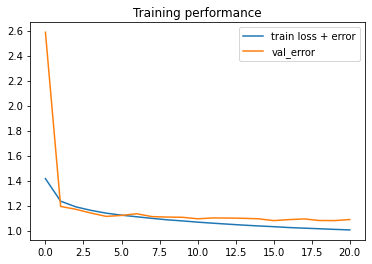

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

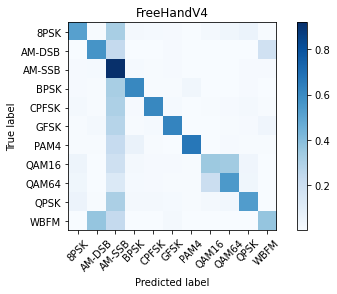

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08841010401188708


Overall Accuracy:  0.09242144177449169


Overall Accuracy:  0.0975609756097561


Overall Accuracy:  0.12087139845397049


Overall Accuracy:  0.14414739884393063


Overall Accuracy:  0.21661296097386323


Overall Accuracy:  0.3231816553206736


Overall Accuracy:  0.484375


Overall Accuracy:  0.6272630457933972


Overall Accuracy:  0.7408339324227174


Overall Accuracy:  0.8198983297022513


Overall Accuracy:  0.8431301839163361


Overall Accuracy:  0.8554079696394687


Overall Accuracy:  0.8604477611940299


Overall Accuracy:  0.8566282420749279


Overall Accuracy:  0.8549033904484141


Overall Accuracy:  0.8522769344687153


Overall Accuracy:  0.8664911620910116


Overall Accuracy:  0.8677229182019159


Overall Accuracy:  0.8573476702508961


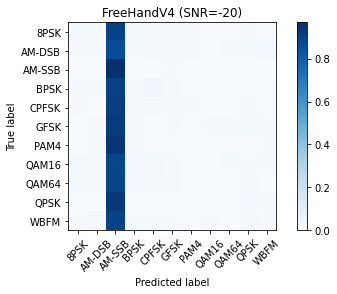

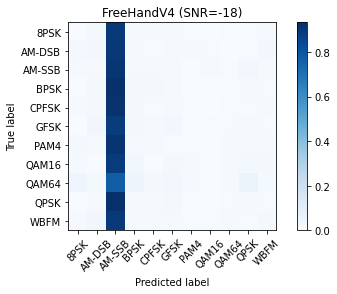

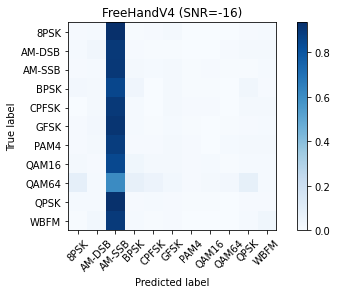

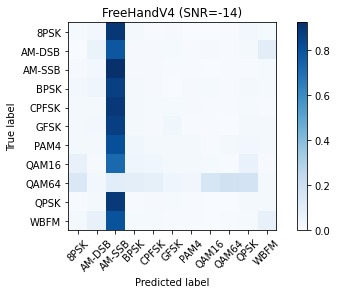

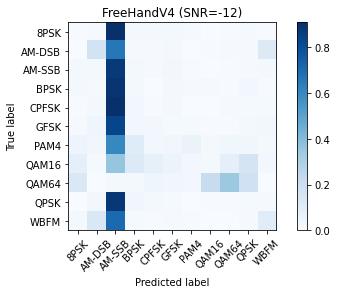

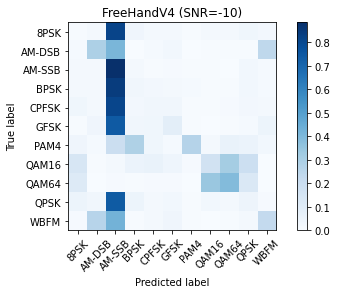

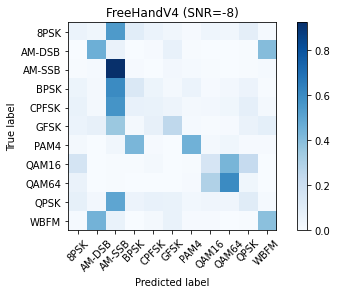

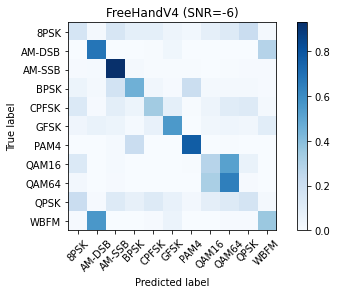

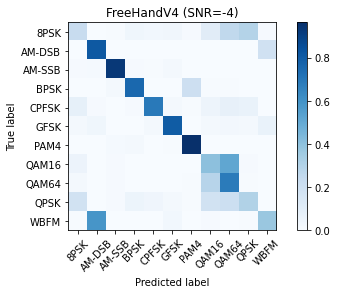

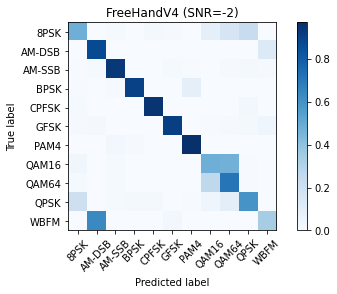

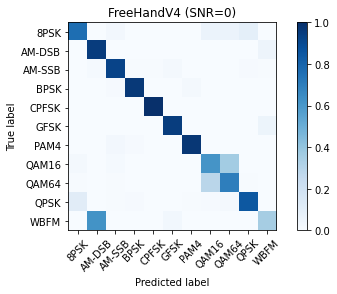

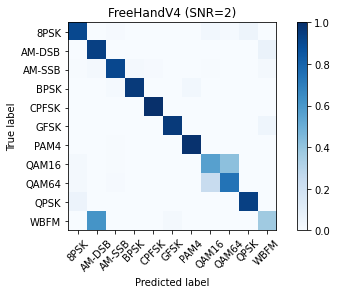

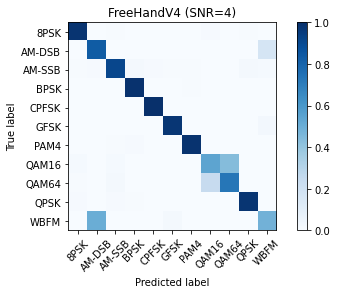

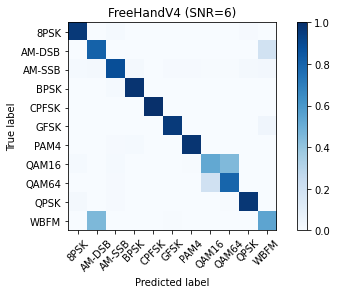

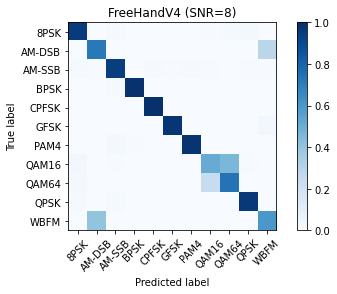

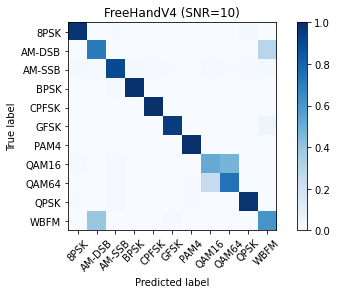

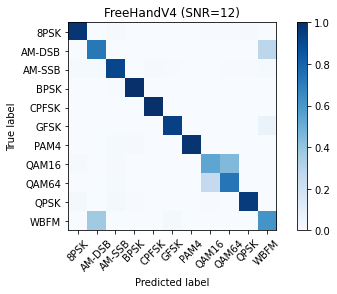

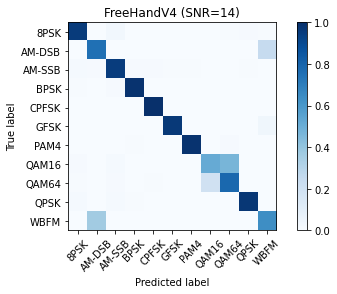

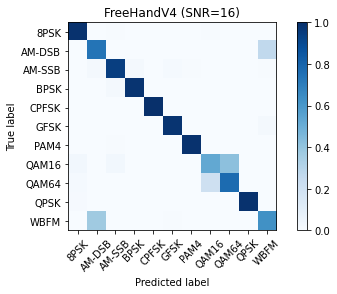

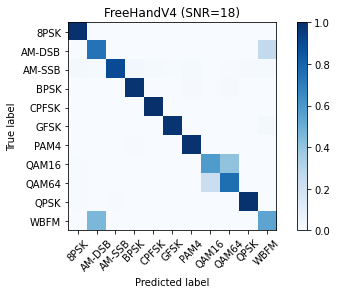

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,12,14,21,32,48,62,74,81,84,85,86,85,85,85,86,86,85


In [18]:
import statistics

statistics.mean(acc.values())

0.5734966237596327

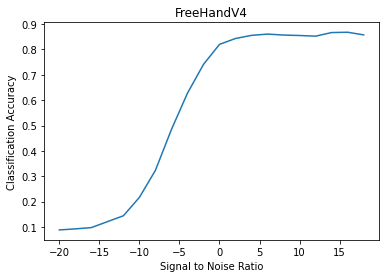

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)